# **neuroAI for biomedical engineering**

A. Lozano 03/03/2025

In [ ]:
# 1. Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
# Import required functions
from skimage.filters import gabor_kernel
from skimage.transform import resize
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle


In [ ]:
# 2. Download a simple natural images dataset (CIFAR-10) and select a few images
num_images = 2000

(x_train, _), (x_test, _) = cifar10.load_data()
images = np.concatenate([x_train, x_test], axis=0)
subset_idx = np.random.choice(images.shape[0],num_images, replace=False)
subset_images = images[subset_idx]

print(f"The shape of the subset_images array is: {subset_images.shape}")

The shape of the subset_images array is: (2000, 32, 32, 3)


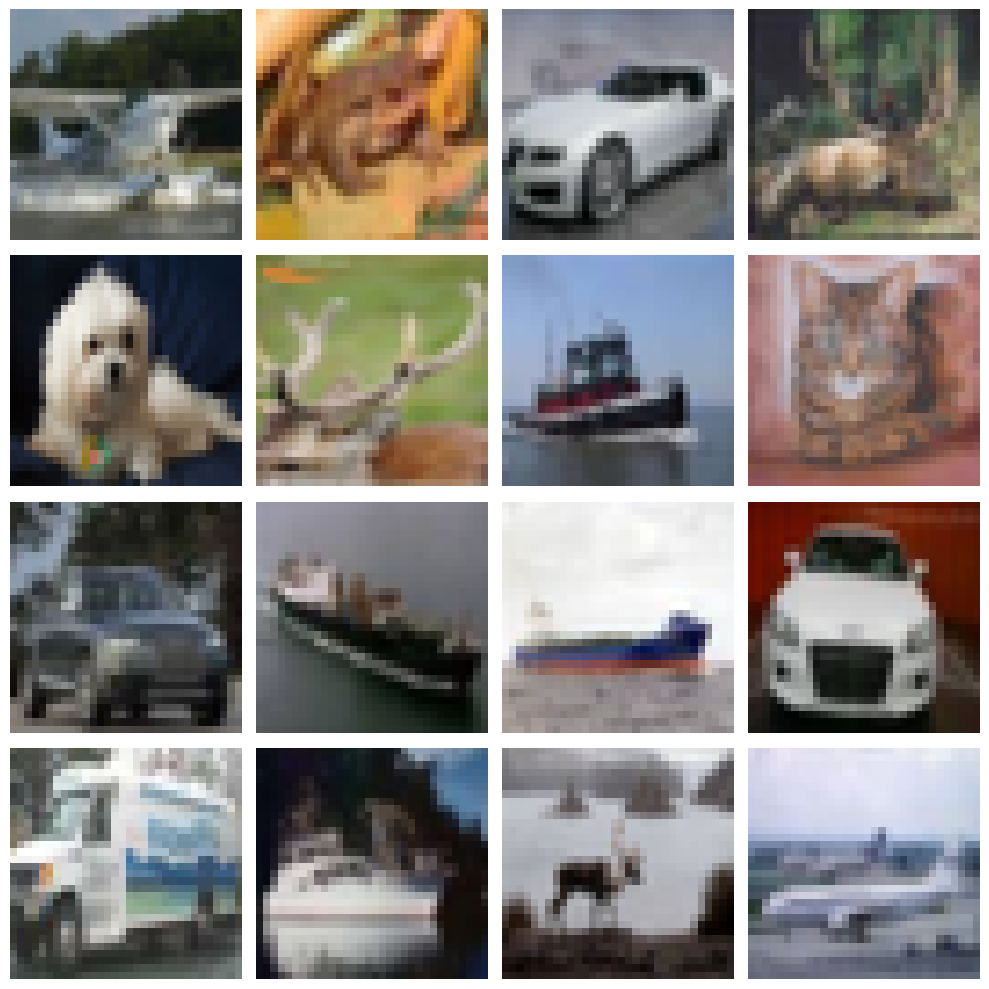

In [ ]:
# 3. Visualize a few random images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for ax in axs.flat:
    idx = np.random.randint(0, subset_images.shape[0])
    ax.imshow(subset_images[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Parameters
n_v1_cells = 20
n_sizes = 4
sizes = [5, 8, 11, 15]  # kernel sizes: 5x5, 8x8, 11x11, 15x15
frequency_range = (0.1, 0.3)  # cycles per pixel
img_height, img_width = 32, 32  # assuming CIFAR-10-like images



def generate_rgb_gabor_kernel(size, frequency_range, img_shape, mean_range=(0.5, 3)):
    # Sample frequency and orientation
    frequency = np.random.uniform(*frequency_range)
    theta = np.random.uniform(0, np.pi)
    sigma = size / 4.0  # sigma proportional to kernel size

    # Generate a 2D Gabor kernel (real part)
    kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))

    # Resize the kernel to the desired size
    kernel_resized = resize(kernel, (size, size), anti_aliasing=True)

    # Normalize the kernel to [-1, 1] (avoid division by zero with epsilon)
    eps = 1e-10
    kernel_norm = 2 * (kernel_resized - kernel_resized.min()) / (kernel_resized.max() - kernel_resized.min() + eps) - 1

    # Apply random RGB weights to form an RGB kernel
    color_weights = np.random.randn(3)
    kernel_rgb = np.stack([kernel_norm * weight for weight in color_weights], axis=-1)

    # Normalize the final RGB kernel to [-1, 1]
    kmin, kmax = kernel_rgb.min(), kernel_rgb.max()
    kernel_rgb = 2 * (kernel_rgb - kmin) / (kmax - kmin + eps) - 1

    # Adjust the mean so that it falls within the desired positive range.
    # Compute current mean and sample a target mean from the given range.
    current_mean = np.mean(kernel_rgb)
    target_mean = np.random.uniform(*mean_range)
    kernel_rgb = kernel_rgb - current_mean + target_mean

    # Generate RF coordinates: top-left corner so that the SxS patch fits in the image
    max_x = img_shape[1] - size
    max_y = img_shape[0] - size
    x_coord = np.random.randint(0, max_x + 1)
    y_coord = np.random.randint(0, max_y + 1)
    coords = (x_coord, y_coord)

    return kernel_rgb, frequency, size, coords

# Generate V1 cells: distribute cells equally among the defined sizes
v1_cells = []
cells_per_size = n_v1_cells // n_sizes

for size in sizes:
    for _ in range(cells_per_size):
        # Call the updated generator with the desired mean range.
        v1_cells.append(generate_rgb_gabor_kernel(size, frequency_range, (img_height, img_width), mean_range=(0.1, 0.5)))

# Function to normalize image for visualization
def norm_img(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-10)

# Visualize the generated kernels with titles showing size, frequency, cycles, and RF coordinates
cols = 5
rows = len(v1_cells) // cols + (len(v1_cells) % cols > 0)
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axs = axs.flatten()

for ax, (kernel, freq, size, coords) in zip(axs, v1_cells):
    cycles = freq * size  # approximate number of cycles across the kernel
    ax.imshow(norm_img(kernel))
    ax.set_title(f"Size: {size} | Freq: {freq:.2f}\nCycles: {cycles:.2f} | RF: {coords}",
                 fontsize=12, pad=8)
    ax.axis('off')

# Hide any unused subplots
for ax in axs[len(v1_cells):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



NameError: name 'selected_neurons' is not defined

# V1 cells on their receptive fields

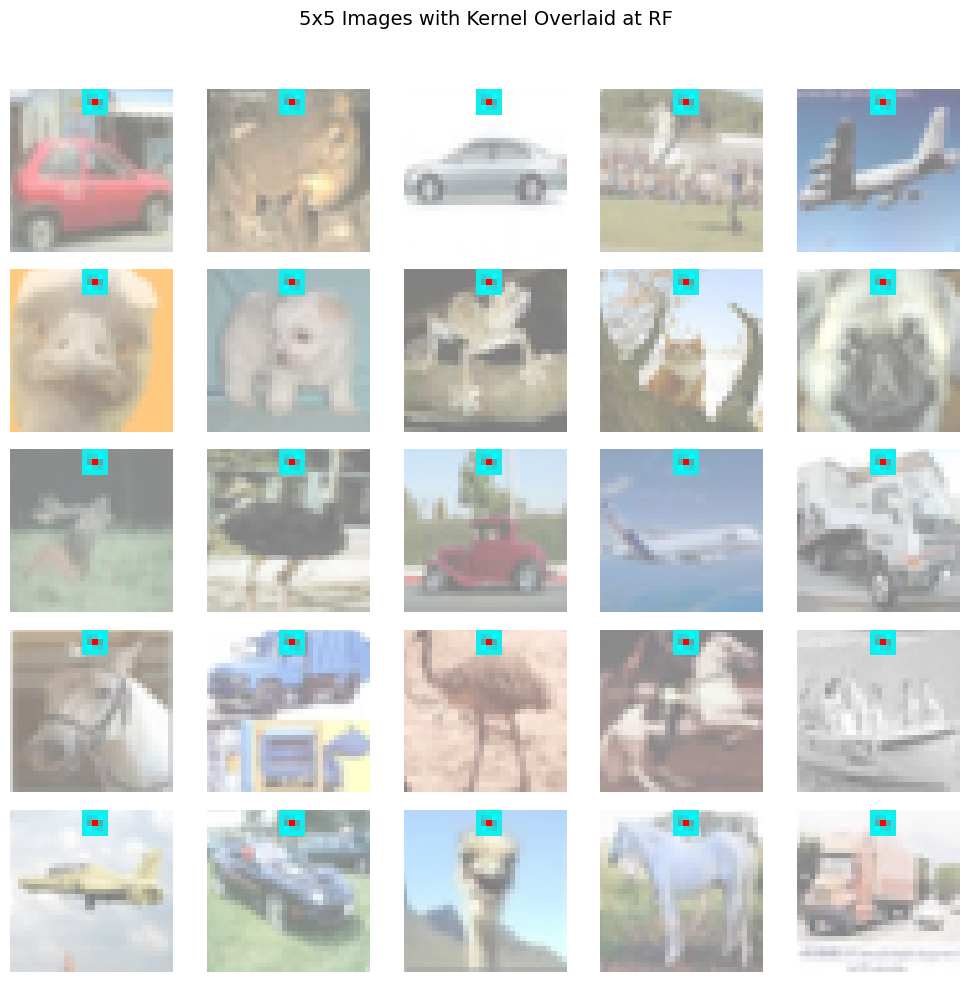

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.filters import gabor_kernel

# --- Utility Functions ---
def norm_img(img):
    """Normalize an image to [0,1] for display.
    If the image is RGB, normalize each channel independently.
    """
    if img.ndim == 3 and img.shape[-1] == 3:
        normed = np.empty_like(img, dtype=np.float32)
        for c in range(3):
            channel = img[..., c]
            normed[..., c] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-10)
        return normed
    else:
        return (img - img.min()) / (img.max() - img.min() + 1e-10)

def norm_img_with_alpha(img, threshold=0.1):
    """
    Normalize an RGB image to [0,1] and add an alpha channel that masks out
    pixels close to the mean (which becomes gray after normalization).
    Pixels with an intensity (averaged over channels) near 0.5 (the midpoint)
    will be made transparent.

    Parameters:
      img: input RGB image.
      threshold: threshold for masking (default 0.1); lower values make the mask more strict.

    Returns:
      An RGBA image.
    """
    normed = norm_img(img)
    # Compute intensity per pixel (average over channels)
    intensity = normed.mean(axis=-1)
    # Create an alpha mask: pixels close to 0.5 are made transparent.
    # Adjust the threshold to control sensitivity.
    alpha = np.where(np.abs(intensity - 0.5) < threshold, 0, 1).astype(np.float32)
    rgba = np.dstack([normed, alpha])
    return rgba

# --- Selected Neuron and Image Extraction ---
selected_neuron = 0  # arbitrarily defined
# v1_cells is assumed to be defined, with each element being (kernel_rgb, frequency, size, coords)
selected_kernel, selected_freq, selected_size, selected_coords = v1_cells[selected_neuron]
# Instead of just normalizing to [0,1], generate an RGBA image where the gray background is transparent.
selected_kernel_rgba = norm_img_with_alpha(selected_kernel, threshold=0.05)

# --- Prepare 25 Images for 5x5 Grid ---
# Assuming subset_images is a list of 25 images (e.g., from CIFAR-10)
# Convert images to float in [0,1]
images_5x5 = [img.astype(np.float32) / 255.0 for img in subset_images[:25]]

# --- Get RF Coordinates ---
x_rf, y_rf = selected_coords  # RF coordinates (x, y) in a 32x32 image

# --- Create 5x5 Grid Figure with Kernel Overlaid ---
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for ax, img in zip(axs.flatten(), images_5x5):
    # Display the full 32x32 image with transparency (alpha=0.5)
    ax.imshow(img, alpha=0.5, origin='upper')
    # Overlay the RGBA kernel at its RF.
    # The extent is defined as [left, right, bottom, top]:
    #   left = x_rf, right = x_rf + selected_size,
    #   bottom = y_rf, top = y_rf + selected_size.
    ax.imshow(
        selected_kernel_rgba,
        extent=[x_rf, x_rf + selected_size, y_rf, y_rf + selected_size],
        interpolation='none',
        origin='upper'
    )
    # Set axis limits to enforce a 32x32 pixel coordinate system.
    ax.set_xlim(0, 32)
    ax.set_ylim(32, 0)  # y-axis reversed so that 0 is at the top
    ax.axis('off')

plt.suptitle("5x5 Images with Kernel Overlaid at RF", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


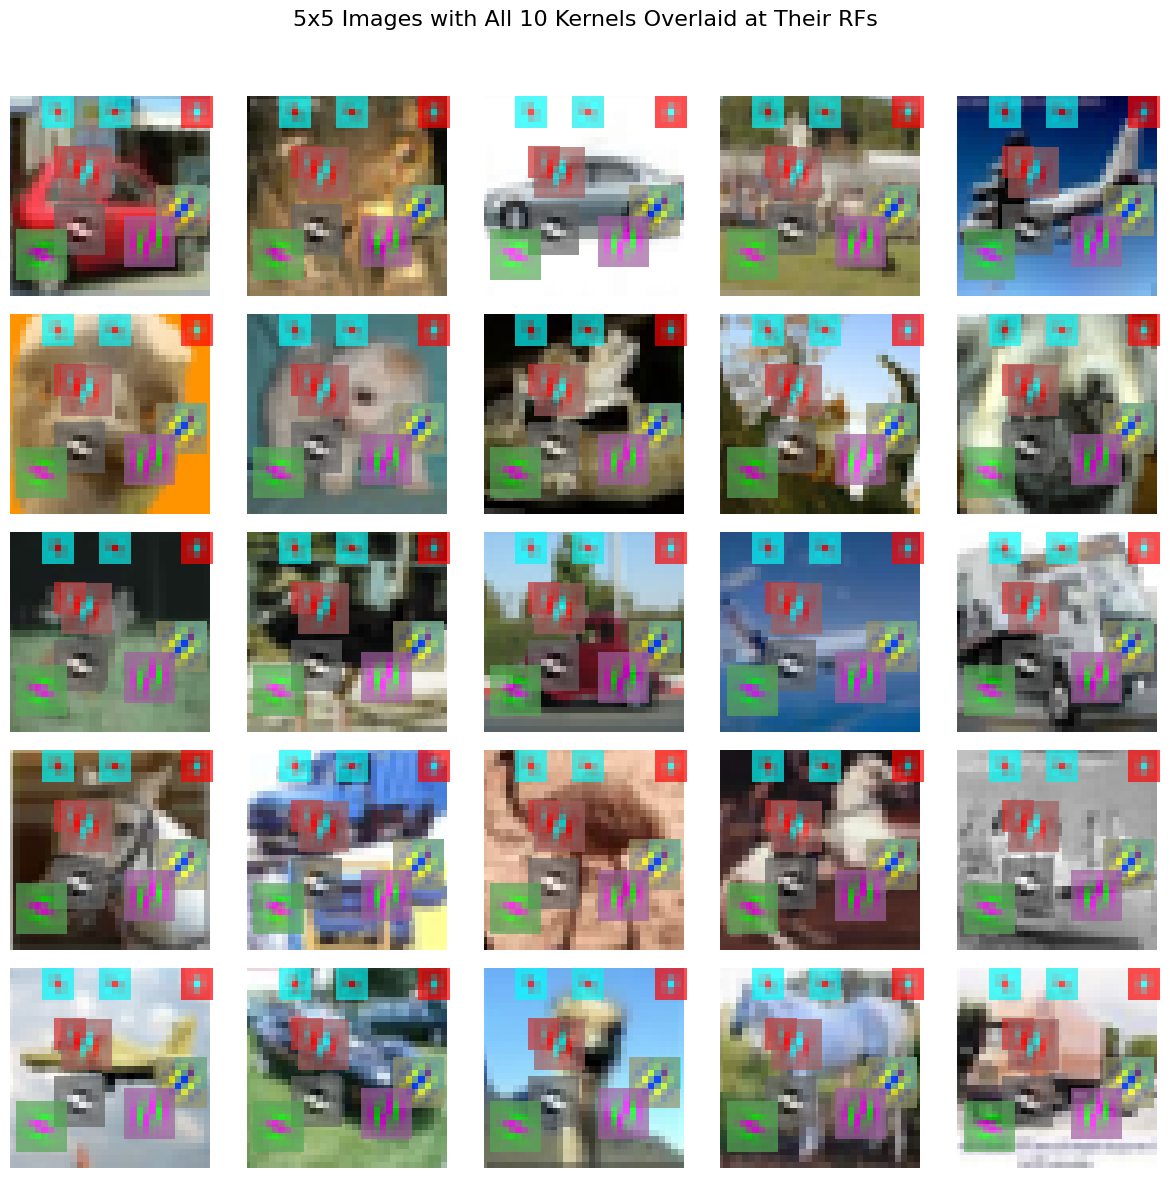

In [ ]:

# Convert images to float and scale them to [0,1]
subset_images = np.array([img.astype(np.float32) / 255.0 for img in subset_images])
H, W, C = subset_images[0].shape  # expected to be (32, 32, 3)

# --- Assume v1_cells is defined ---
# Each element in v1_cells is a tuple: (kernel_rgb, frequency, size, coords)
# For this snippet, we assume v1_cells already exists.
selected_kernels = v1_cells[:10]

# --- Prepare 25 Images for a 5x5 Grid ---
images_5x5 = [img for img in subset_images[:25]]

# --- Create a 5x5 Figure and Overlay All 10 Kernels on Each Image ---
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()

for ax, img in zip(axs, images_5x5):
    # Display the base image using the [0,1] range
    ax.imshow(img, vmin=0, vmax=1, origin='upper')
    # Overlay each of the 10 kernels (normalized to [0,1])
    for kernel_tuple in selected_kernels:
        kernel, freq, size, coords = kernel_tuple
        kernel_disp = norm_img(kernel)  # Normalize kernel to [0,1]
        x_rf, y_rf = coords  # RF coordinates (top-left corner) in the 32x32 image
        # Define the extent so that the kernel appears at its natural size:
        # extent = [left, right, top, bottom]
        extent = [x_rf, x_rf + size, y_rf, y_rf + size]
        ax.imshow(kernel_disp, vmin=0, vmax=1, alpha=0.7,
                  extent=extent, interpolation='none', origin='upper')
    # Fix the axis to the image coordinate system (32x32 pixels)
    ax.set_xlim(0, 32)
    ax.set_ylim(32, 0)  # Inverted y-axis so that (0,0) is top-left
    ax.axis('off')

plt.suptitle("5x5 Images with All 10 Kernels Overlaid at Their RFs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


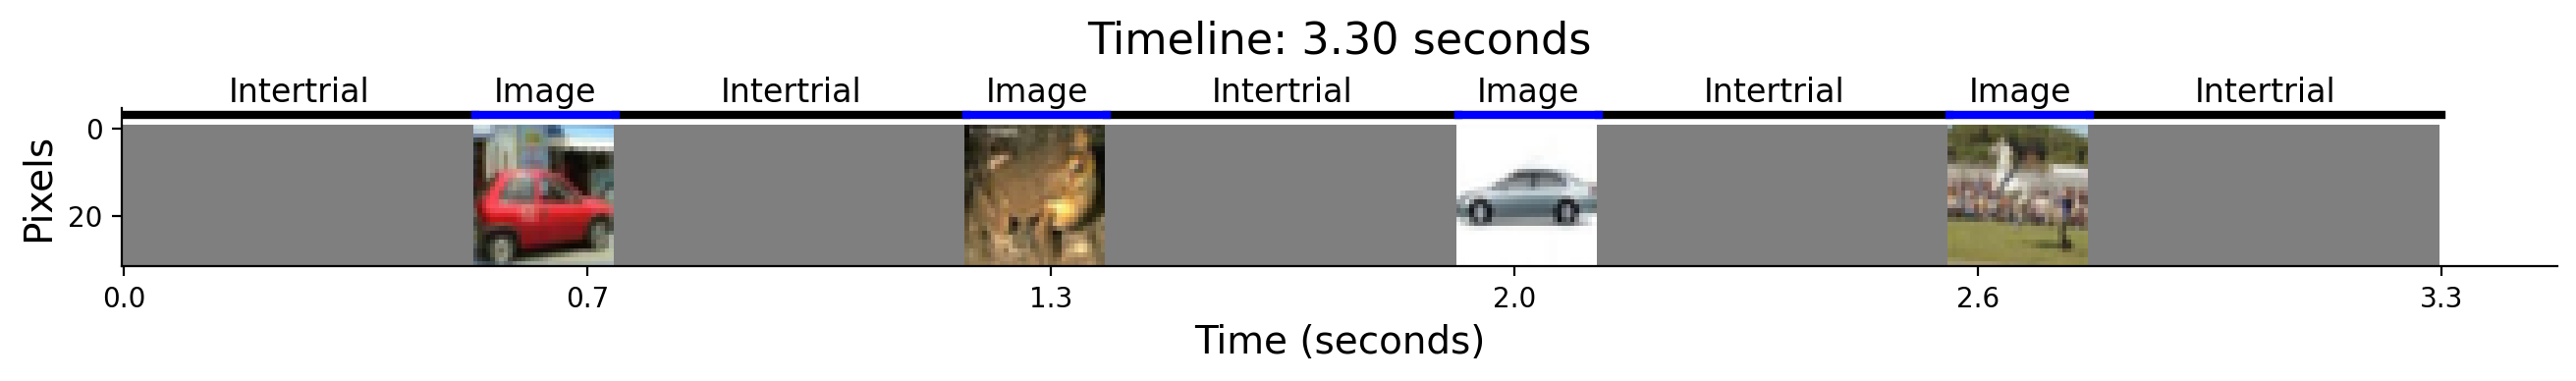

In [ ]:

# --- Parameters (in ms) ---
N = 4                  # Number of image trials
trial_time = 200       # Duration each image is shown (ms)
intertrial_time = 500  # Duration of gray background (ms)

# --- Compute Segment Widths ---
trial_width = W  # image is displayed at its original width (32 pixels)
gray_width = int(round((intertrial_time / trial_time) * trial_width))

# Create a gray patch (using mid-gray 0.5)
gray_patch = np.ones((H, gray_width, 3), dtype=np.float32) * 0.5

# --- Select N Images ---
selected_images = subset_images[:N]

# --- Build the Timeline ---
segments = [gray_patch]  # initial gray period
trial_positions = []     # Store positions for marking the image display periods
intertrial_positions = []  # Store positions for marking intertrial periods

current_x = gray_width  # initial gray period occupies [0, gray_width]
for img in selected_images:
    trial_positions.append((current_x, current_x + trial_width))  # Mark image display period
    current_x += trial_width
    intertrial_positions.append((current_x, current_x + gray_width))  # Mark intertrial period
    current_x += gray_width

# Concatenate segments: initial gray period + (for each trial: image then gray period)
timeline_image = np.concatenate(
    [gray_patch] + [seg for i in range(N) for seg in (selected_images[i], gray_patch)],
    axis=1
)

# --- Time Axis Conversion ---
ms_per_pixel = trial_time / trial_width
seconds_per_pixel = ms_per_pixel / 1000.0   # Convert ms to seconds
total_pixels = timeline_image.shape[1]
total_time_sec = total_pixels * seconds_per_pixel

# --- Plot the Timeline ---
fig, ax = plt.subplots(figsize=(16, 4), dpi=200)
ax.imshow(timeline_image, vmin=0, vmax=1, interpolation='nearest')
ax.set_xlabel("Time (seconds)", fontsize=14)
ax.set_ylabel("Pixels", fontsize=14)

# Convert pixel positions to time in seconds for x-ticks
xticks = np.linspace(0, total_pixels, 6)  # 6 evenly spaced ticks
xticklabels = [f"{(x * seconds_per_pixel):.1f}" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# y-offset for horizontal annotation bars above the timeline
y_offset = -35  # Offset above the images

# Add red horizontal bar for the initial gray period (first intertrial)
ax.plot([0, gray_width], [H + y_offset, H + y_offset], 'black', linewidth=3)
ax.text(gray_width / 2, H + y_offset - 3, "Intertrial", color='black', fontsize=12, ha='center')

# Add red horizontal bars for intertrial periods after each image
for start, end in intertrial_positions:
    ax.plot([start, end], [H + y_offset, H + y_offset], 'black', linewidth=3)
    ax.text((start + end) / 2, H + y_offset - 3, "Intertrial", color='black', fontsize=12, ha='center')

# Add blue horizontal bars for image (trial) periods
for start, end in trial_positions:
    ax.plot([start, end], [H + y_offset, H + y_offset], 'b', linewidth=3)
    ax.text((start + end) / 2, H + y_offset - 3, "Image", color='black', fontsize=12, ha='center')

# Remove upper and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Title with total duration in seconds
plt.title(f"Timeline: {total_time_sec:.2f} seconds", fontsize=16, pad=20)
plt.show()


In [ ]:

# Parameters
N_total = num_images       # Total number of image trials used for calculation
N_plot = 3         # Number of image trials to display in the plot
trial_time = 200   # Duration each image is shown (ms)
intertrial_time = 500  # Duration of gray background (ms)
bin_size = 10      # Temporal resolution: 10 ms per bin

bins_image = trial_time // bin_size         # e.g. 200/10 = 20 bins per image
bins_intertrial = intertrial_time // bin_size  # e.g. 500/10 = 50 bins per intertrial

# --- Define Gray Input ---
gray_input = np.ones((H, W, C), dtype=np.float32) * 0.5

# --- Build Temporal Dataset ---
# Use N_total trials for full calculation.
selected_images = subset_images[:N_total]
temporal_inputs = []

# Initial intertrial period
for _ in range(bins_intertrial):
    temporal_inputs.append(gray_input.copy())

# For each trial: image period then intertrial period
for img in selected_images:
    for _ in range(bins_image):
        temporal_inputs.append(img.copy())
    for _ in range(bins_intertrial):
        temporal_inputs.append(gray_input.copy())

temporal_inputs = np.array(temporal_inputs)  # Shape: (T, 32, 32, 3)
T = temporal_inputs.shape[0]
print("Temporal dataset shape:", temporal_inputs.shape)  # e.g., (bins_intertrial + N_total*(bins_image+bins_intertrial), 32, 32, 3)

# --- Compute Firing Rates for Each Neuron ---
# v1_cells is assumed to be defined.
# Each element in v1_cells is a tuple: (kernel_rgb, frequency, size, coords)
num_neurons = len(v1_cells)
firing_rates = np.zeros((T, num_neurons), dtype=np.float32)

for i, (kernel, freq, size, coords) in enumerate(v1_cells):
    x_rf, y_rf = coords  # receptive field (top-left corner)
    # Extract patch from each time bin: shape (T, size, size, 3)
    patch = temporal_inputs[:, y_rf:y_rf+size, x_rf:x_rf+size, :]
    # Compute dot product (sum over spatial & channel dimensions) as firing rate
    firing_rates[:, i] = np.sum(patch * kernel, axis=(1, 2, 3))
print("Firing rates shape:", firing_rates.shape)



Temporal dataset shape: (140050, 32, 32, 3)
Firing rates shape: (140050, 20)


In [ ]:
# --- Postprocessing: Adjust firing rates so that each neuron's median is 0 ---
# Compute the median firing rate per neuron (across time, i.e., axis=0)
neuron_medians = np.median(firing_rates, axis=0)  # shape: (num_neurons,)

# Subtract the median from each neuron's firing rates using broadcasting
firing_rates_adjusted = firing_rates - neuron_medians[np.newaxis, :]

# Verify that the median for each neuron is now 0 (or very close to 0)
new_medians = np.median(firing_rates_adjusted, axis=0)
for i, m in enumerate(new_medians):
    print(f"Neuron {i}: Adjusted median firing rate = {m:.2f}")

# Optionally, replace the original firing_rates with the adjusted version:
firing_rates = firing_rates_adjusted


Neuron 0: Adjusted median firing rate = 0.00
Neuron 1: Adjusted median firing rate = 0.00
Neuron 2: Adjusted median firing rate = 0.00
Neuron 3: Adjusted median firing rate = 0.00
Neuron 4: Adjusted median firing rate = 0.00
Neuron 5: Adjusted median firing rate = 0.00
Neuron 6: Adjusted median firing rate = 0.00
Neuron 7: Adjusted median firing rate = 0.00
Neuron 8: Adjusted median firing rate = 0.00
Neuron 9: Adjusted median firing rate = 0.00
Neuron 10: Adjusted median firing rate = 0.00
Neuron 11: Adjusted median firing rate = 0.00
Neuron 12: Adjusted median firing rate = 0.00
Neuron 13: Adjusted median firing rate = 0.00
Neuron 14: Adjusted median firing rate = 0.00
Neuron 15: Adjusted median firing rate = 0.00
Neuron 16: Adjusted median firing rate = 0.00
Neuron 17: Adjusted median firing rate = 0.00
Neuron 18: Adjusted median firing rate = 0.00
Neuron 19: Adjusted median firing rate = 0.00


In [ ]:
import numpy as np

# Assume firing_rates is already median-adjusted (median=0 per neuron) and of shape (T, num_neurons)

# 1. Rectify: Set any values below 0 to 0 (i.e. the median)
firing_rates_rectified = np.maximum(firing_rates, 0)

# 2. Normalize each neuron's rectified firing rates to the range [0, 5]
# Compute maximum per neuron (along time axis)
max_vals = np.max(firing_rates_rectified, axis=0, keepdims=True)
# Avoid division by zero: if a neuron's max is 0, leave its rates unchanged
firing_rates_normalized = np.where(max_vals > 0,
                                   5 * firing_rates_rectified / max_vals,
                                   firing_rates_rectified)

# Optionally, print some stats for verification:
num_neurons = firing_rates_normalized.shape[1]
for i in range(num_neurons):
    fr = firing_rates_normalized[:, i]
    print(f"Neuron {i}: min = {fr.min():.2f}, max = {fr.max():.2f}, mean = {fr.mean():.2f}")

# Now firing_rates_normalized contains values between 0 and 5 for each neuron.


Neuron 0: min = 0.00, max = 5.00, mean = 0.34
Neuron 1: min = 0.00, max = 5.00, mean = 0.21
Neuron 2: min = 0.00, max = 5.00, mean = 0.17
Neuron 3: min = 0.00, max = 5.00, mean = 0.32
Neuron 4: min = 0.00, max = 5.00, mean = 0.29
Neuron 5: min = 0.00, max = 5.00, mean = 0.15
Neuron 6: min = 0.00, max = 5.00, mean = 0.10
Neuron 7: min = 0.00, max = 5.00, mean = 0.14
Neuron 8: min = 0.00, max = 5.00, mean = 0.16
Neuron 9: min = 0.00, max = 5.00, mean = 0.19
Neuron 10: min = 0.00, max = 5.00, mean = 0.10
Neuron 11: min = 0.00, max = 5.00, mean = 0.10
Neuron 12: min = 0.00, max = 5.00, mean = 0.18
Neuron 13: min = 0.00, max = 5.00, mean = 0.19
Neuron 14: min = 0.00, max = 5.00, mean = 0.14
Neuron 15: min = 0.00, max = 5.00, mean = 0.11
Neuron 16: min = 0.00, max = 5.00, mean = 0.10
Neuron 17: min = 0.00, max = 5.00, mean = 0.19
Neuron 18: min = 0.00, max = 5.00, mean = 0.10
Neuron 19: min = 0.00, max = 5.00, mean = 0.17


In [ ]:
firing_rates = firing_rates_normalized

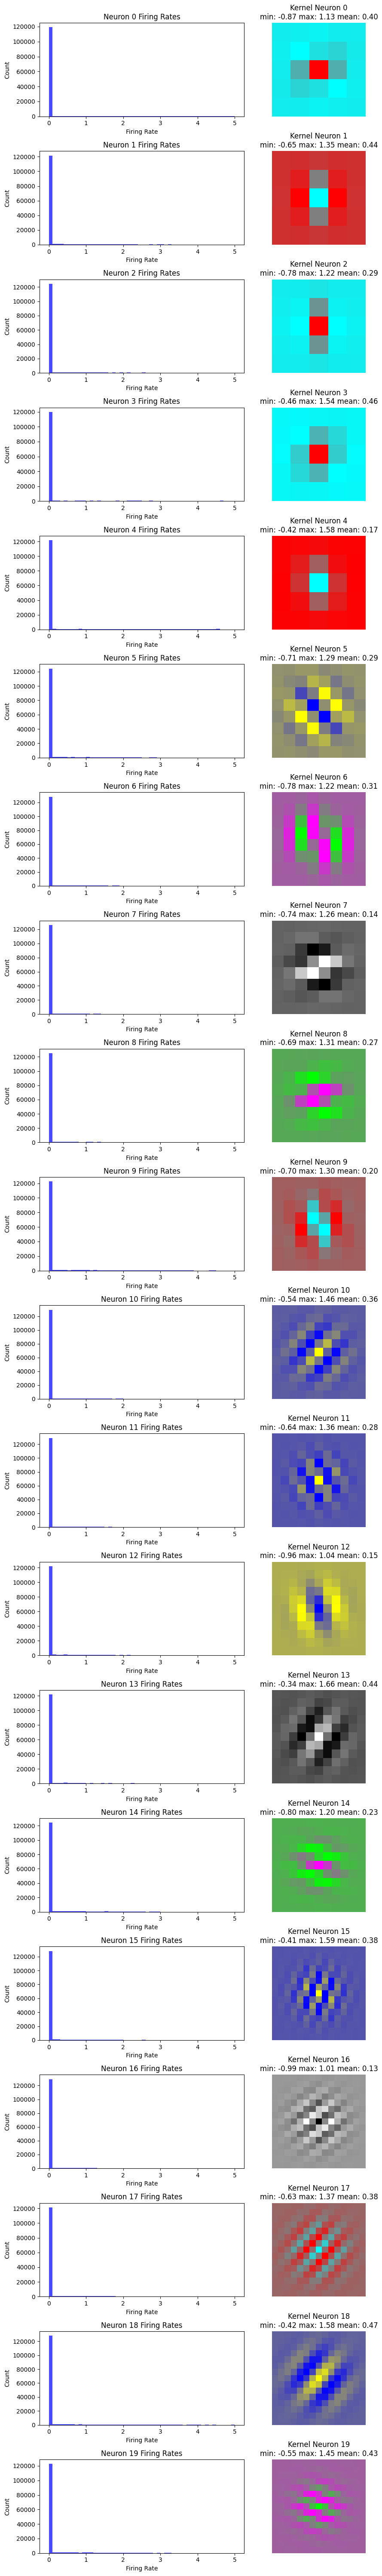

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Utility function: Normalize an image to [0,1] (per channel for RGB images)
def norm_img(img):
    """Normalize an image to [0,1] for display.
    If the image is RGB, normalize each channel independently.
    """
    if img.ndim == 3 and img.shape[-1] == 3:
        normed = np.empty_like(img, dtype=np.float32)
        for c in range(3):
            channel = img[..., c]
            normed[..., c] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-10)
        return normed
    else:
        return (img - img.min()) / (img.max() - img.min() + 1e-10)

# Assuming firing_rates is a 2D NumPy array with shape (T, num_neurons)
num_neurons = firing_rates.shape[1]

# Create a figure with two columns: one for histogram, one for kernel debug info
fig, axs = plt.subplots(num_neurons, 2, figsize=(10, 3 * num_neurons))

for i in range(num_neurons):
    # Left subplot: Histogram of firing rates for neuron i
    axs[i, 0].hist(firing_rates[:, i], bins=50, color='b', alpha=0.7)
    axs[i, 0].set_title(f'Neuron {i} Firing Rates')
    axs[i, 0].set_xlabel('Firing Rate')
    axs[i, 0].set_ylabel('Count')

    # Right subplot: Display the kernel used for neuron i and its stats.
    # Each element in v1_cells is assumed to be a tuple: (kernel_rgb, frequency, size, coords)
    kernel, freq, size, coords = v1_cells[i]
    # Normalize kernel for visualization
    kernel_disp = norm_img(kernel)

    # Calculate kernel statistics for debugging
    kmin, kmax, kmean = np.min(kernel), np.max(kernel), np.mean(kernel)
    axs[i, 1].imshow(kernel_disp, interpolation='nearest')
    axs[i, 1].set_title(f'Kernel Neuron {i}\nmin: {kmin:.2f} max: {kmax:.2f} mean: {kmean:.2f}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


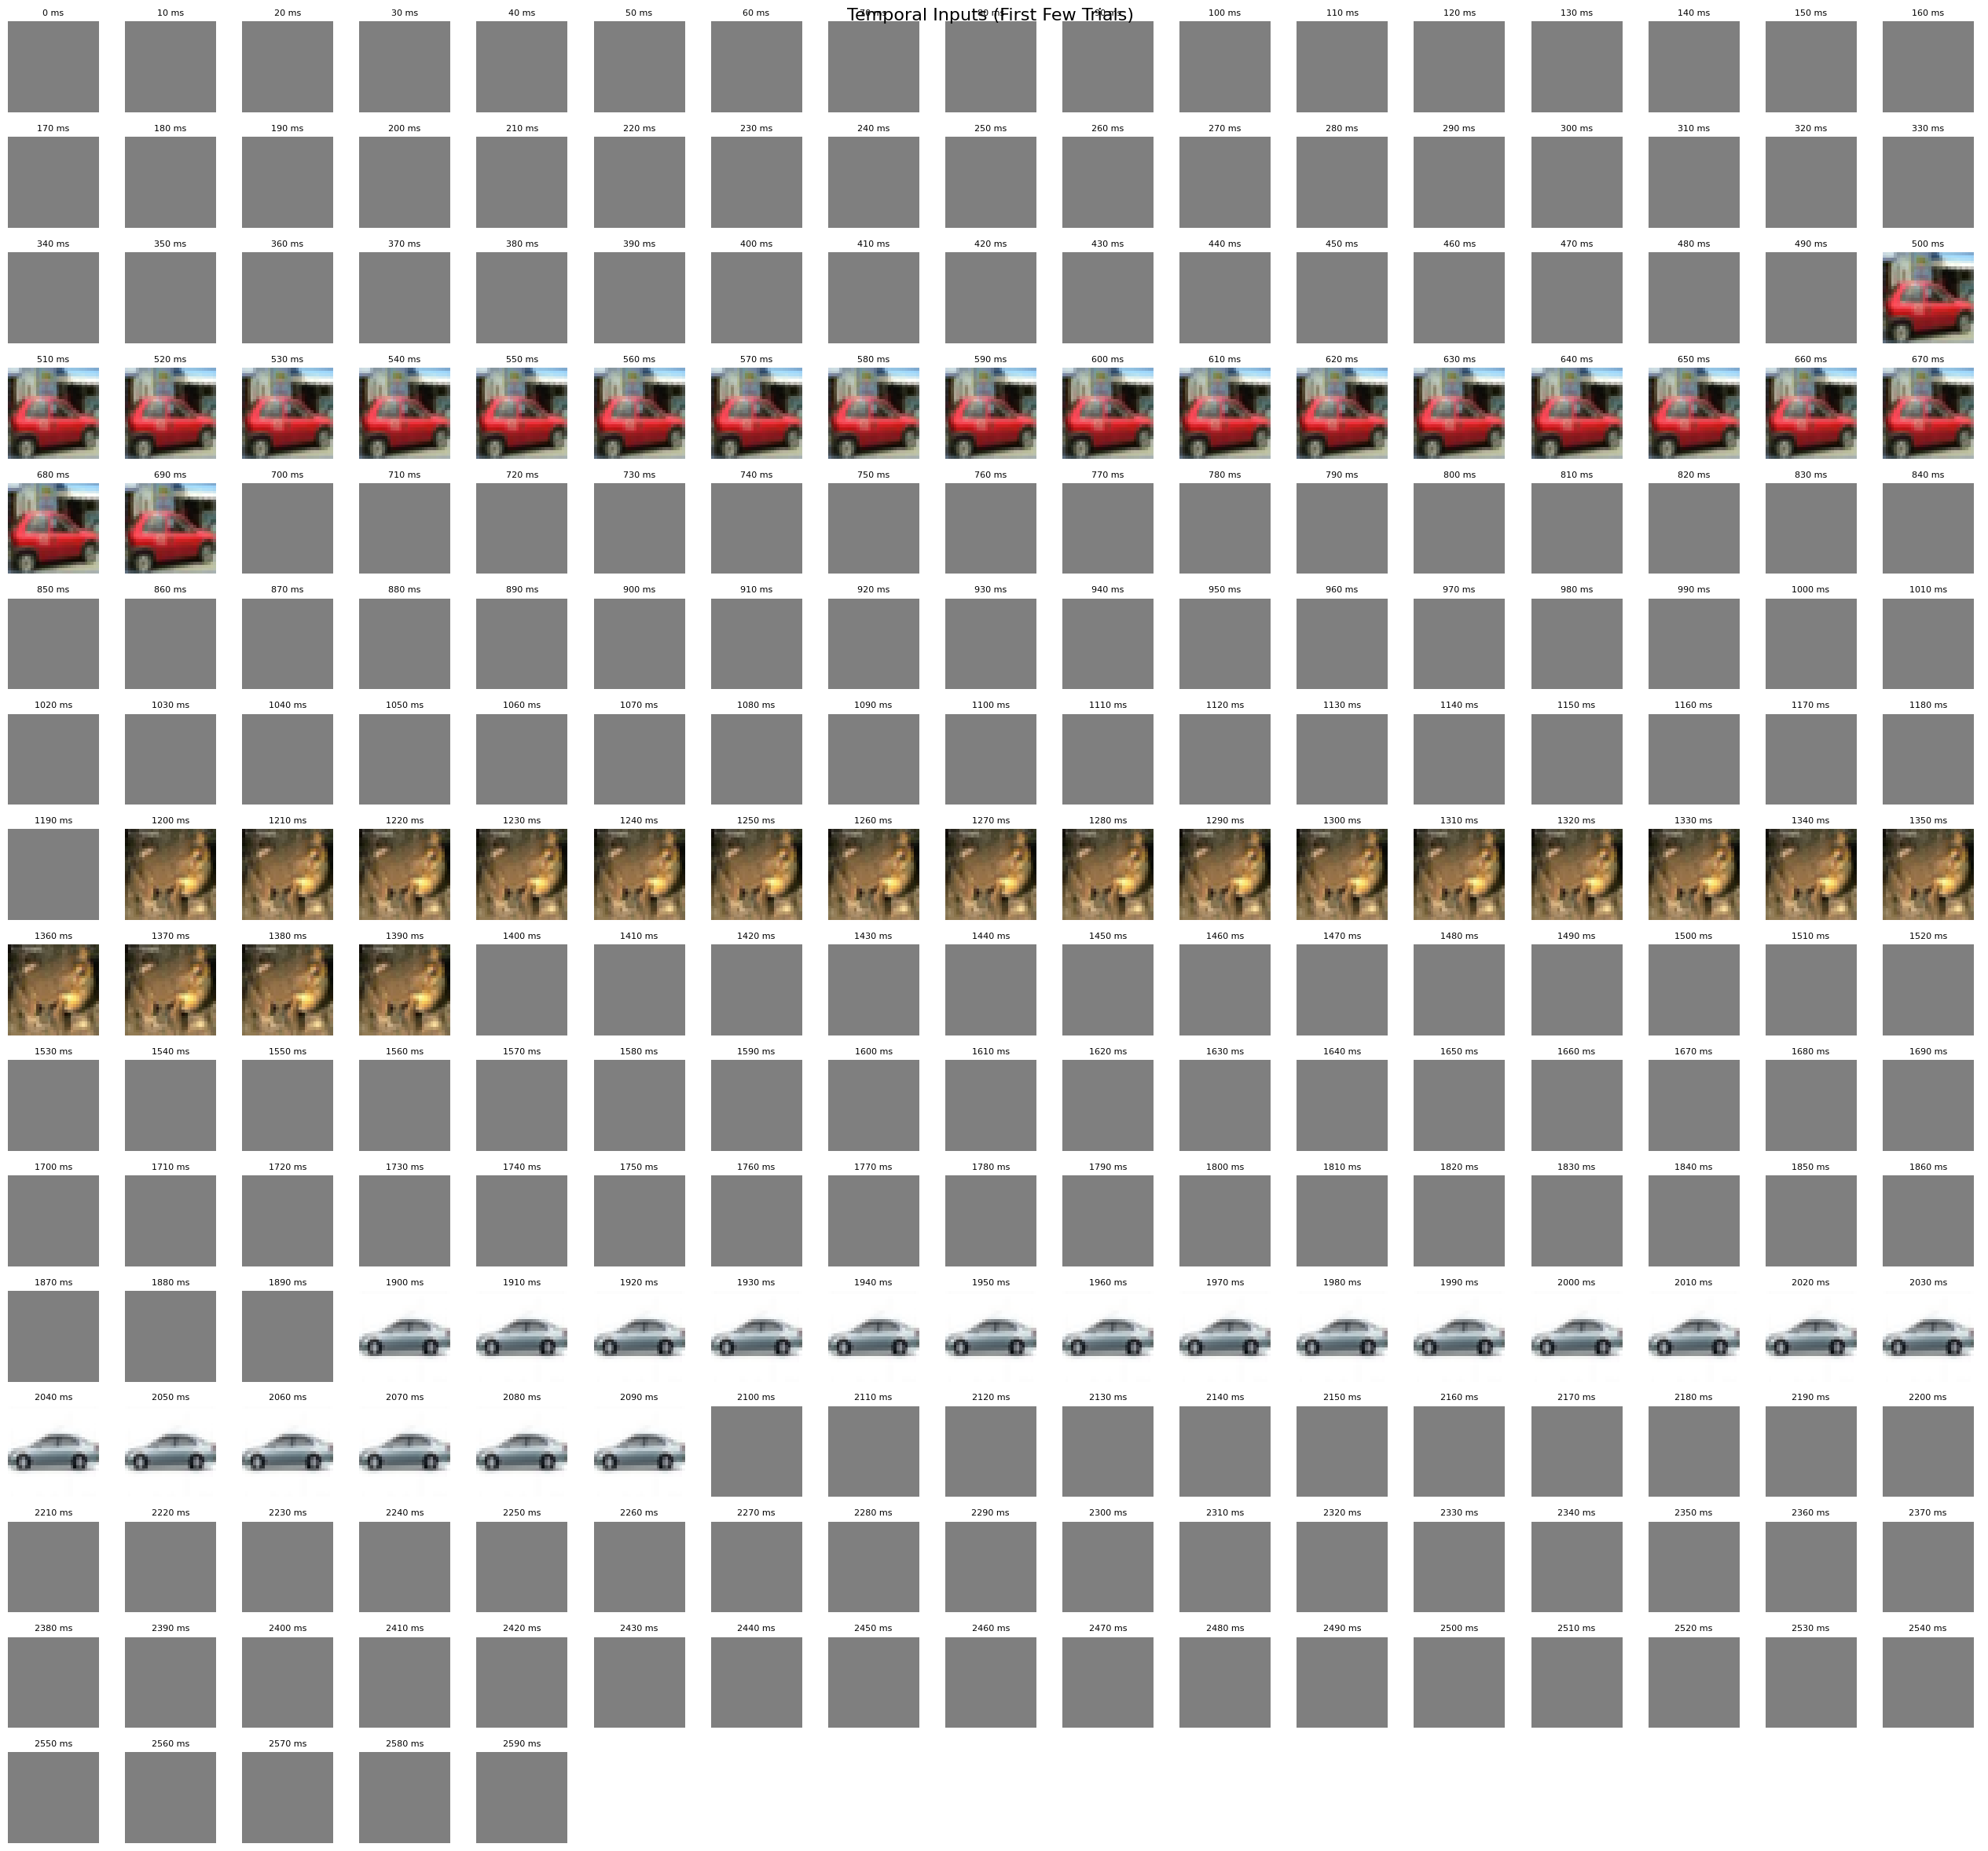

In [ ]:

# --- Plot Only the First Few Trials ---
# Calculate number of bins to plot for the first N_plot trials.
frames_to_plot = bins_intertrial + N_plot * (bins_image + bins_intertrial)
n_plot_frames = frames_to_plot

grid_cols = int(np.ceil(np.sqrt(n_plot_frames)))
grid_rows = int(np.ceil(n_plot_frames / grid_cols))
fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*1.5, grid_rows*1.5))
axs = axs.flatten()

for i in range(n_plot_frames):
    ax = axs[i]
    ax.imshow(temporal_inputs[i], vmin=0, vmax=1, origin='upper')
    ax.set_title(f"{i*bin_size} ms", fontsize=8)
    ax.axis("off")
for j in range(n_plot_frames, len(axs)):
    axs[j].axis("off")

plt.suptitle("Temporal Inputs (First Few Trials)", fontsize=16)
plt.tight_layout()
plt.show()

# Normalizing firing rates between 0 and 100


In [ ]:
# Assuming firing_rates is a 2D NumPy array of shape (n_neurons, n_measurements)

# 1. Set any negative firing rates to 0 (per neuron)
firing_rates = np.maximum(firing_rates, 0)

# 2. Normalize each neuron's firing rates to be between 0 and 10
max_vals = np.max(firing_rates, axis=1, keepdims=True)

# Avoid division by zero: if a neuron's max is 0, leave its rates unchanged
firing_rates_normalized = np.where(max_vals > 0, 5 * firing_rates / max_vals, firing_rates)


In [ ]:
firing_rates_normalized.shape

(140050, 20)

Neuron 0: Mean Firing Rate = 2.54
Neuron 1: Mean Firing Rate = 2.49
Neuron 2: Mean Firing Rate = 2.32
Neuron 3: Mean Firing Rate = 2.44
Neuron 4: Mean Firing Rate = 2.38
Neuron 5: Mean Firing Rate = 2.45
Neuron 6: Mean Firing Rate = 2.40
Neuron 7: Mean Firing Rate = 2.51
Neuron 8: Mean Firing Rate = 2.45
Neuron 9: Mean Firing Rate = 2.58
Neuron 10: Mean Firing Rate = 2.64
Neuron 11: Mean Firing Rate = 2.61
Neuron 12: Mean Firing Rate = 2.62
Neuron 13: Mean Firing Rate = 2.50
Neuron 14: Mean Firing Rate = 2.50
Neuron 15: Mean Firing Rate = 2.61
Neuron 16: Mean Firing Rate = 2.71
Neuron 17: Mean Firing Rate = 2.56
Neuron 18: Mean Firing Rate = 2.54
Neuron 19: Mean Firing Rate = 2.53


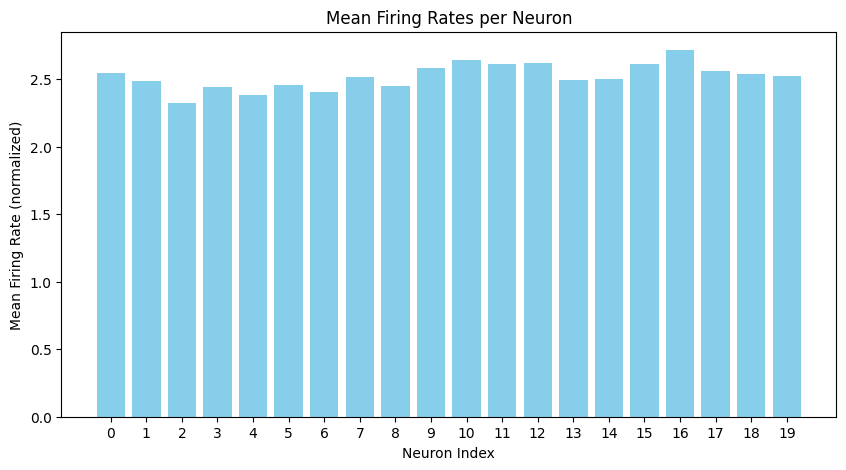

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming firing_rates is a 2D NumPy array of shape (T, num_neurons) = (140050, 20)

# 1. Set any negative firing rates to 0 (elementwise)
firing_rates = np.maximum(firing_rates, 0)

# 2. Normalize each neuron's firing rates (each column) to be between 0 and 10.
# Compute maximum per neuron along time (axis=0)
max_vals = np.max(firing_rates, axis=0, keepdims=True)
# Avoid division by zero: if a neuron's max is 0, leave its rates unchanged.
firing_rates_normalized = np.where(max_vals > 0, 5 * firing_rates / max_vals, firing_rates)

# Compute the mean firing rate of each neuron (average over time, i.e., axis=0)
mean_firing_rates = np.mean(firing_rates_normalized, axis=0)

# Print the mean firing rates for each neuron
for i, mean_rate in enumerate(mean_firing_rates):
    print(f"Neuron {i}: Mean Firing Rate = {mean_rate:.2f}")

# Plot the mean firing rates as a bar plot
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(mean_firing_rates)), mean_firing_rates, color='skyblue')
plt.xlabel('Neuron Index')
plt.ylabel('Mean Firing Rate (normalized)')
plt.title('Mean Firing Rates per Neuron')
plt.xticks(np.arange(len(mean_firing_rates)))
plt.show()


In [ ]:
firing_rates = firing_rates_normalized

# Plotting firing rates

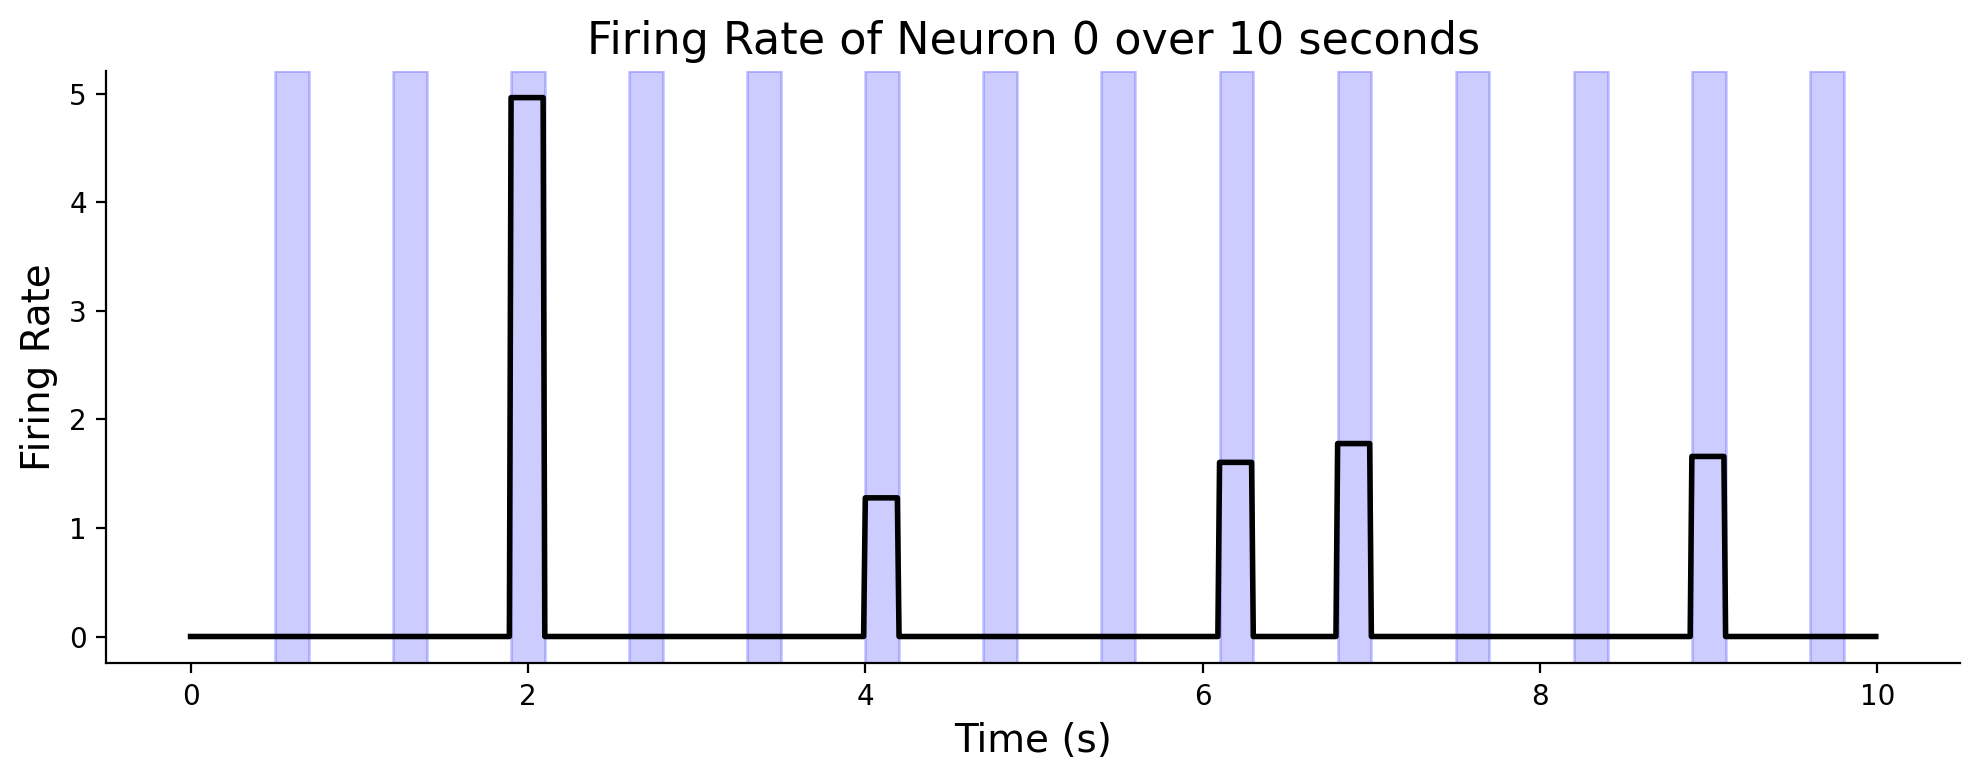

In [ ]:

N_seconds = 10  # Duration to plot (in seconds)
bins_to_plot = int(N_seconds * 1000 / bin_size)  # e.g., if bin_size=10 ms, then 10 s -> 1000 bins
selected_neuron = 0  # change as needed

# Create a time axis in seconds
time_axis = np.arange(bins_to_plot) * bin_size / 1000.0

plt.figure(figsize=(10, 4), dpi=200)

# Plot the firing rate with a black line
plt.plot(time_axis, firing_rates[:bins_to_plot, selected_neuron], lw=2, color='black')

# Add a blue shaded area for each image presentation period.
# The first image is presented from bin index = bins_intertrial to bins_intertrial+bins_image,
# then every trial follows the same structure.
i = 0
while True:
    start_bin = bins_intertrial + i * (bins_image + bins_intertrial)
    end_bin = start_bin + bins_image
    start_time = start_bin * bin_size / 1000.0
    end_time = end_bin * bin_size / 1000.0
    if start_time >= N_seconds:
        break
    if end_time > N_seconds:
        end_time = N_seconds
    plt.axvspan(start_time, end_time, color='blue', alpha=0.2)
    i += 1

# Add labels and title
plt.xlabel("Time (s)", fontsize=14, color='black')
plt.ylabel("Firing Rate", fontsize=14, color='black')
plt.title(f"Firing Rate of Neuron {selected_neuron} over {N_seconds} seconds", fontsize=16, color='black')

# Remove grid and adjust spines
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.tight_layout()
plt.show()


# Visualizing firing rates and raster plot of a selected neuron with N repetitions

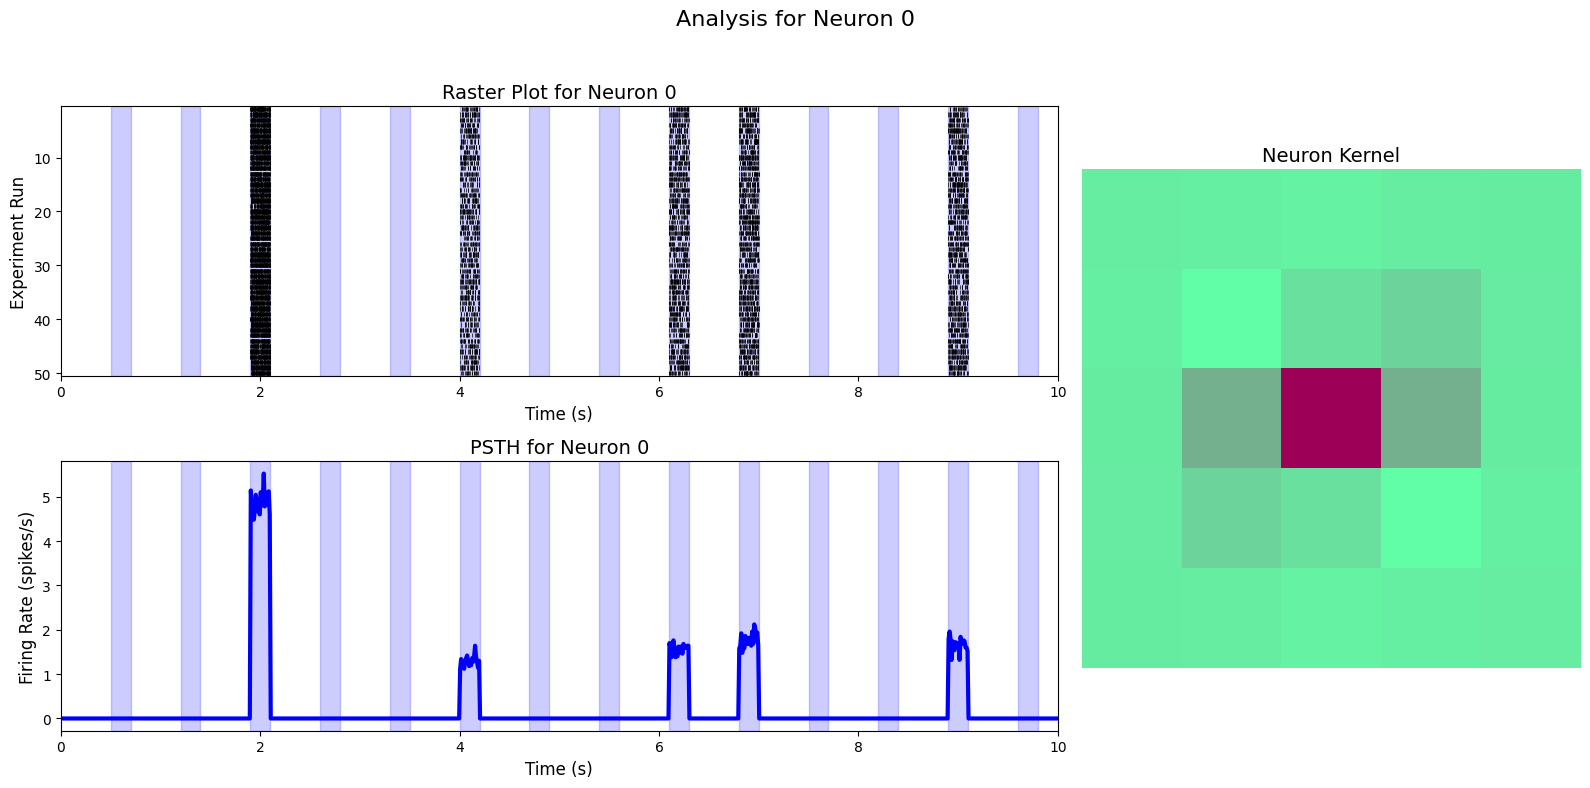

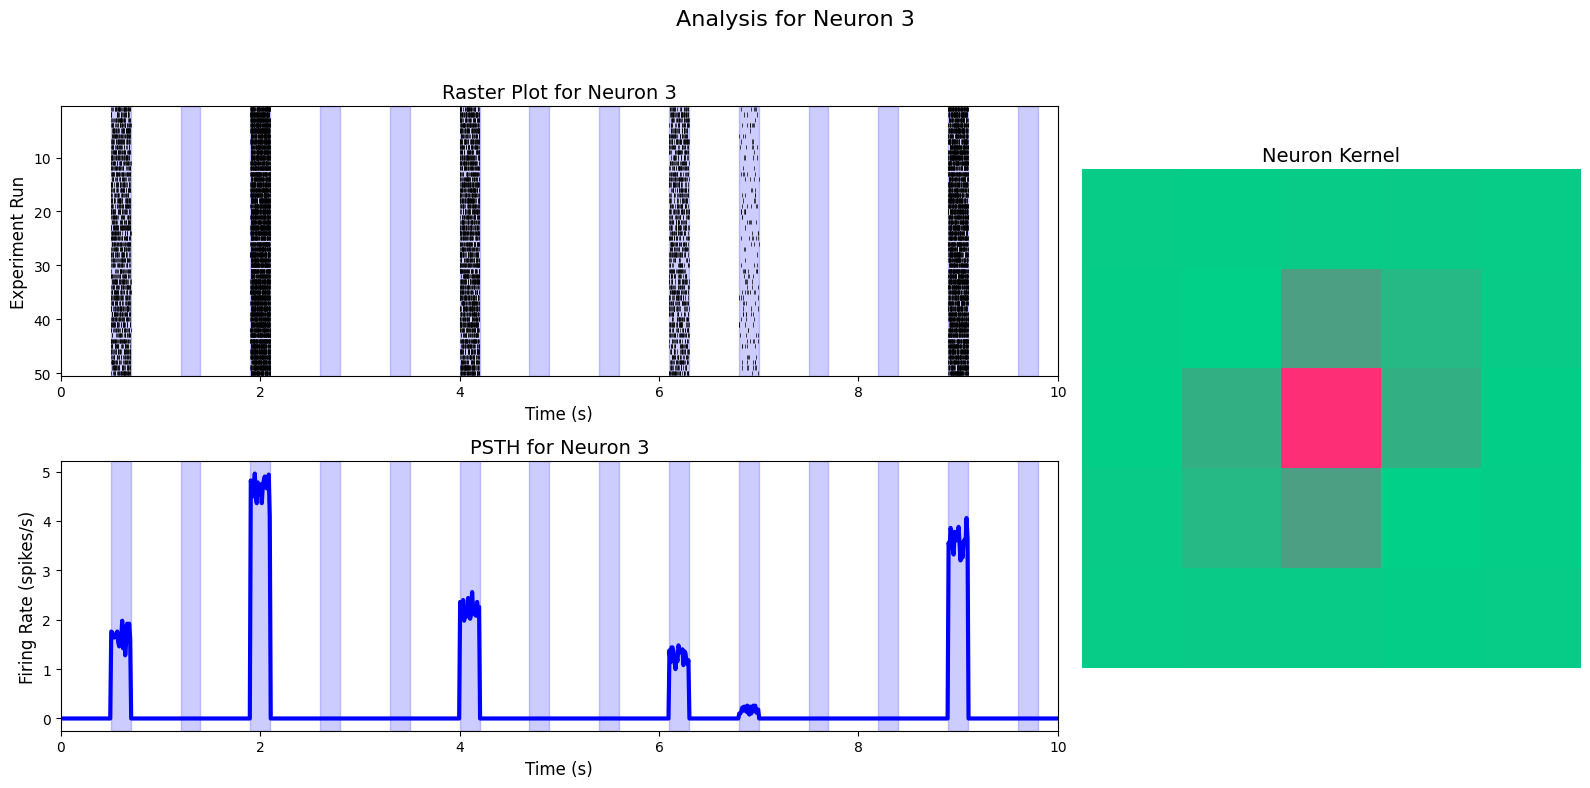

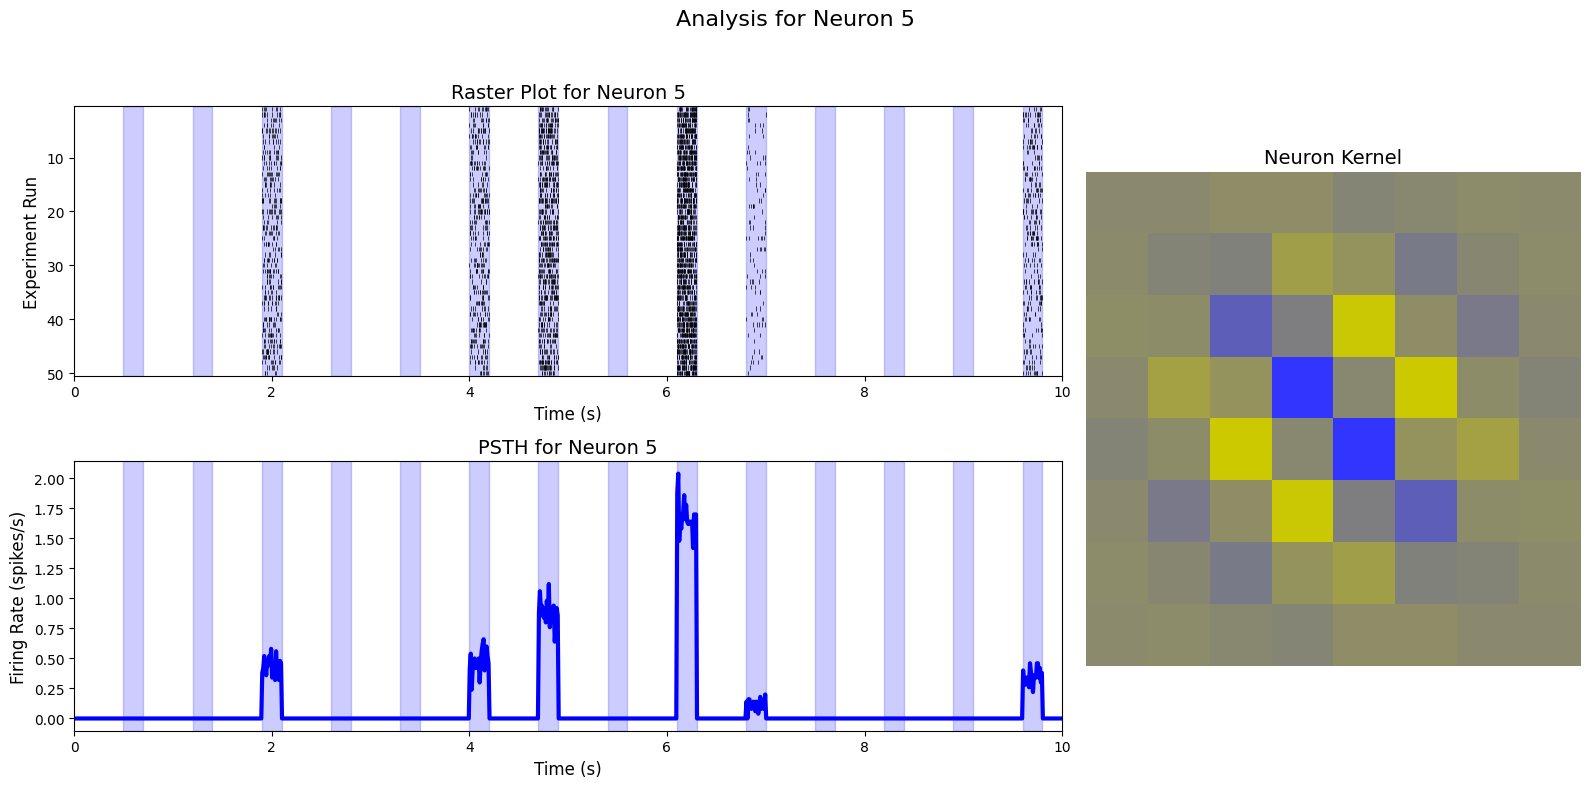

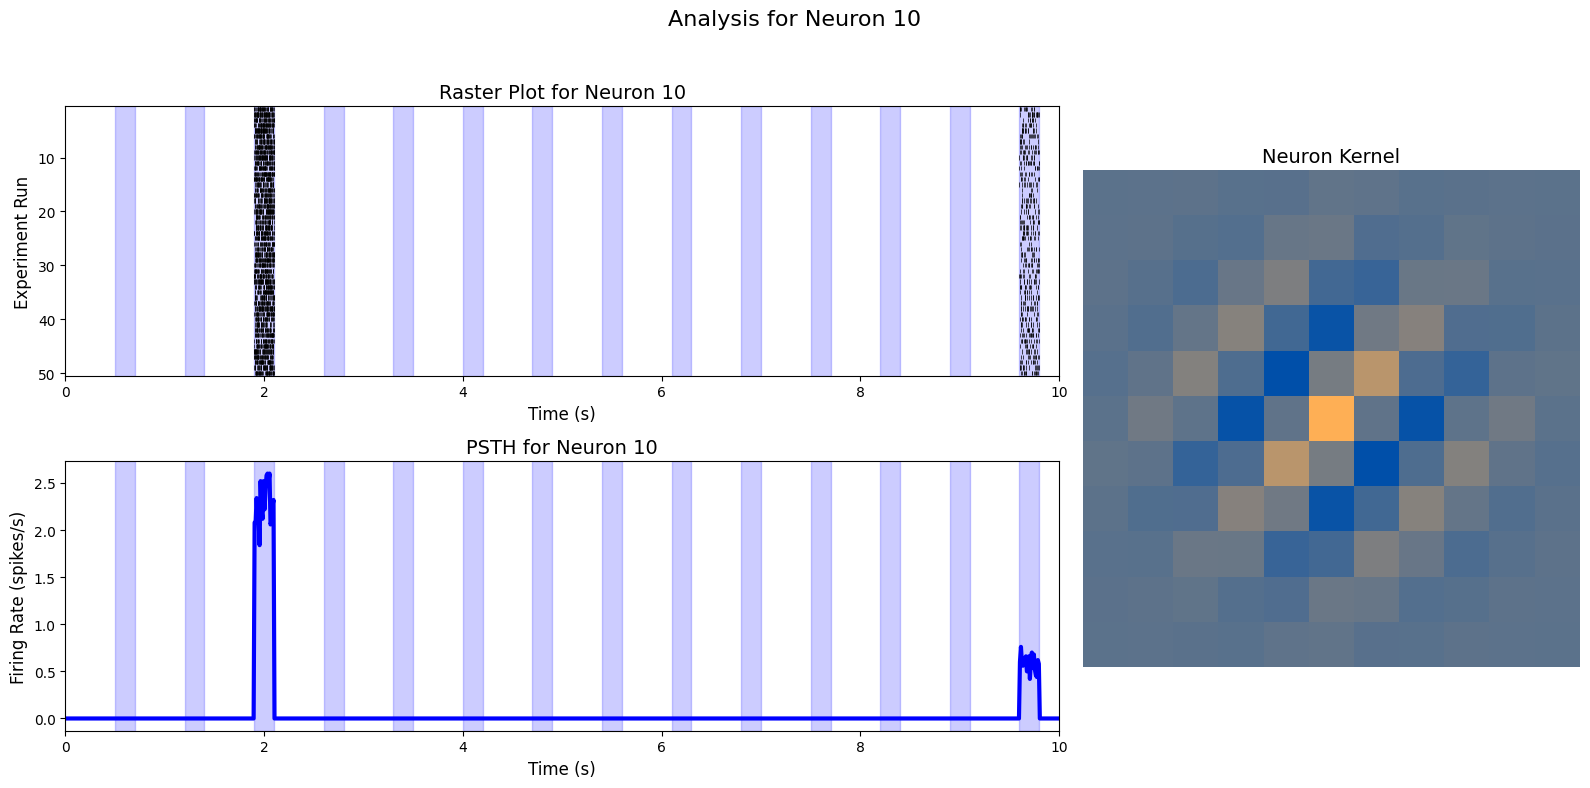

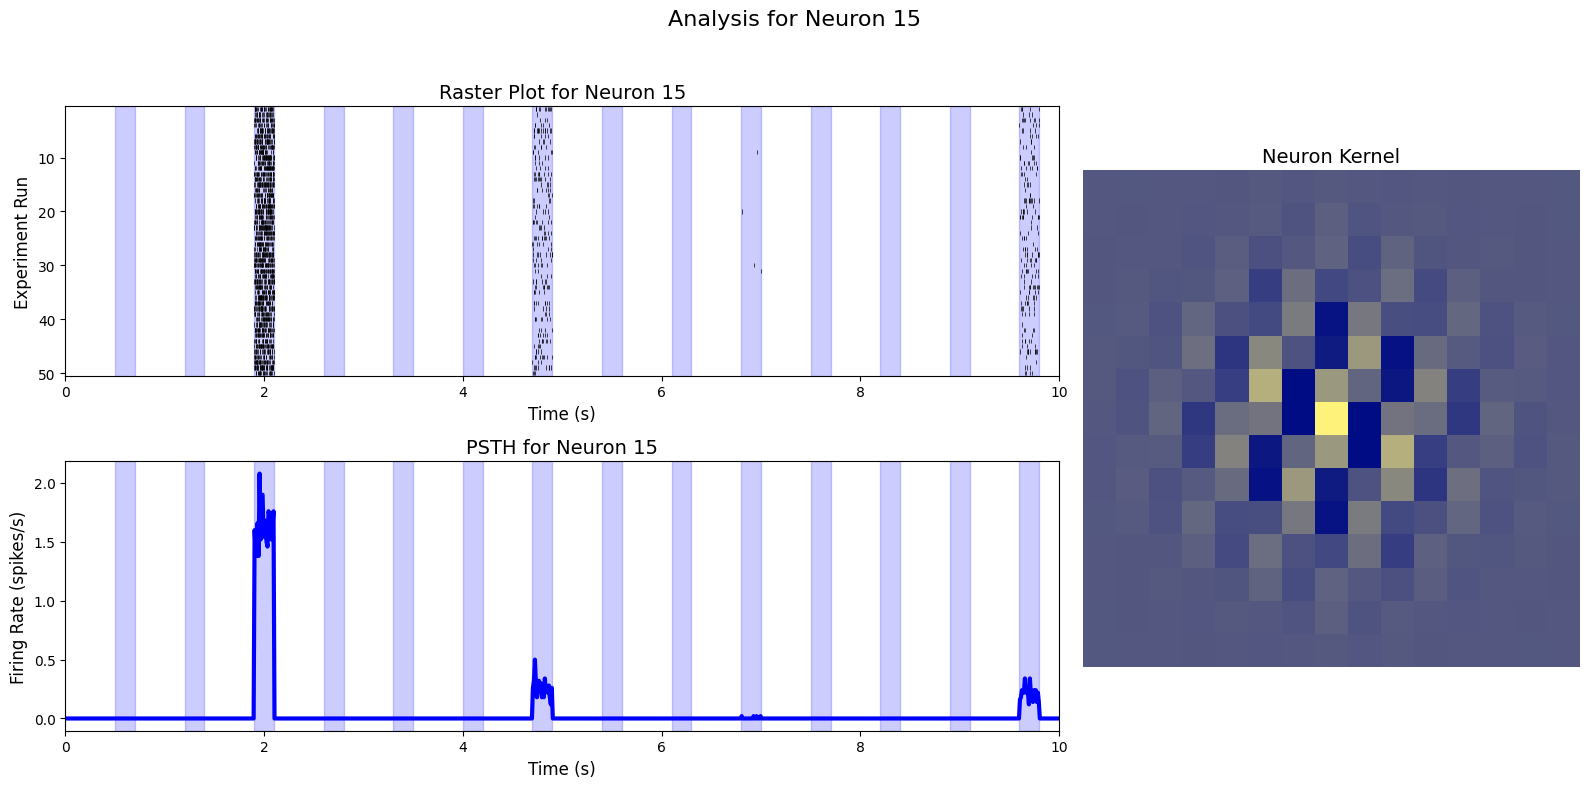

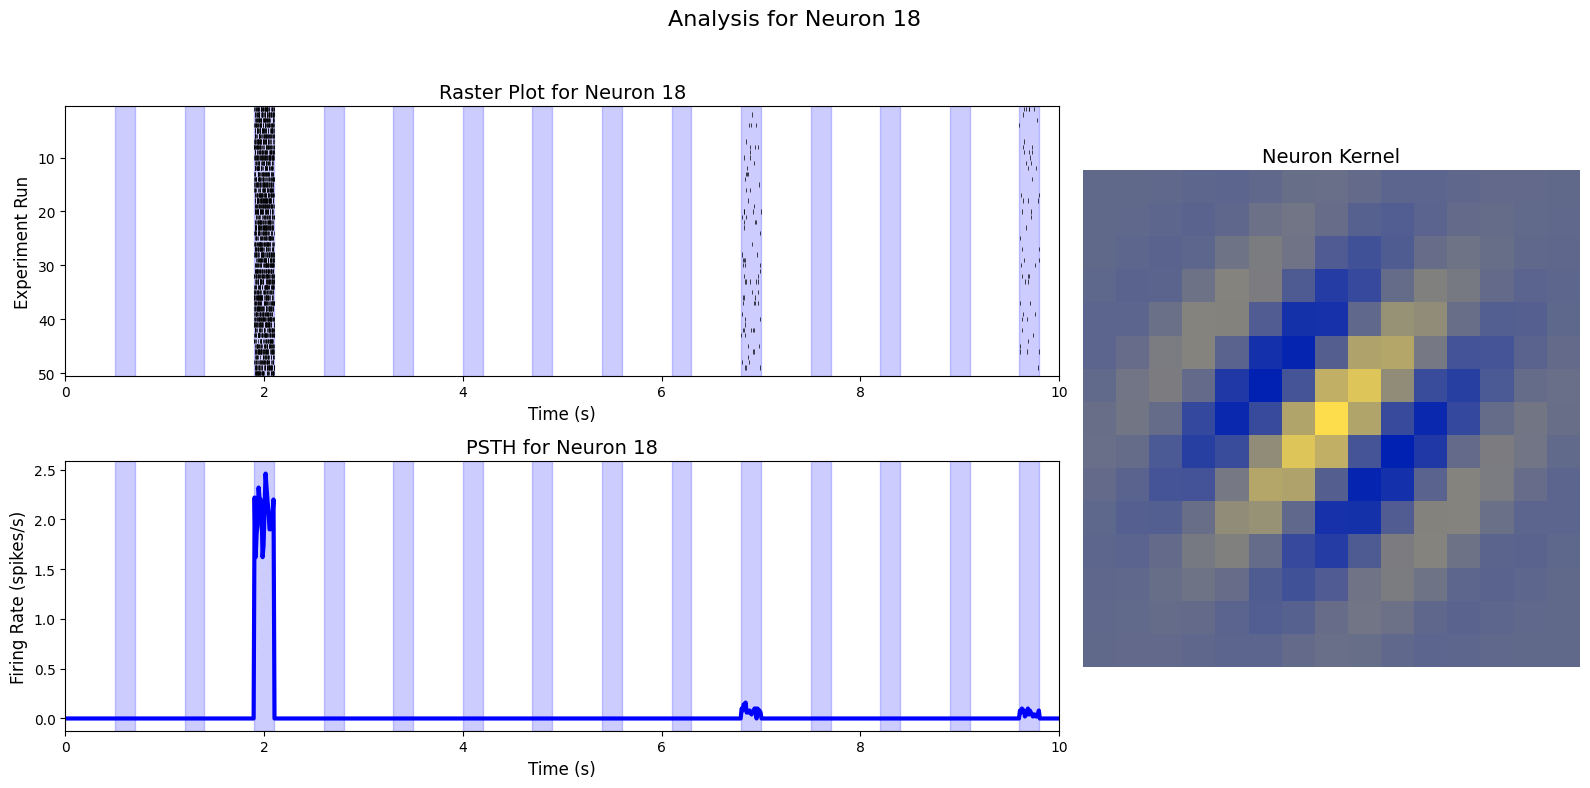

In [ ]:

# ---- Parameters ----
selected_neurons = [0, 3, 5, 10, 15, 18]  # List of neuron indices to analyze
bin_size = 10             # Original bin size for firing_rates (ms)
total_bins_10ms = 1000    # 10 seconds expressed in 10-ms bins
total_time_ms = total_bins_10ms * bin_size  # 10,000 ms = 10 s
num_runs = 50             # Number of experiment runs

# Trial structure (in ms)
initial_intertrial = 500   # Initial intertrial period: 500 ms
trial_time = 200           # Image (stimulus) period per trial: 200 ms
intertrial = 500           # Intertrial period per trial: 500 ms
trial_window = trial_time + intertrial  # 700 ms per trial
num_trials = 15            # Number of complete trials per run
# Extra intertrial at end to pad to 10 s:
extra_ms = total_time_ms - (initial_intertrial + num_trials * trial_window)

# ---- For Each Neuron, Generate Spike Trains & Plot ----
for selected_neuron in selected_neurons:
    # Prepare firing rate pattern for the selected neuron; use first 1000 10-ms bins.
    binned_rate = np.abs(firing_rates[:total_bins_10ms, selected_neuron])  # shape: (1000,)
    # Upsample to 1-ms resolution by repeating each 10-ms bin 10 times.
    rate_1ms = np.repeat(binned_rate, 10)  # shape: (10000,)
    # Assume constant rate within each 10-ms bin; probability per 1-ms time step:
    prob_1ms = rate_1ms / 10.0

    # ---- Generate Experiment Runs (1-ms resolution) ----
    experiment_runs = np.zeros((num_runs, total_time_ms), dtype=int)
    for run in range(num_runs):
        experiment_runs[run, :] = (np.random.rand(total_time_ms) < prob_1ms).astype(int)

    # ---- Compute PSTH (Rebin 1-ms spikes into 10-ms bins and convert to firing rate) ----
    psth_runs = experiment_runs.reshape(num_runs, total_bins_10ms, 10).sum(axis=2)  # shape: (num_runs, 1000)
    # Convert spike count per 10-ms bin to firing rate (spikes/s) by dividing by 0.01 s
    psth = psth_runs.mean(axis=0) #/ (bin_size / 1000.0)  # shape: (1000,)
    time_axis_psth = (np.arange(total_bins_10ms)*10 + 5) / 1000.0  # in seconds (using bin midpoints)

    # ---- Define Shading Intervals (Image Periods) ----
    shaded_intervals = []
    for i in range(1, num_trials+1):
        start_ms = initial_intertrial + (i-1)*trial_window
        end_ms = start_ms + trial_time
        shaded_intervals.append((start_ms/1000.0, end_ms/1000.0))

    # ---- Plot Figure with Three Subplots using GridSpec ----
    # Here we set the left column (raster & PSTH) to occupy 2/3 of the horizontal space,
    # and the right column (neuron kernel) to occupy 1/3.
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    ax_raster = fig.add_subplot(gs[0, 0])
    ax_psth = fig.add_subplot(gs[1, 0])
    ax_kernel = fig.add_subplot(gs[:, 1])

    # --- Raster Plot (Left Top) ---
    for run in range(num_runs):
        spike_indices = np.where(experiment_runs[run, :] == 1)[0]  # in ms
        spike_times = spike_indices / 1000.0
        ax_raster.vlines(spike_times, run+0.6, run+1.4, color='black', lw=0.5)
    for (start, end) in shaded_intervals:
        ax_raster.axvspan(start, end, color='blue', alpha=0.2)
    ax_raster.set_xlim(0, total_time_ms/1000.0)
    ax_raster.set_ylim(0.5, num_runs+0.5)
    ax_raster.set_xlabel("Time (s)", fontsize=12)
    ax_raster.set_ylabel("Experiment Run", fontsize=12)
    ax_raster.set_title(f"Raster Plot for Neuron {selected_neuron}", fontsize=14)
    ax_raster.invert_yaxis()  # Optional: run 1 on top

    # --- PSTH Plot (Left Bottom) ---
    ax_psth.plot(time_axis_psth, psth, color='blue', lw=3)
    for (start, end) in shaded_intervals:
        ax_psth.axvspan(start, end, color='blue', alpha=0.2)
    ax_psth.set_xlim(0, total_time_ms/1000.0)
    ax_psth.set_xlabel("Time (s)", fontsize=12)
    ax_psth.set_ylabel("Firing Rate (spikes/s)", fontsize=12)
    ax_psth.set_title(f"PSTH for Neuron {selected_neuron}", fontsize=14)

    # --- Neuron Kernel Plot (Right) ---
    # Retrieve the kernel from v1_cells (each element: (kernel_rgb, frequency, size, coords))
    kernel, freq, size, coords = v1_cells[selected_neuron]
    def norm_img(img):
        return (img - img.min()) / (img.max() - img.min() + 1e-10)
    ax_kernel.imshow(norm_img(kernel), interpolation='nearest')
    ax_kernel.set_title("Neuron Kernel", fontsize=14)
    ax_kernel.axis("off")

    plt.suptitle(f"Analysis for Neuron {selected_neuron}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Compute STA

In [ ]:
subset_images.min()

0.0

In [ ]:
import numpy as np

# ---- Parameters ----
bin_size = 10  # ms per bin
initial_intertrial = 500   # ms (50 bins)
trial_time = 200           # ms image period (20 bins)
intertrial = 500           # ms intertrial period (50 bins)
trial_window = trial_time + intertrial  # 700 ms per trial (70 bins)
num_trials = 1000          # Use 1000 image trials
total_time_ms = initial_intertrial + num_trials * trial_window
total_bins = total_time_ms // bin_size  # total number of 10-ms bins

# ---- Check Firing Rates Length ----
if firing_rates.shape[0] < total_bins:
    raise ValueError(f"Firing_rates has {firing_rates.shape[0]} bins, but {total_bins} bins are required for the experiment run.")

# ---- Build Stimulus Sequence at 10-ms Resolution ----
# Assume CIFAR-10 images are in subset_images (each shape: (32,32,3))
H, W, C = subset_images[0].shape  # expected (32,32,3)
gray_image = np.ones((H, W, C), dtype=np.float32) * 0.5
# Use the first num_trials images for the trials. If not enough, tile them.
if subset_images.shape[0] < num_trials:
    repeats = int(np.ceil(num_trials / subset_images.shape[0]))
    selected_trial_images = np.tile(subset_images, (repeats, 1, 1, 1))[:num_trials]
else:
    selected_trial_images = subset_images[:num_trials]

temporal_inputs = []
# Initial intertrial period (50 bins)
for _ in range(initial_intertrial // bin_size):
    temporal_inputs.append(gray_image)
# For each trial: 20 bins of image followed by 50 bins of gray
for i in range(num_trials):
    for _ in range(trial_time // bin_size):
        temporal_inputs.append(selected_trial_images[i])
    for _ in range(intertrial // bin_size):
        temporal_inputs.append(gray_image)
temporal_inputs = np.array(temporal_inputs)
assert temporal_inputs.shape[0] == total_bins, f"Temporal inputs length {temporal_inputs.shape[0]} does not match expected {total_bins}"

# ---- Standardize the Stimulus Frames (Z-score) ----
def zscore_img(img):
    mu = img.mean()
    sigma = img.std() if img.std() > 0 else 1.0
    return (img - mu) / sigma

# Compute z-score for each 10-ms stimulus frame
stimulus_z = np.array([zscore_img(frame) for frame in temporal_inputs])
print("Standardized stimulus shape:", stimulus_z.shape)  # (total_bins, H, W, C)

# ---- Compute STA for Selected Neurons ----
# Assume firing_rates is defined with shape (total_bins, num_neurons)
# Assume v1_cells is defined: list of tuples (kernel_rgb, frequency, size, coords)
selected_neurons = np.arange(20)  # or any list of neuron indices to analyze
sta_results = {}  # dictionary to store STA results for each neuron

for neuron in selected_neurons:
    # Use exactly total_bins 10-ms bins from firing_rates for the neuron (absolute value)
    binned_rate = np.abs(firing_rates[:total_bins, neuron])  # shape: (total_bins,)
    total_weight = binned_rate.sum()

    if total_weight > 0:
        sta = np.sum(binned_rate[:, None, None, None] * stimulus_z, axis=0) / total_weight
    else:
        sta = np.zeros((H, W, C), dtype=np.float32)

    sta_results[neuron] = sta


Standardized stimulus shape: (70050, 32, 32, 3)


# Visualize STA, Cropped STA, and Original Kernel

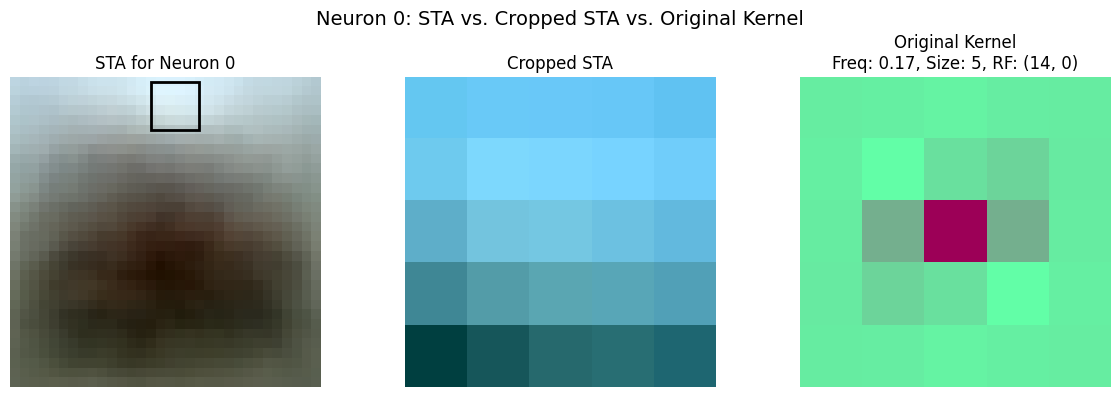

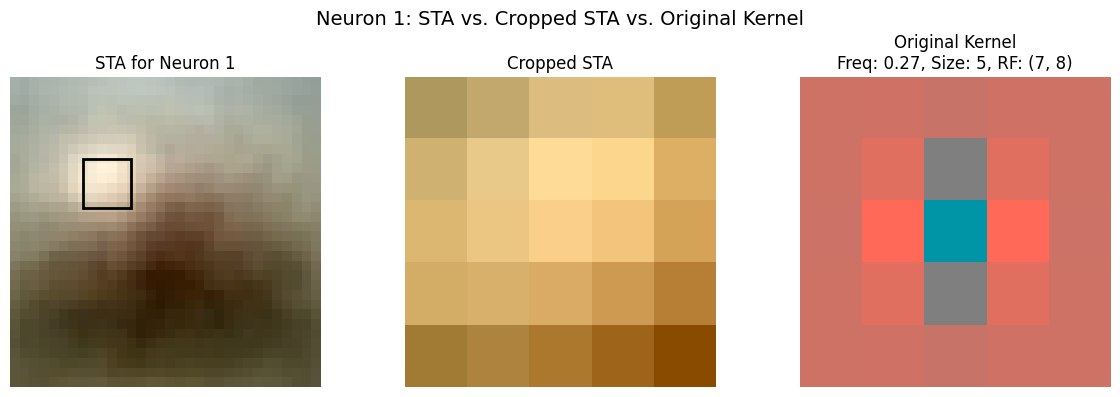

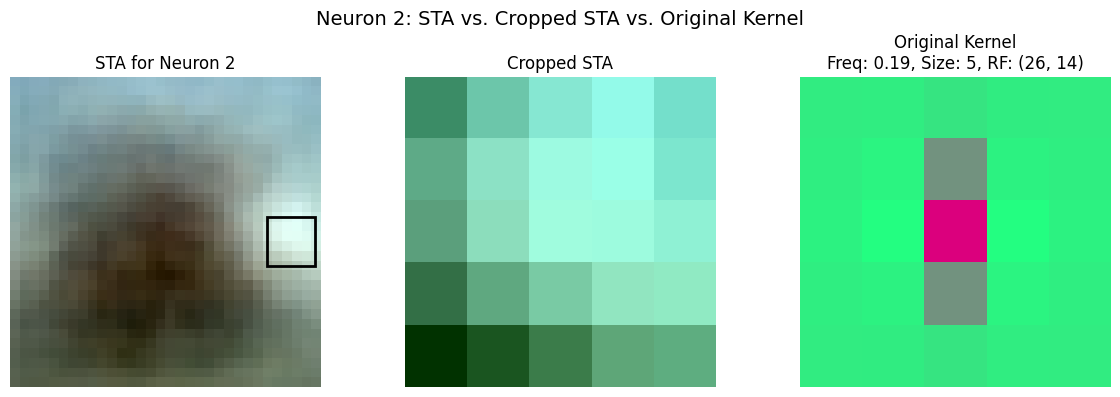

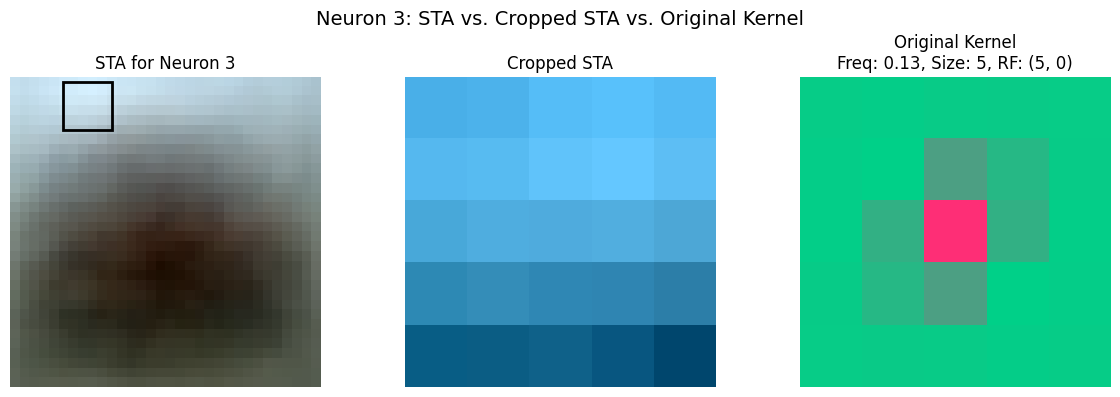

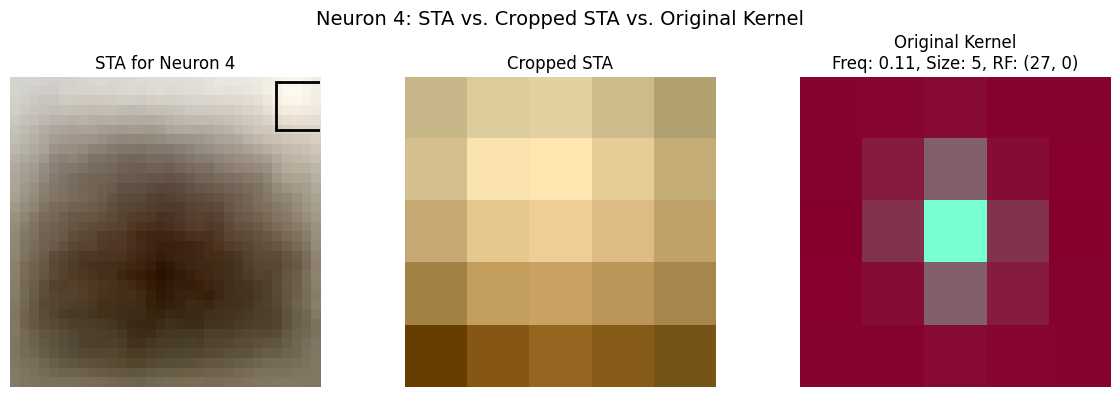

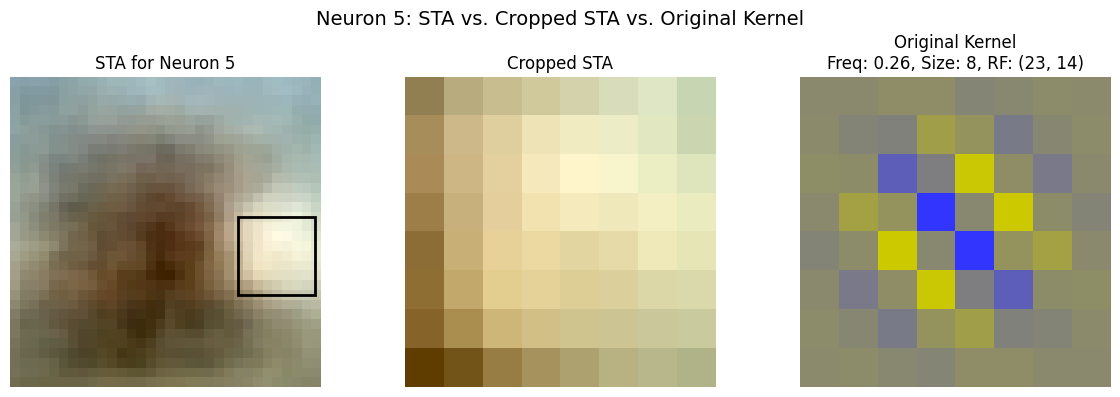

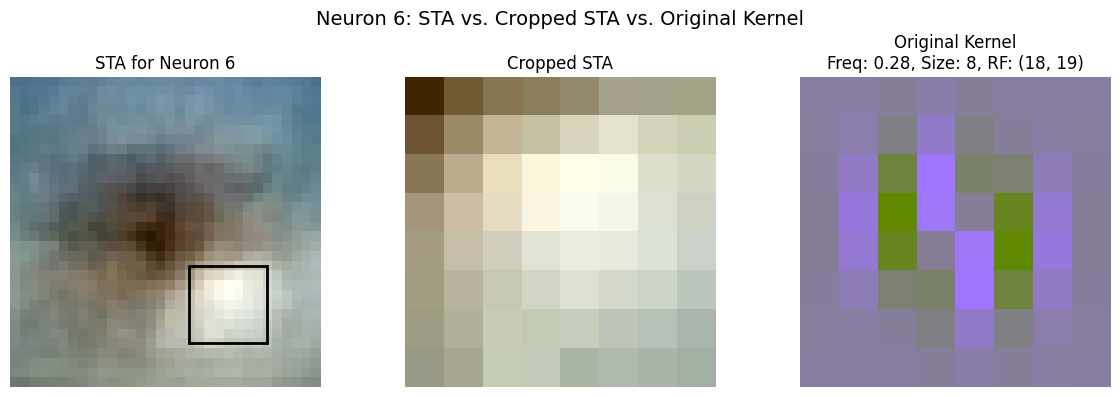

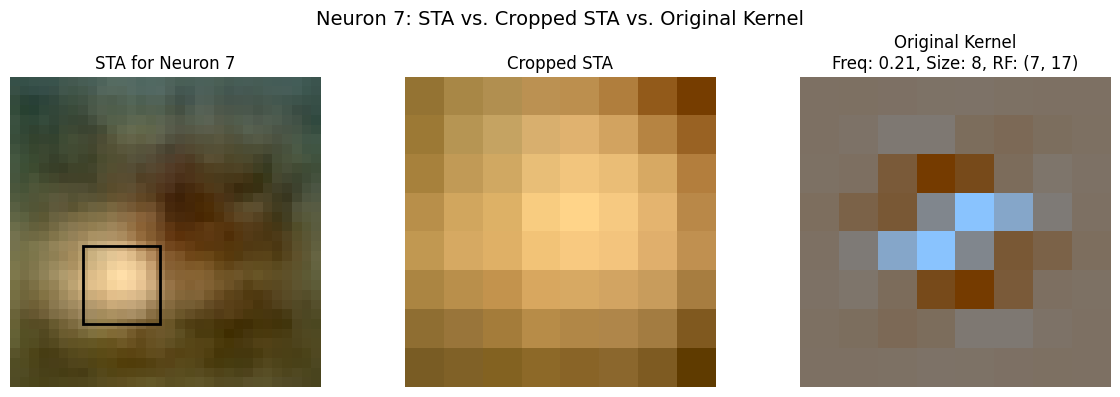

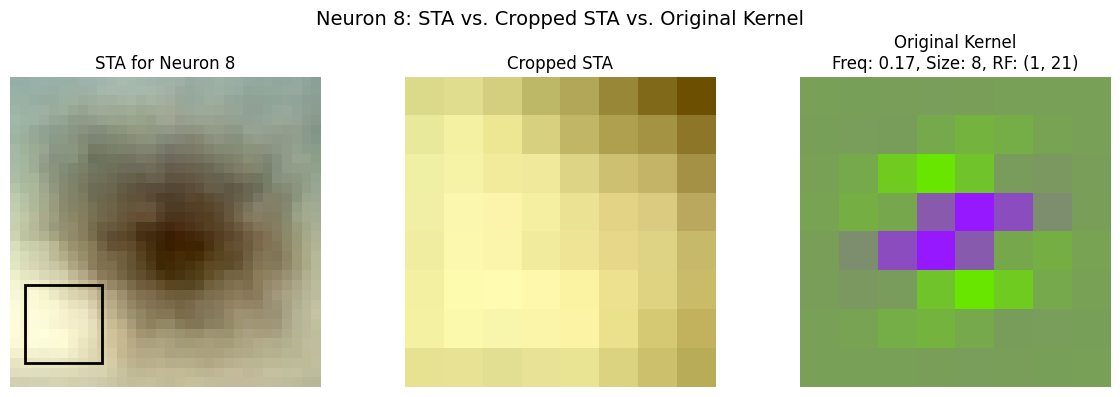

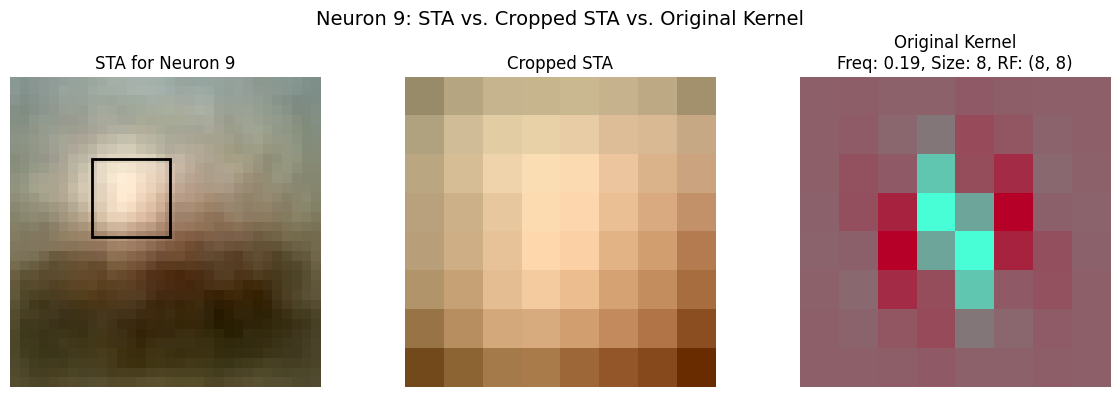

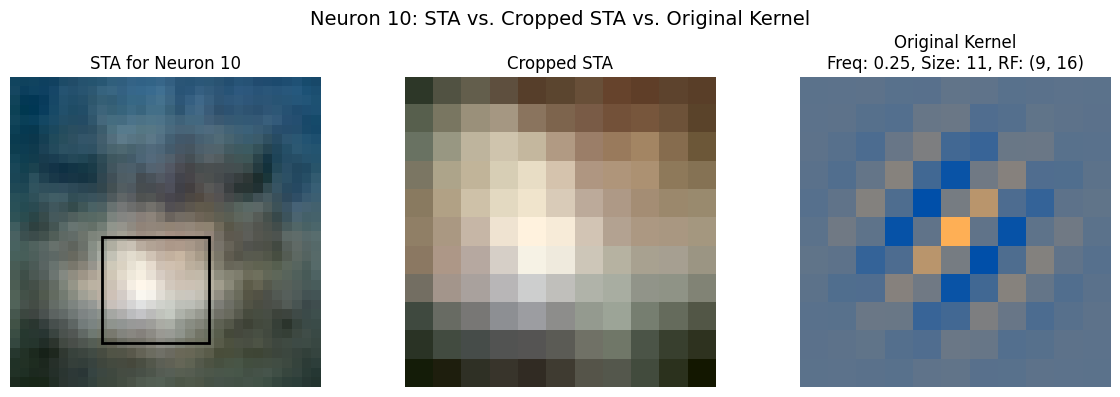

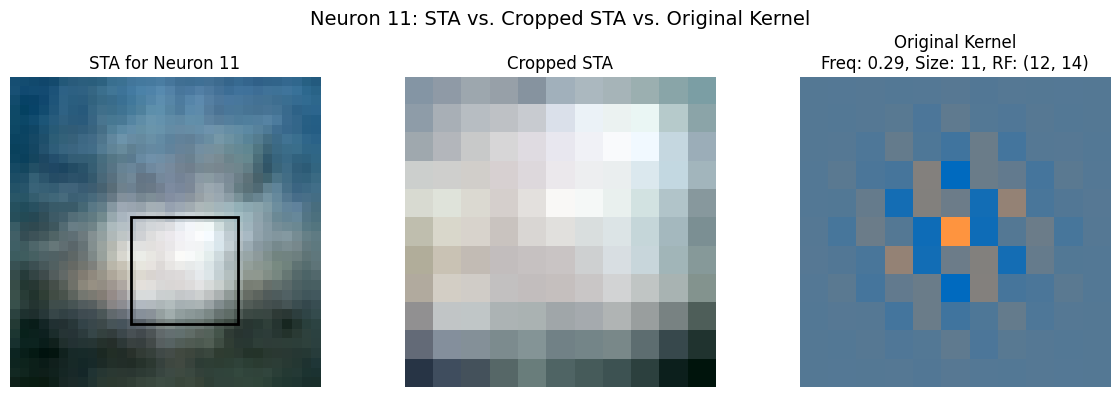

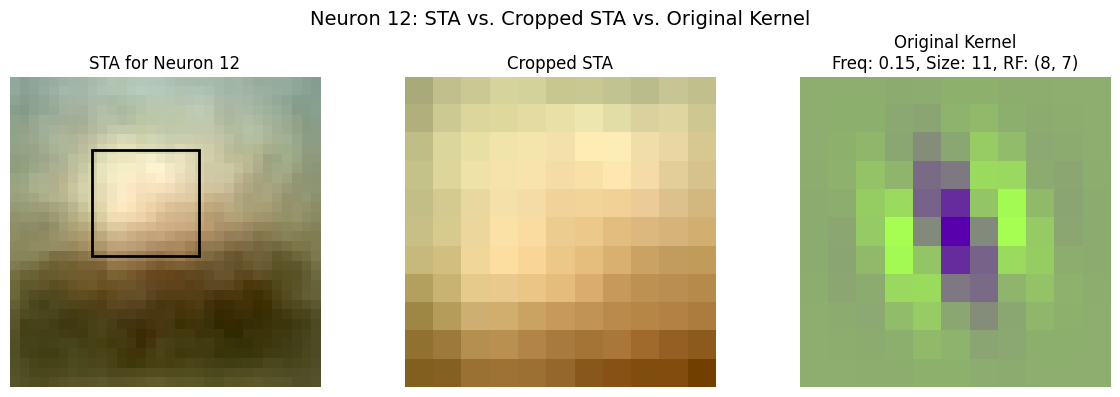

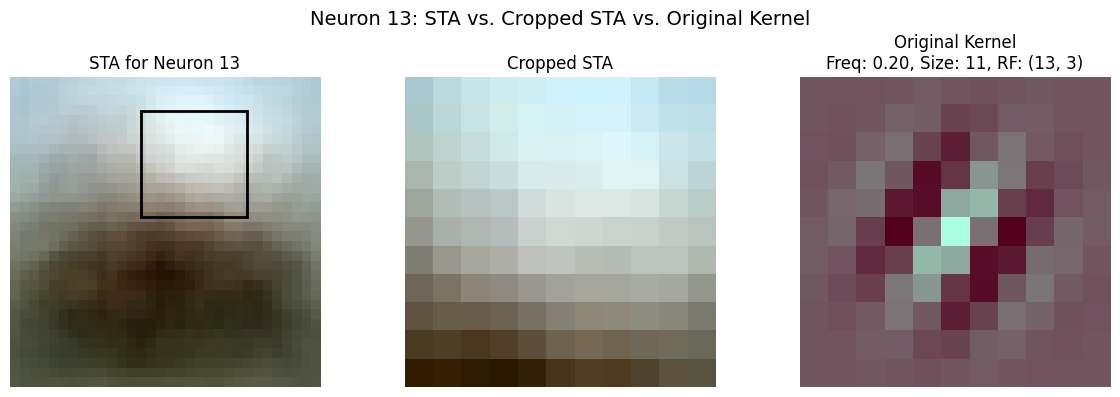

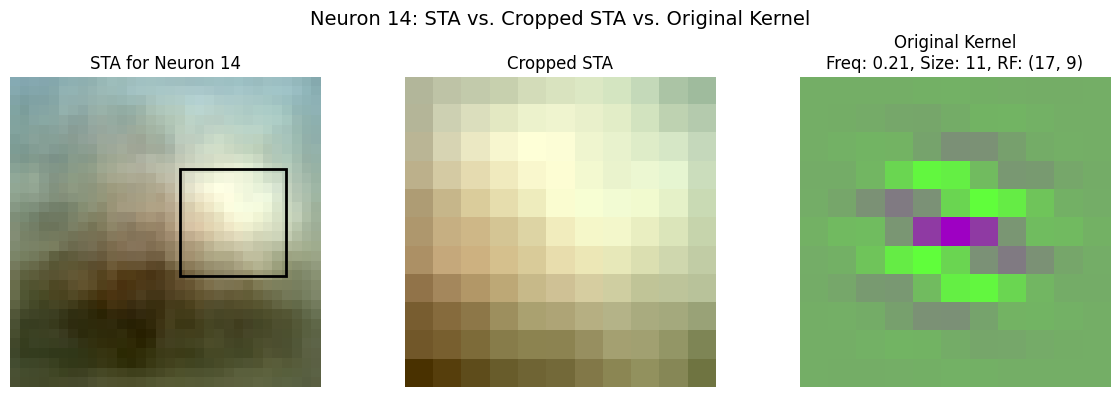

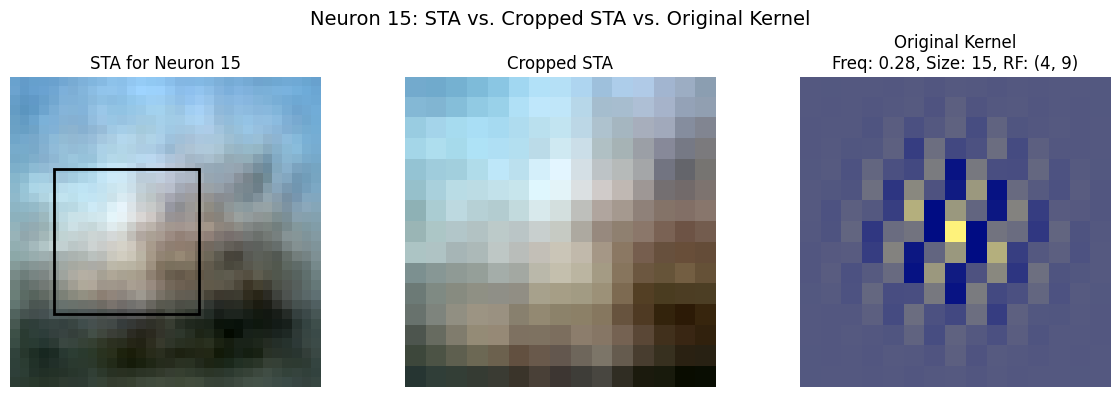

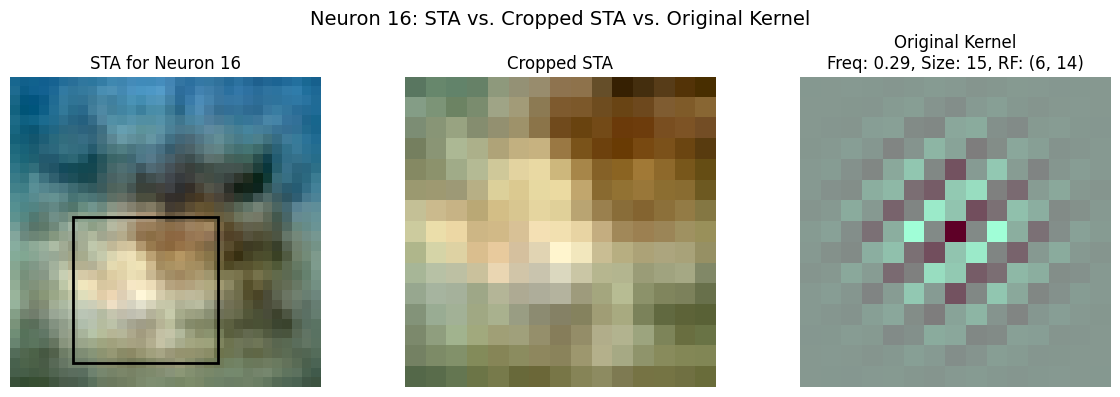

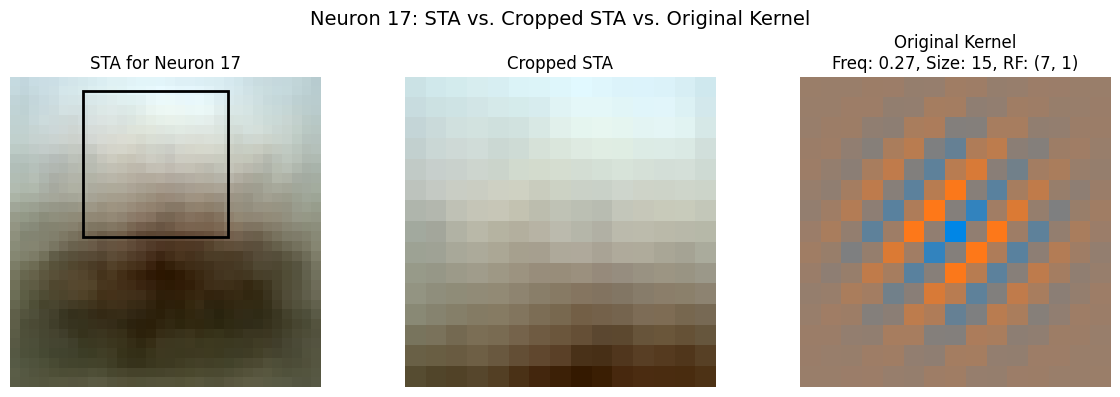

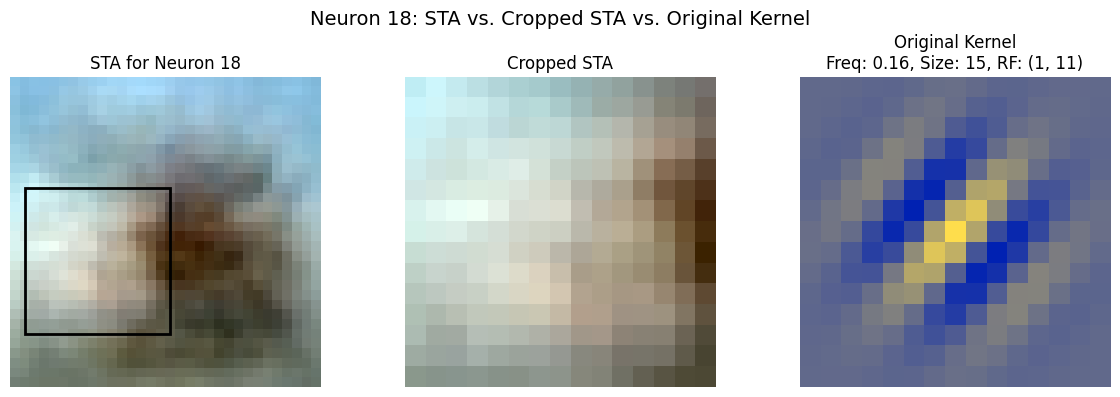

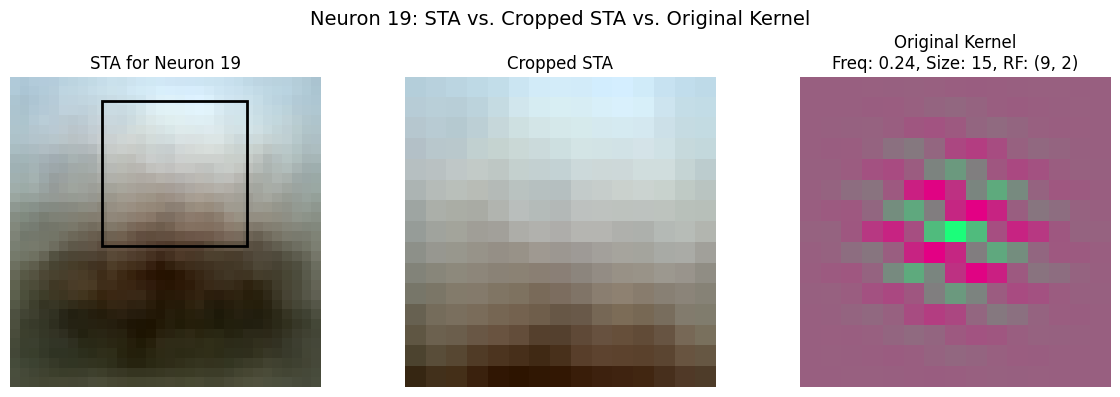

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def norm_img(img):
    """Normalize an image to [0,1] for display."""
    return (img - img.min()) / (img.max() - img.min() + 1e-10)

# For each selected neuron, display three subplots: Full STA (with RF box), Cropped STA, and Original Kernel.
for neuron in selected_neurons:
    # Retrieve STA (computed in Block 1) for this neuron.
    sta = sta_results[neuron]
    # Retrieve original neuron kernel info from v1_cells: (kernel_rgb, frequency, size, coords)
    kernel, freq, size, coords = v1_cells[neuron]

    # Crop the STA to the RF region.
    # Note: In image arrays, axis 0 is vertical (y) and axis 1 is horizontal (x).
    cropped_sta = sta[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

    # Create a figure with 3 side-by-side subplots.
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Subplot 1: Full STA with RF box overlay.
    axs[0].imshow(norm_img(sta), interpolation='nearest')
    axs[0].set_title(f"STA for Neuron {neuron}", fontsize=12)
    axs[0].axis("off")
    # Draw a black rectangle indicating the RF region.
    rect = Rectangle((coords[0], coords[1]), size, size,
                     edgecolor='black', facecolor='none', lw=2)
    axs[0].add_patch(rect)

    # Subplot 2: Cropped STA (only pixels within the RF).
    axs[1].imshow(norm_img(cropped_sta), interpolation='nearest')
    axs[1].set_title("Cropped STA", fontsize=12)
    axs[1].axis("off")

    # Subplot 3: Original Neuron Kernel with annotation.
    annotation = f"Freq: {freq:.2f}, Size: {size}, RF: {coords}"
    axs[2].imshow(norm_img(kernel), interpolation='nearest')
    axs[2].set_title("Original Kernel\n" + annotation, fontsize=12)
    axs[2].axis("off")

    plt.suptitle(f"Neuron {neuron}: STA vs. Cropped STA vs. Original Kernel", fontsize=14)
    plt.tight_layout()
    plt.show()


<ipython-input-62-a043f1ce9230>:151: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(complex_sum) / np.sum(tuning_curve)


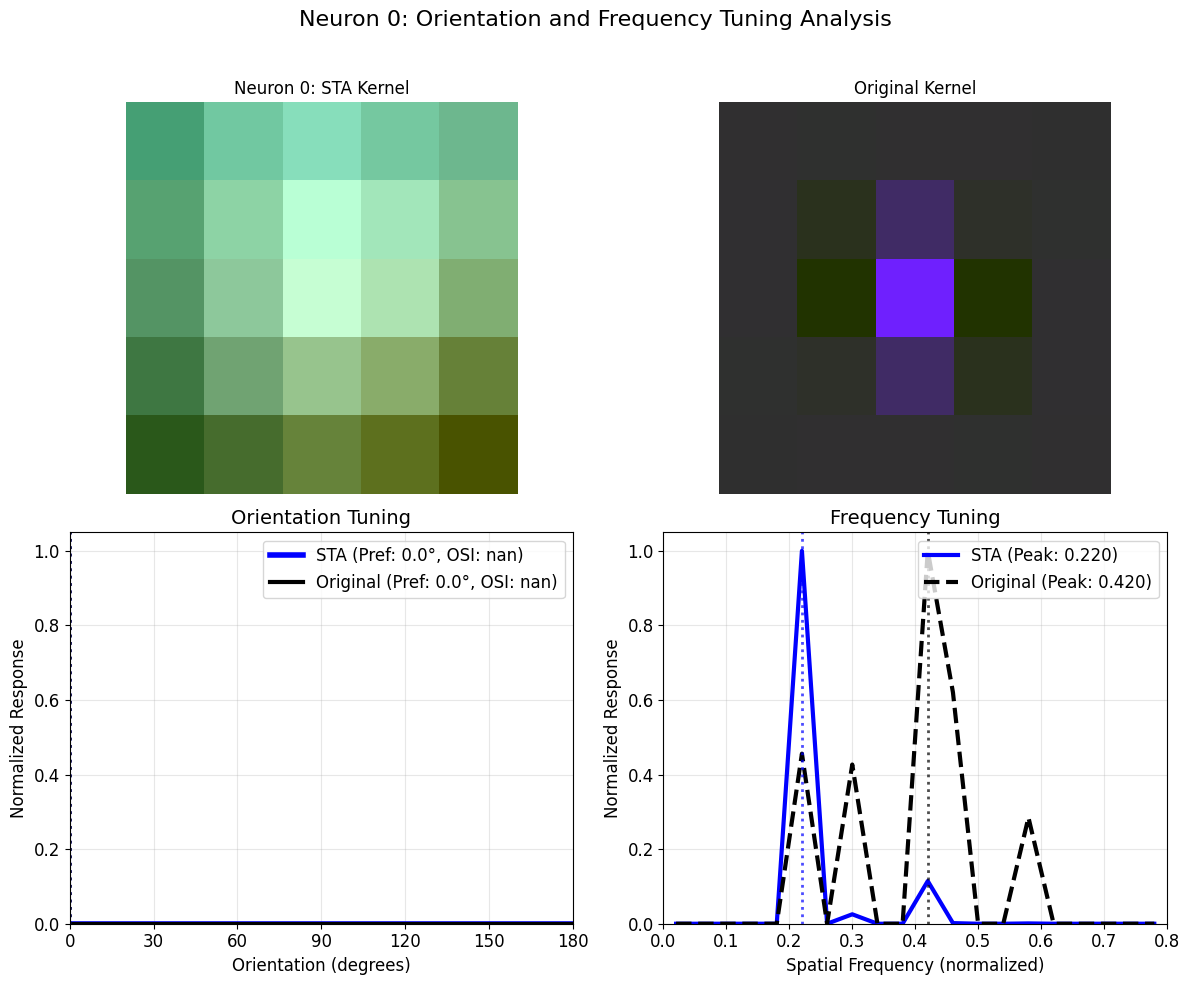


Neuron 0 Tuning Analysis Summary:
  STA Preferred Orientation: 0.0° (OSI: nan)
  Original Kernel Orientation: 0.0° (OSI: nan)
  STA Peak Frequency: 0.220
  Original Kernel Frequency: 0.420 (Ground truth: 0.282)
  Orientation Error: 0.0°
  Frequency Error: 0.200


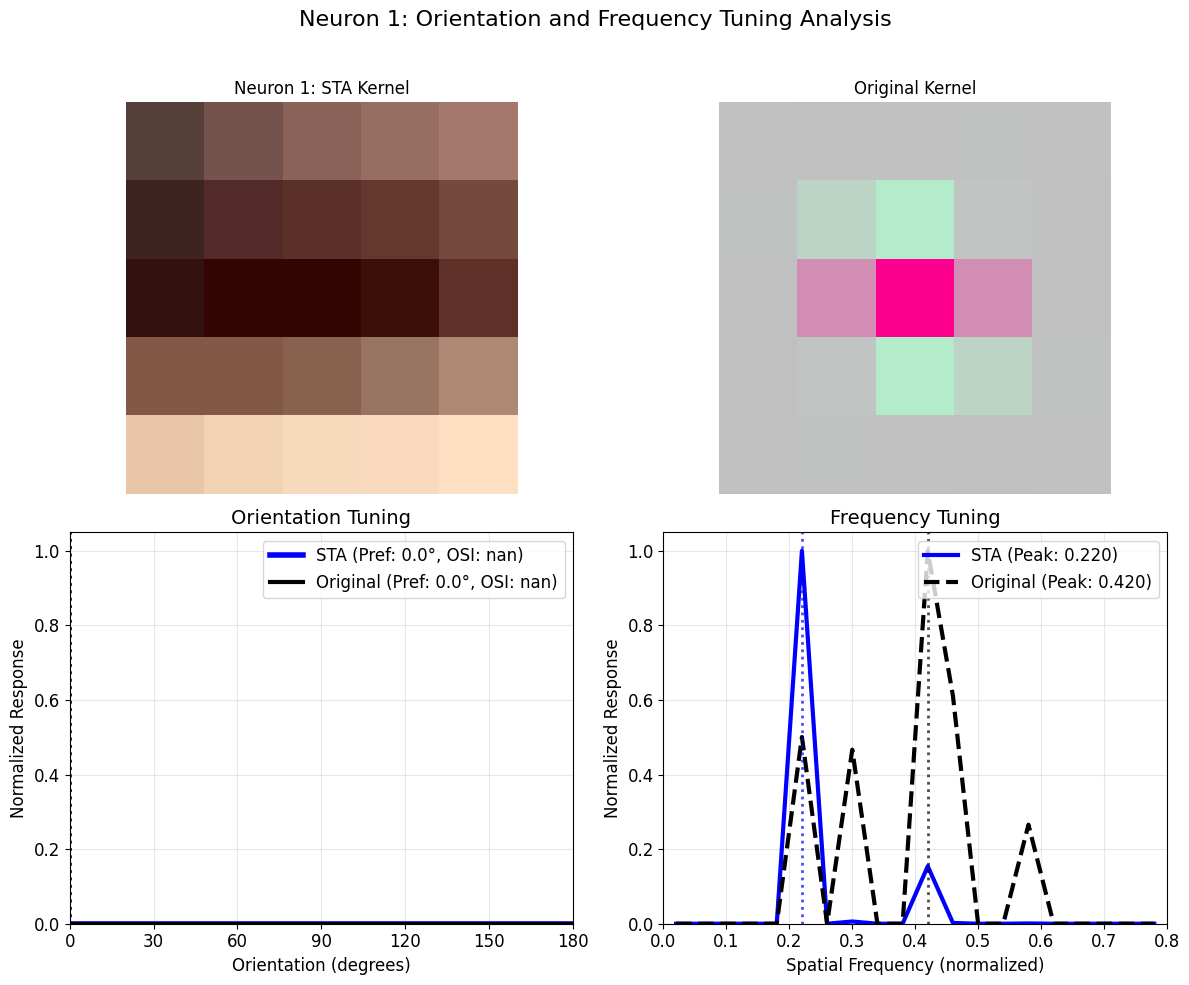


Neuron 1 Tuning Analysis Summary:
  STA Preferred Orientation: 0.0° (OSI: nan)
  Original Kernel Orientation: 0.0° (OSI: nan)
  STA Peak Frequency: 0.220
  Original Kernel Frequency: 0.420 (Ground truth: 0.262)
  Orientation Error: 0.0°
  Frequency Error: 0.200


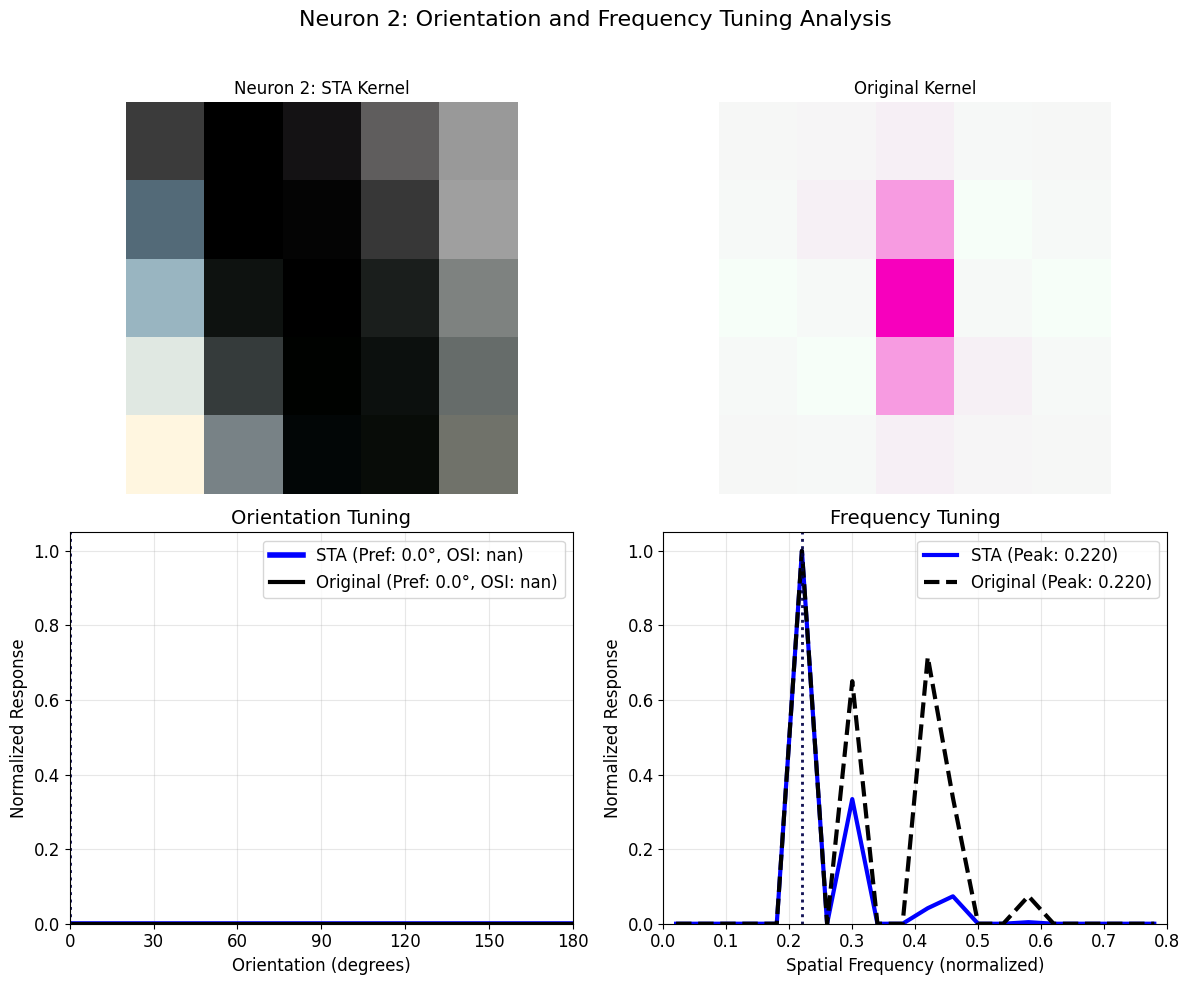


Neuron 2 Tuning Analysis Summary:
  STA Preferred Orientation: 0.0° (OSI: nan)
  Original Kernel Orientation: 0.0° (OSI: nan)
  STA Peak Frequency: 0.220
  Original Kernel Frequency: 0.220 (Ground truth: 0.165)
  Orientation Error: 0.0°
  Frequency Error: 0.000


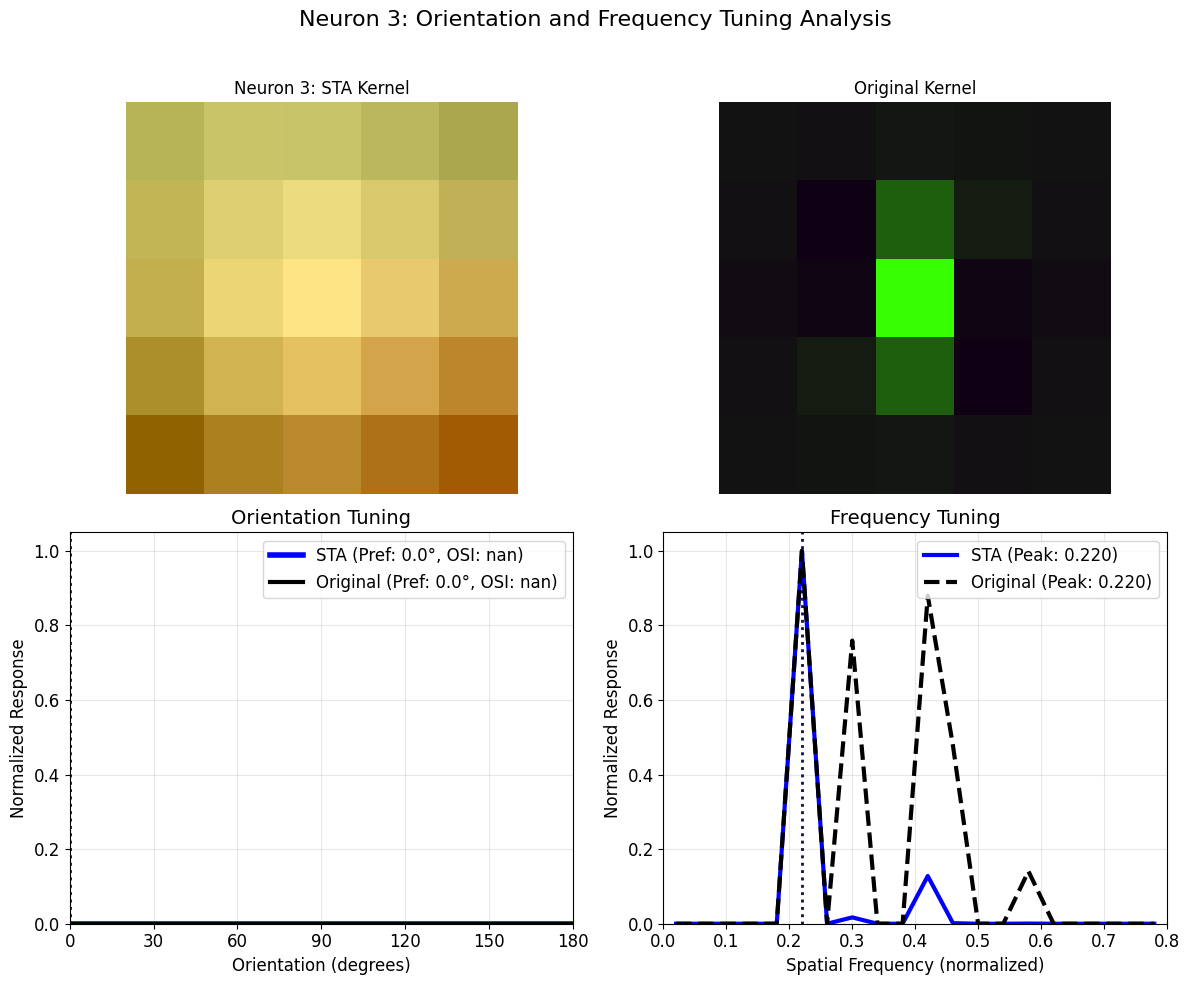


Neuron 3 Tuning Analysis Summary:
  STA Preferred Orientation: 0.0° (OSI: nan)
  Original Kernel Orientation: 0.0° (OSI: nan)
  STA Peak Frequency: 0.220
  Original Kernel Frequency: 0.220 (Ground truth: 0.185)
  Orientation Error: 0.0°
  Frequency Error: 0.000


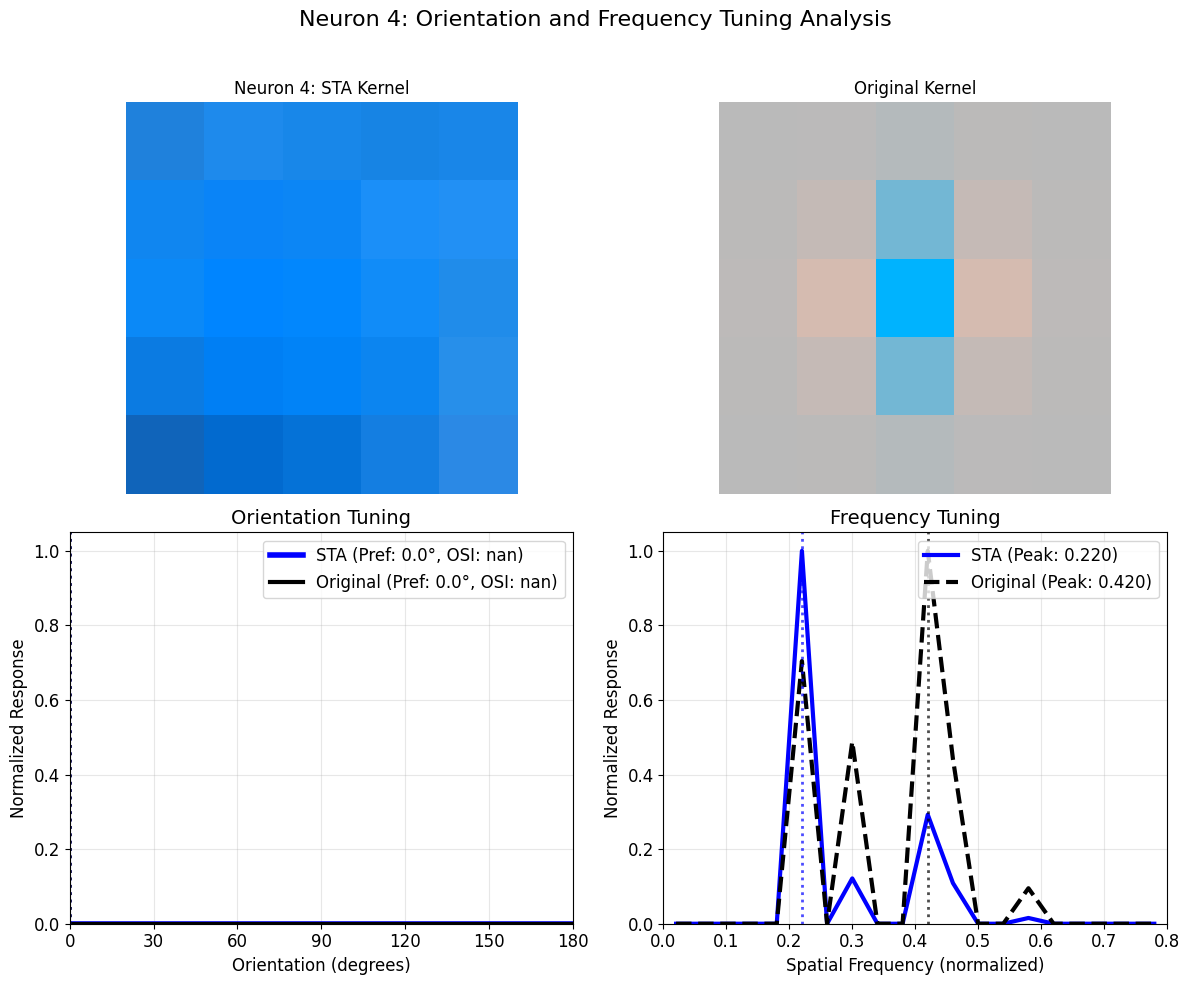


Neuron 4 Tuning Analysis Summary:
  STA Preferred Orientation: 0.0° (OSI: nan)
  Original Kernel Orientation: 0.0° (OSI: nan)
  STA Peak Frequency: 0.220
  Original Kernel Frequency: 0.420 (Ground truth: 0.211)
  Orientation Error: 0.0°
  Frequency Error: 0.200


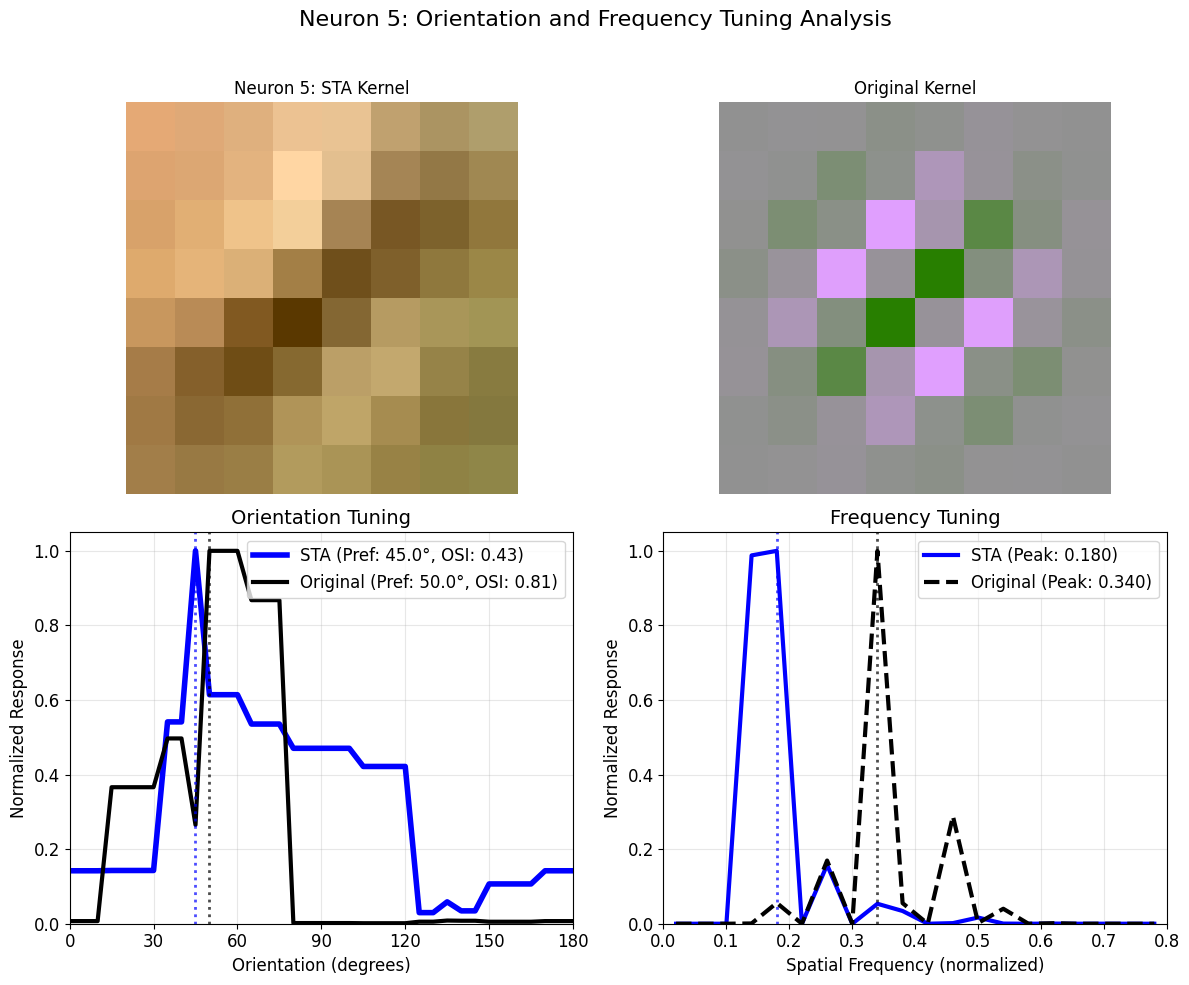


Neuron 5 Tuning Analysis Summary:
  STA Preferred Orientation: 45.0° (OSI: 0.43)
  Original Kernel Orientation: 50.0° (OSI: 0.81)
  STA Peak Frequency: 0.180
  Original Kernel Frequency: 0.340 (Ground truth: 0.269)
  Orientation Error: 5.0°
  Frequency Error: 0.160


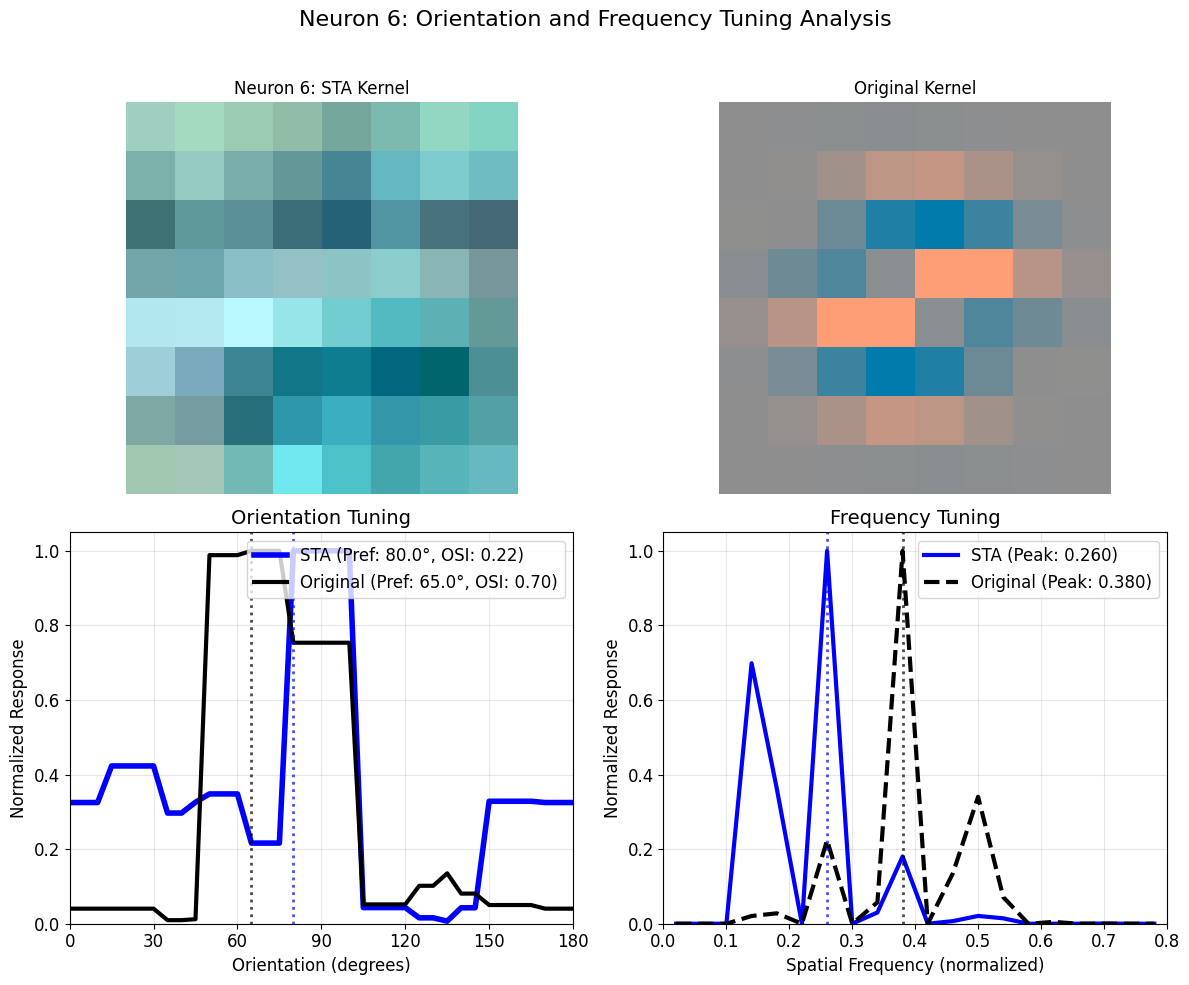


Neuron 6 Tuning Analysis Summary:
  STA Preferred Orientation: 80.0° (OSI: 0.22)
  Original Kernel Orientation: 65.0° (OSI: 0.70)
  STA Peak Frequency: 0.260
  Original Kernel Frequency: 0.380 (Ground truth: 0.267)
  Orientation Error: 15.0°
  Frequency Error: 0.120


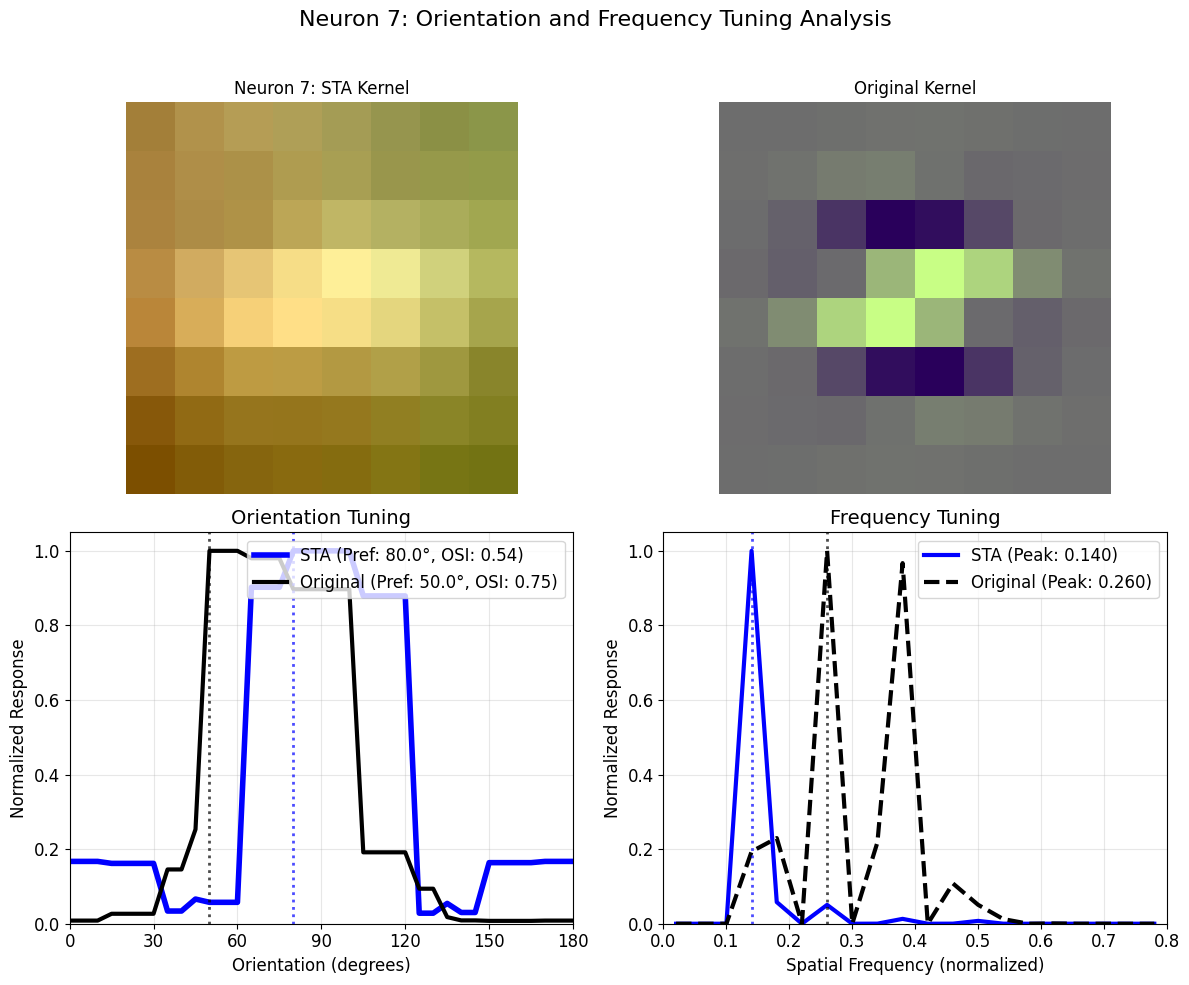


Neuron 7 Tuning Analysis Summary:
  STA Preferred Orientation: 80.0° (OSI: 0.54)
  Original Kernel Orientation: 50.0° (OSI: 0.75)
  STA Peak Frequency: 0.140
  Original Kernel Frequency: 0.260 (Ground truth: 0.203)
  Orientation Error: 30.0°
  Frequency Error: 0.120


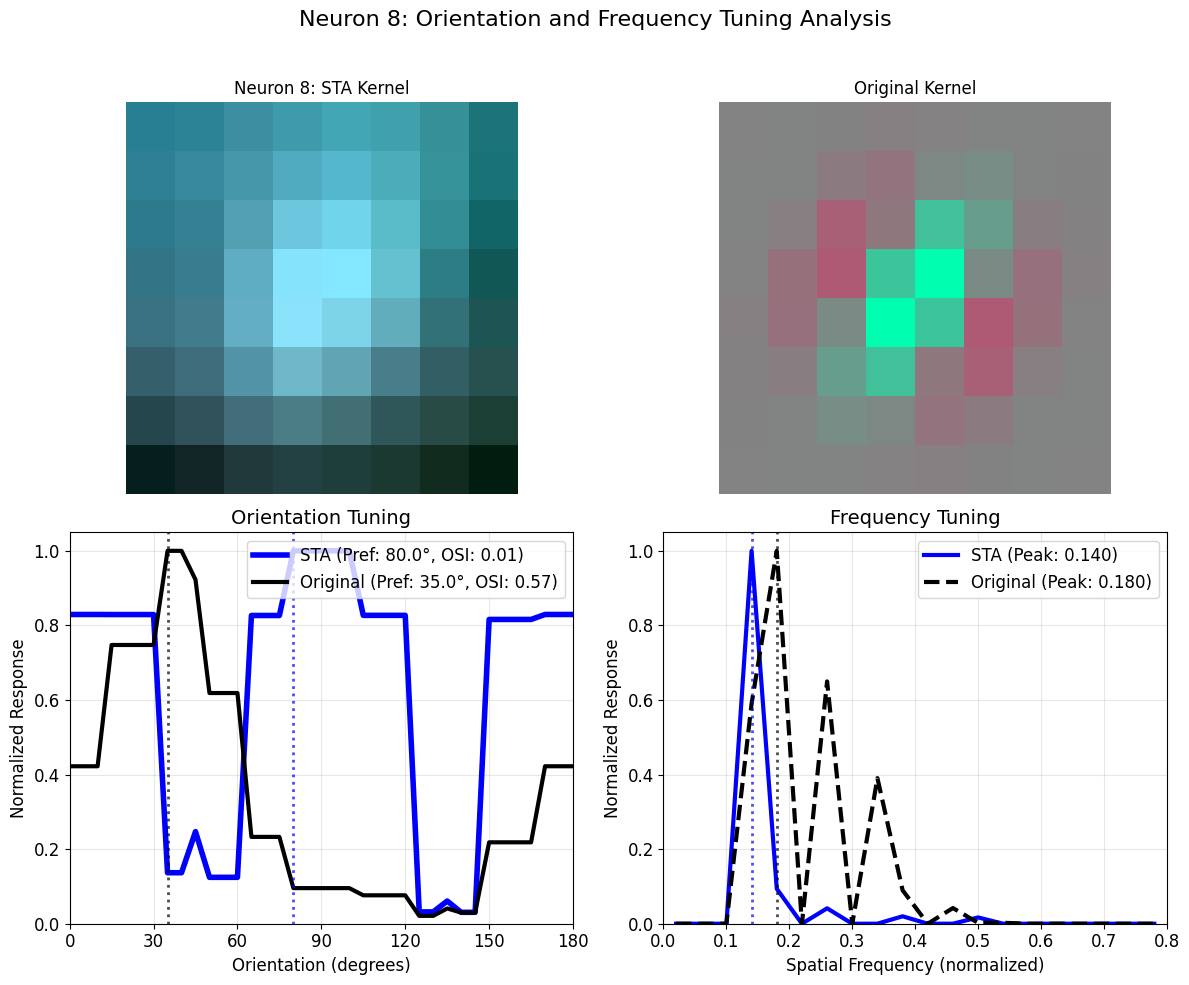


Neuron 8 Tuning Analysis Summary:
  STA Preferred Orientation: 80.0° (OSI: 0.01)
  Original Kernel Orientation: 35.0° (OSI: 0.57)
  STA Peak Frequency: 0.140
  Original Kernel Frequency: 0.180 (Ground truth: 0.149)
  Orientation Error: 45.0°
  Frequency Error: 0.040


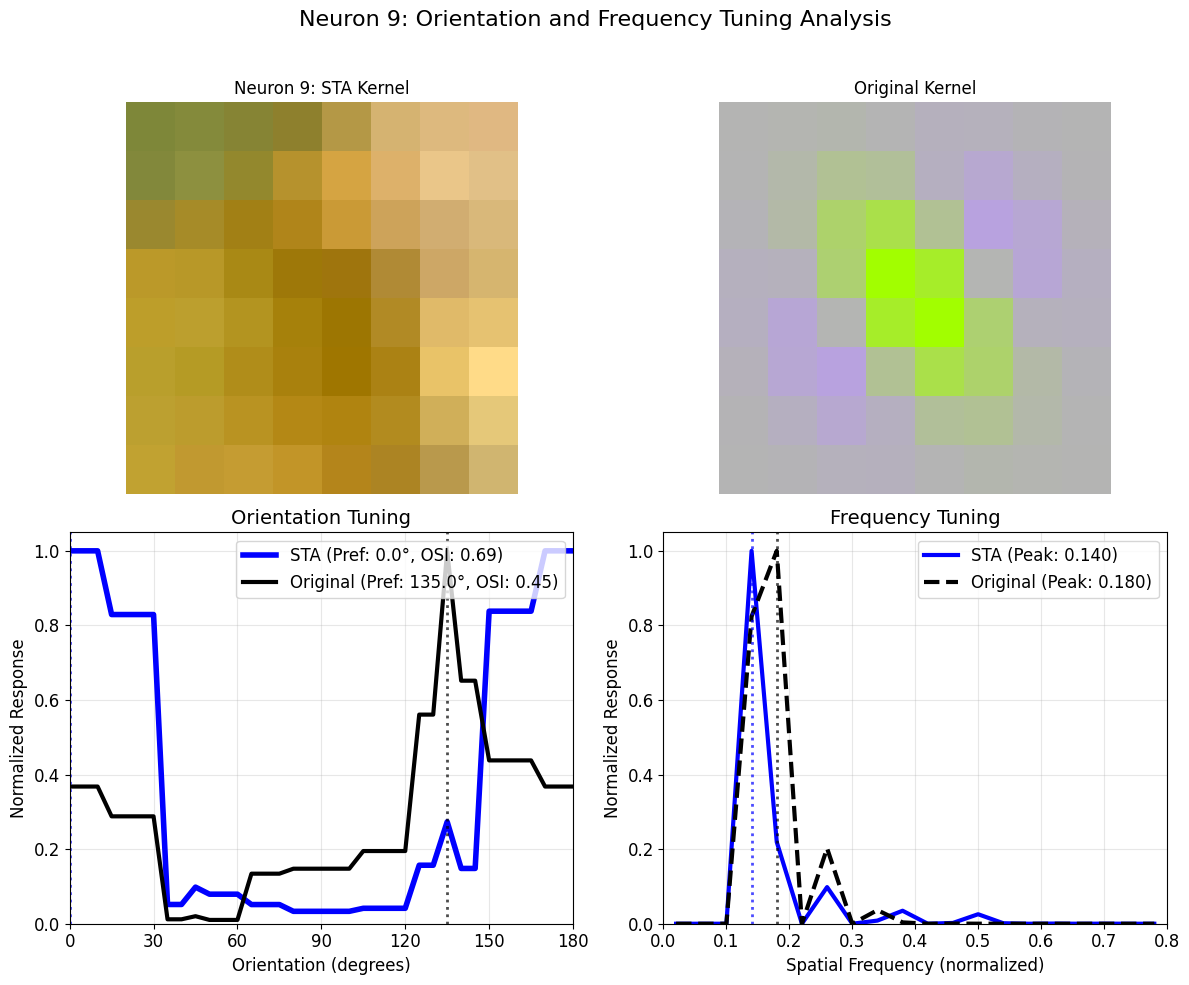


Neuron 9 Tuning Analysis Summary:
  STA Preferred Orientation: 0.0° (OSI: 0.69)
  Original Kernel Orientation: 135.0° (OSI: 0.45)
  STA Peak Frequency: 0.140
  Original Kernel Frequency: 0.180 (Ground truth: 0.121)
  Orientation Error: 45.0°
  Frequency Error: 0.040


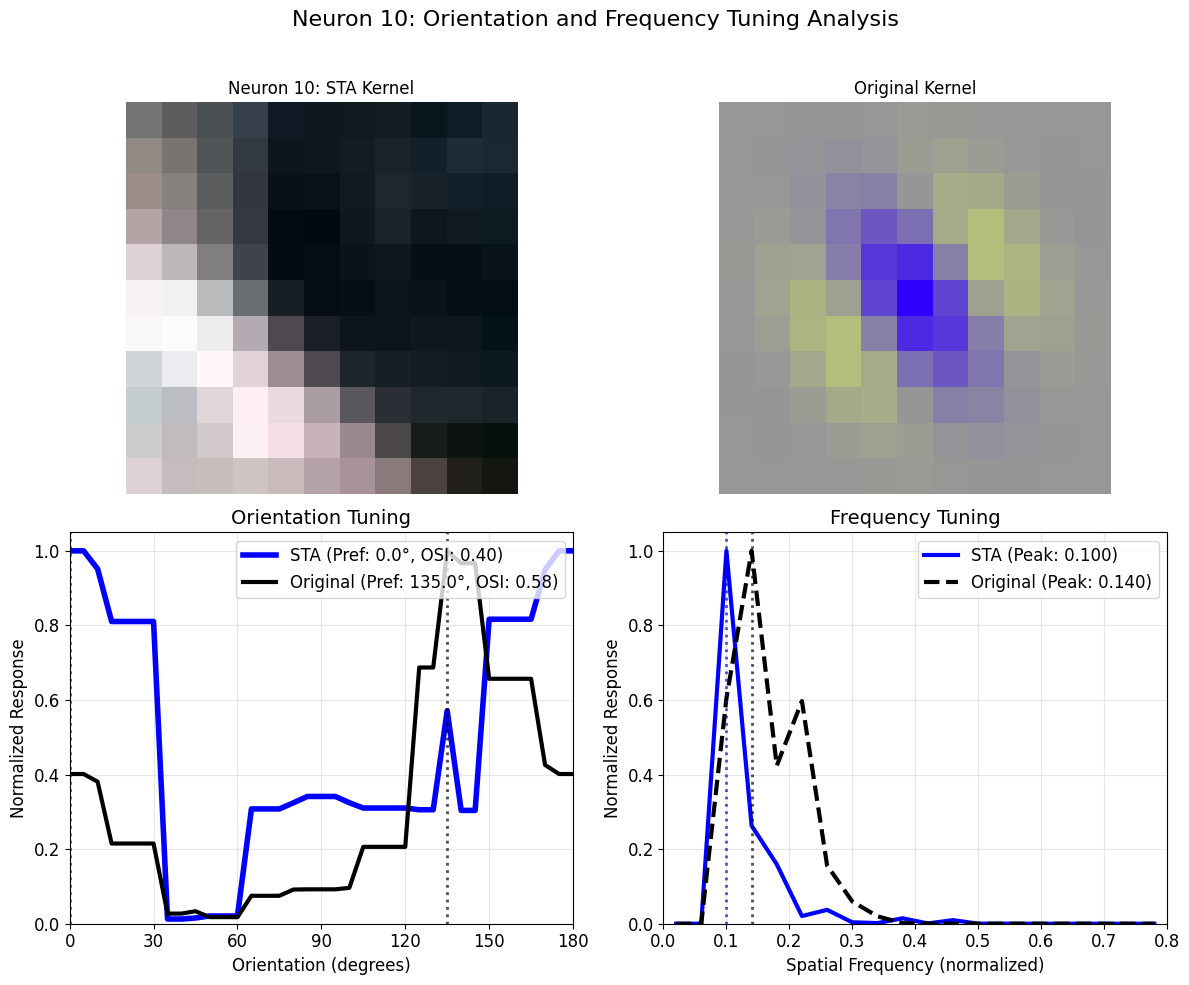


Neuron 10 Tuning Analysis Summary:
  STA Preferred Orientation: 0.0° (OSI: 0.40)
  Original Kernel Orientation: 135.0° (OSI: 0.58)
  STA Peak Frequency: 0.100
  Original Kernel Frequency: 0.140 (Ground truth: 0.104)
  Orientation Error: 45.0°
  Frequency Error: 0.040


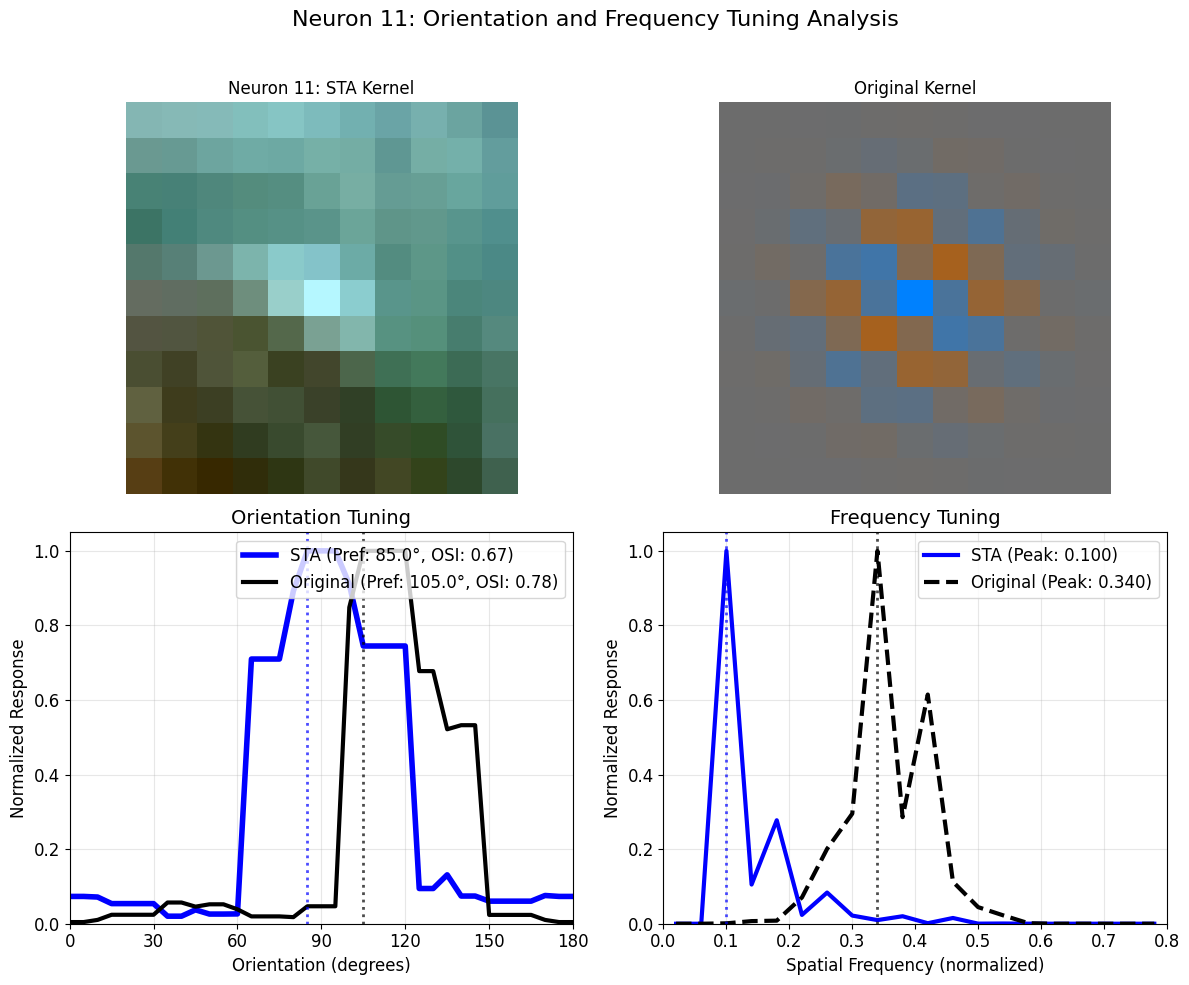


Neuron 11 Tuning Analysis Summary:
  STA Preferred Orientation: 85.0° (OSI: 0.67)
  Original Kernel Orientation: 105.0° (OSI: 0.78)
  STA Peak Frequency: 0.100
  Original Kernel Frequency: 0.340 (Ground truth: 0.234)
  Orientation Error: 20.0°
  Frequency Error: 0.240


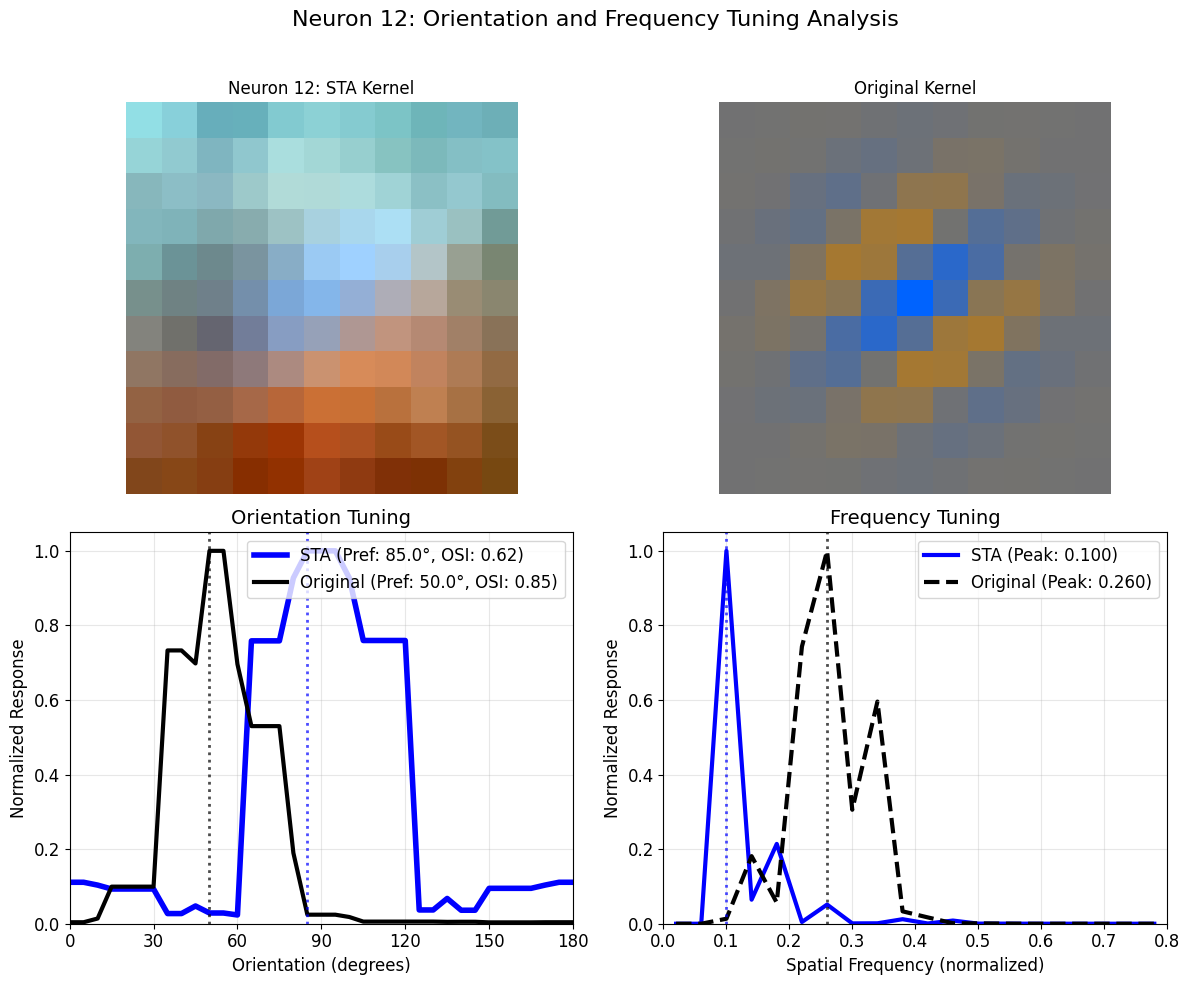


Neuron 12 Tuning Analysis Summary:
  STA Preferred Orientation: 85.0° (OSI: 0.62)
  Original Kernel Orientation: 50.0° (OSI: 0.85)
  STA Peak Frequency: 0.100
  Original Kernel Frequency: 0.260 (Ground truth: 0.191)
  Orientation Error: 35.0°
  Frequency Error: 0.160


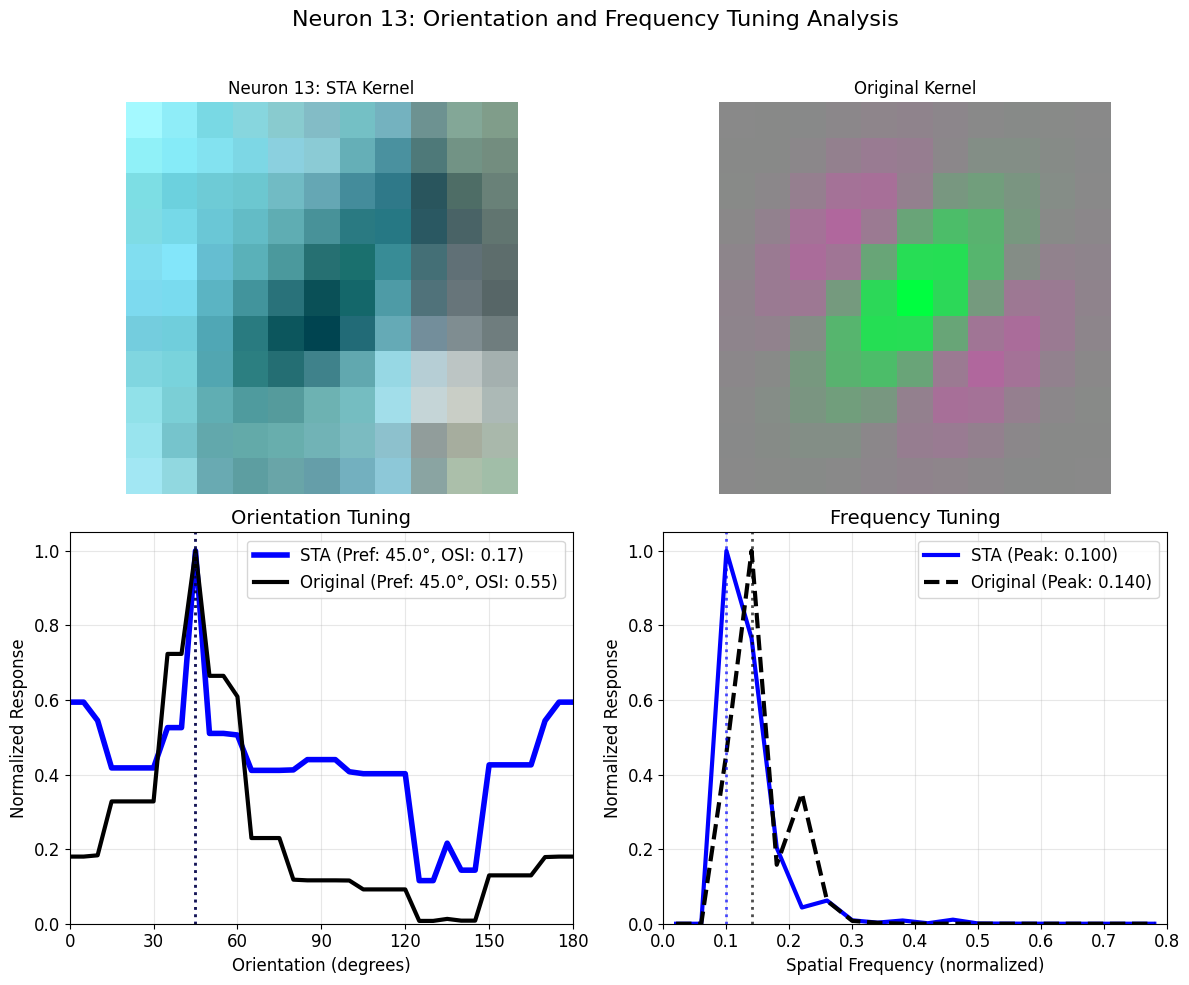


Neuron 13 Tuning Analysis Summary:
  STA Preferred Orientation: 45.0° (OSI: 0.17)
  Original Kernel Orientation: 45.0° (OSI: 0.55)
  STA Peak Frequency: 0.100
  Original Kernel Frequency: 0.140 (Ground truth: 0.106)
  Orientation Error: 0.0°
  Frequency Error: 0.040


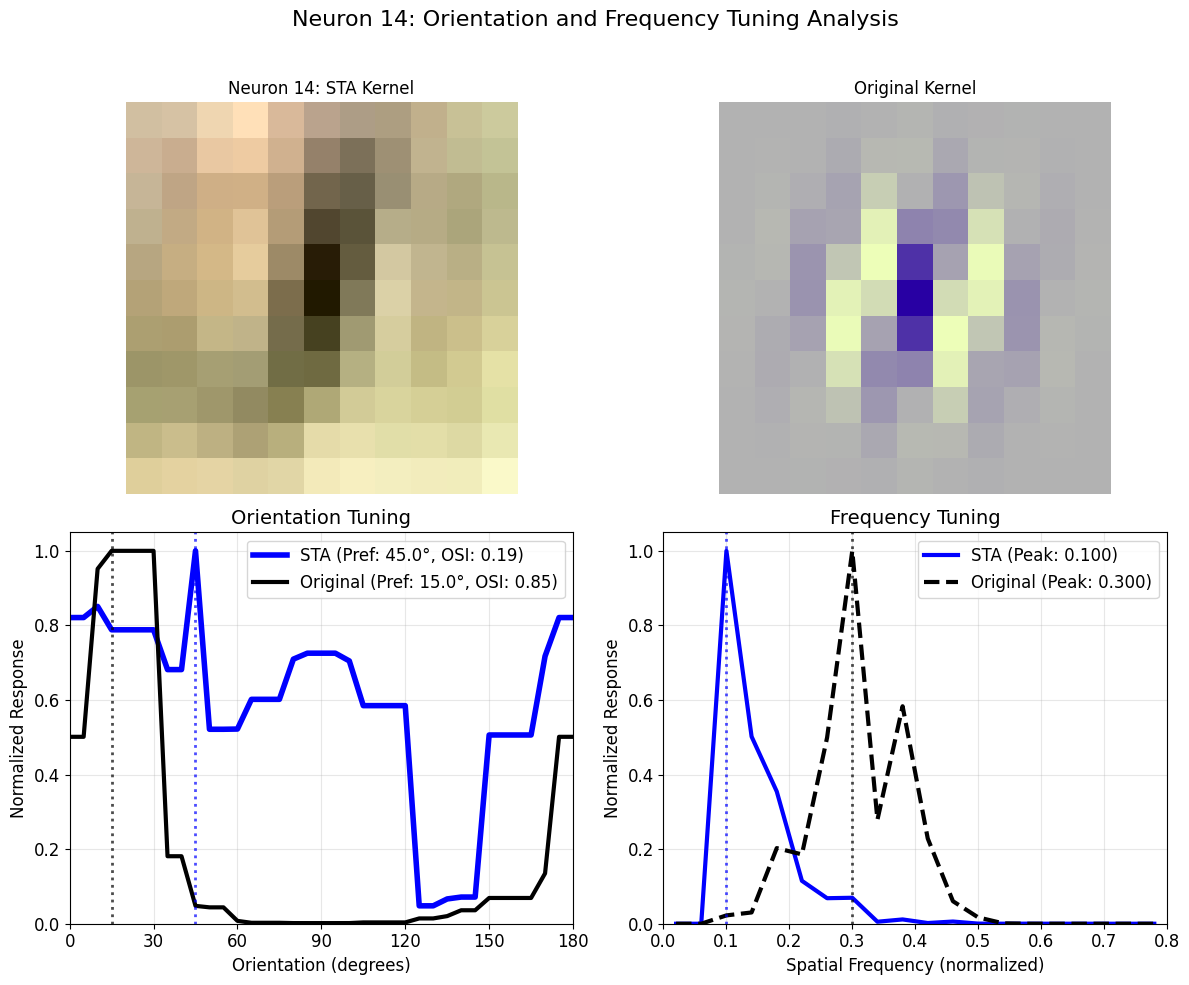


Neuron 14 Tuning Analysis Summary:
  STA Preferred Orientation: 45.0° (OSI: 0.19)
  Original Kernel Orientation: 15.0° (OSI: 0.85)
  STA Peak Frequency: 0.100
  Original Kernel Frequency: 0.300 (Ground truth: 0.213)
  Orientation Error: 30.0°
  Frequency Error: 0.200


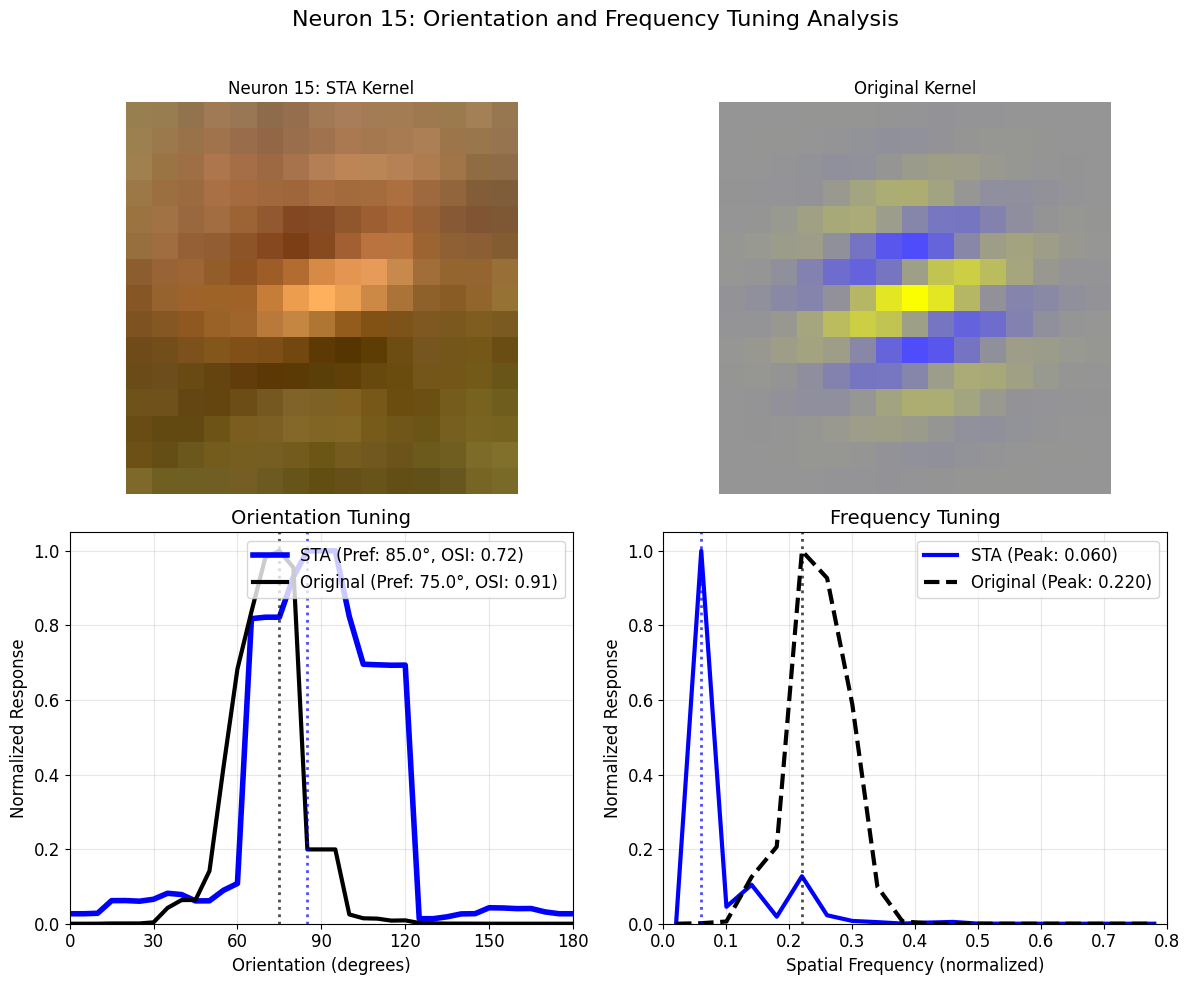


Neuron 15 Tuning Analysis Summary:
  STA Preferred Orientation: 85.0° (OSI: 0.72)
  Original Kernel Orientation: 75.0° (OSI: 0.91)
  STA Peak Frequency: 0.060
  Original Kernel Frequency: 0.220 (Ground truth: 0.164)
  Orientation Error: 10.0°
  Frequency Error: 0.160


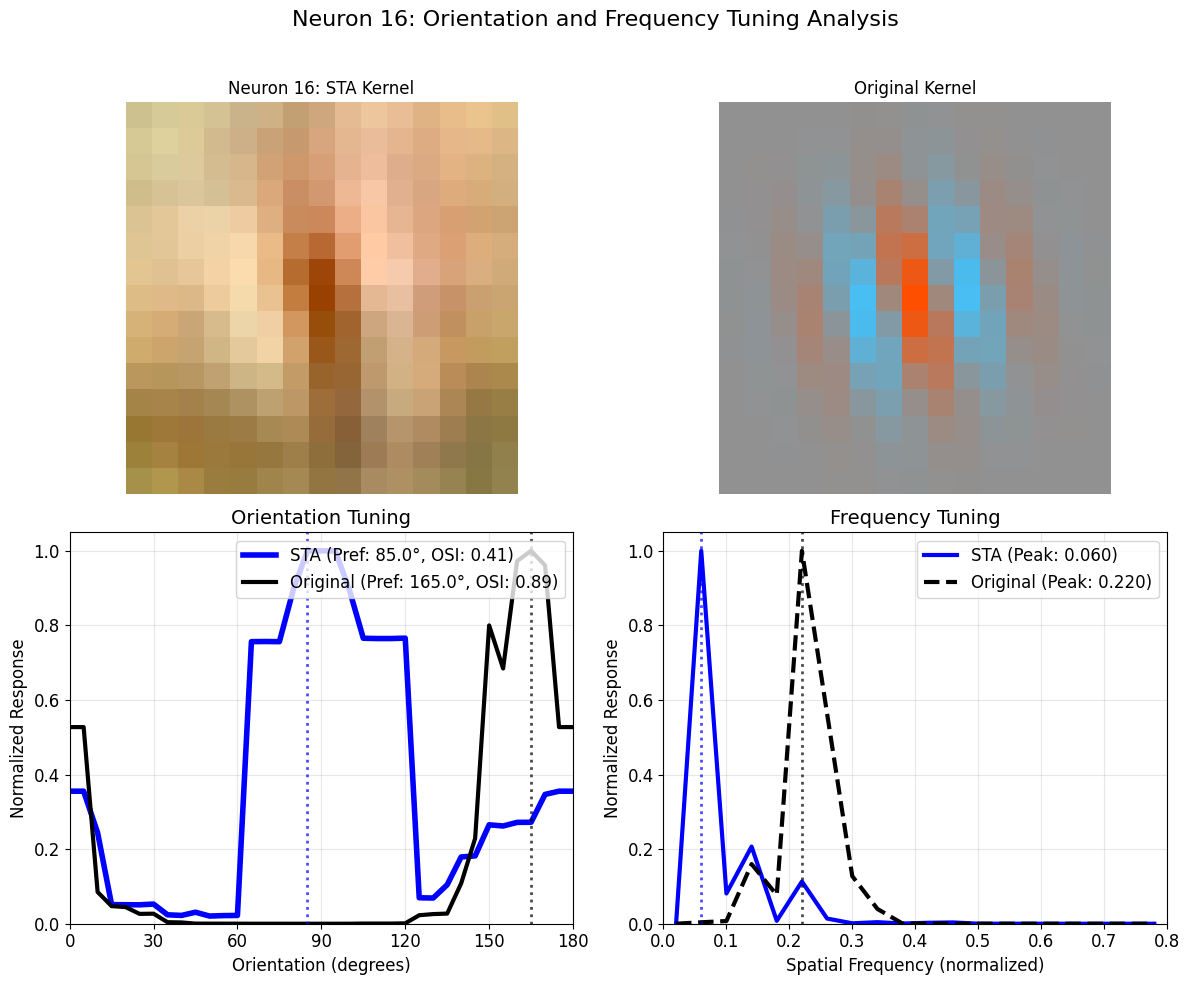


Neuron 16 Tuning Analysis Summary:
  STA Preferred Orientation: 85.0° (OSI: 0.41)
  Original Kernel Orientation: 165.0° (OSI: 0.89)
  STA Peak Frequency: 0.060
  Original Kernel Frequency: 0.220 (Ground truth: 0.153)
  Orientation Error: 80.0°
  Frequency Error: 0.160


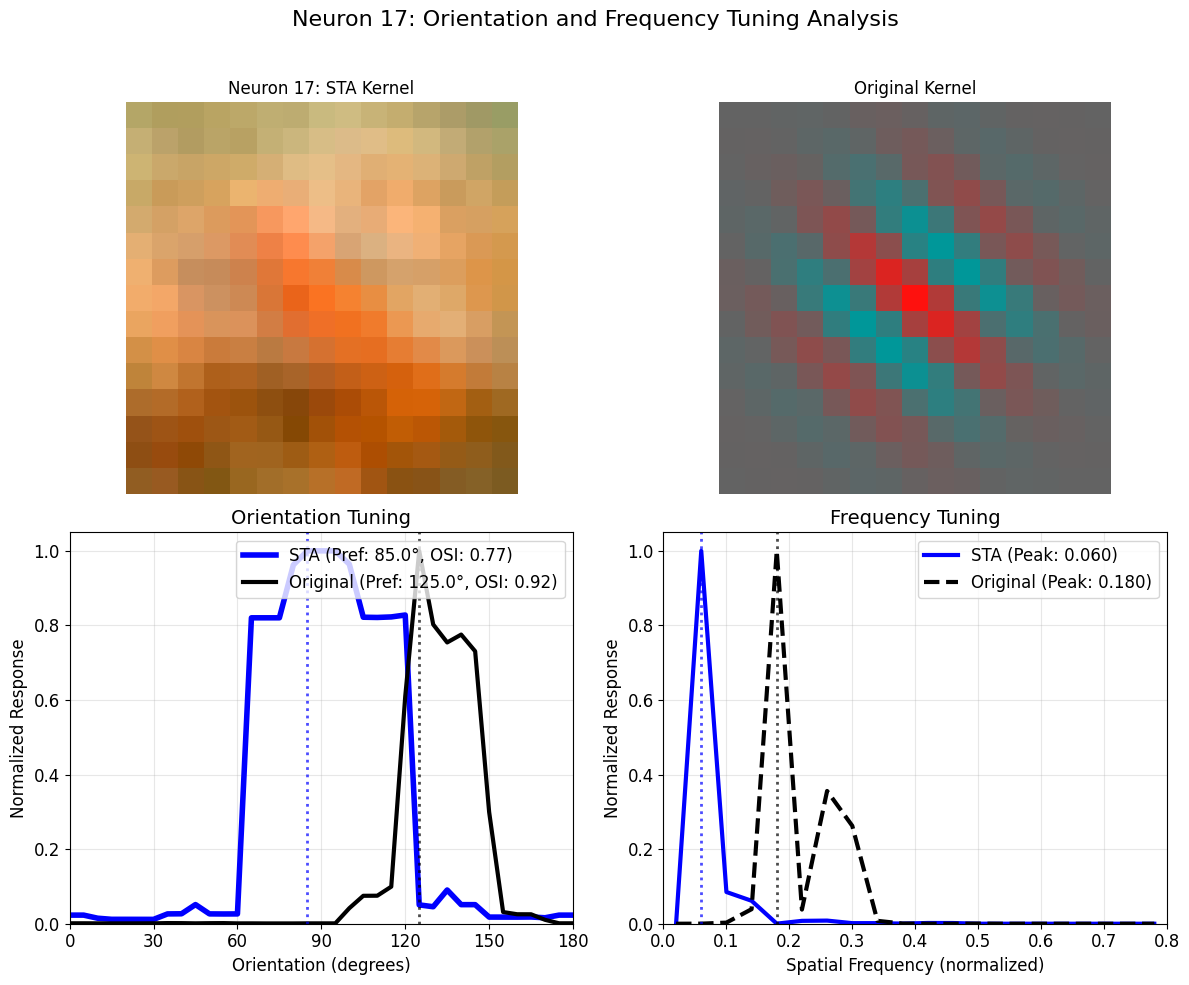


Neuron 17 Tuning Analysis Summary:
  STA Preferred Orientation: 85.0° (OSI: 0.77)
  Original Kernel Orientation: 125.0° (OSI: 0.92)
  STA Peak Frequency: 0.060
  Original Kernel Frequency: 0.180 (Ground truth: 0.184)
  Orientation Error: 40.0°
  Frequency Error: 0.120


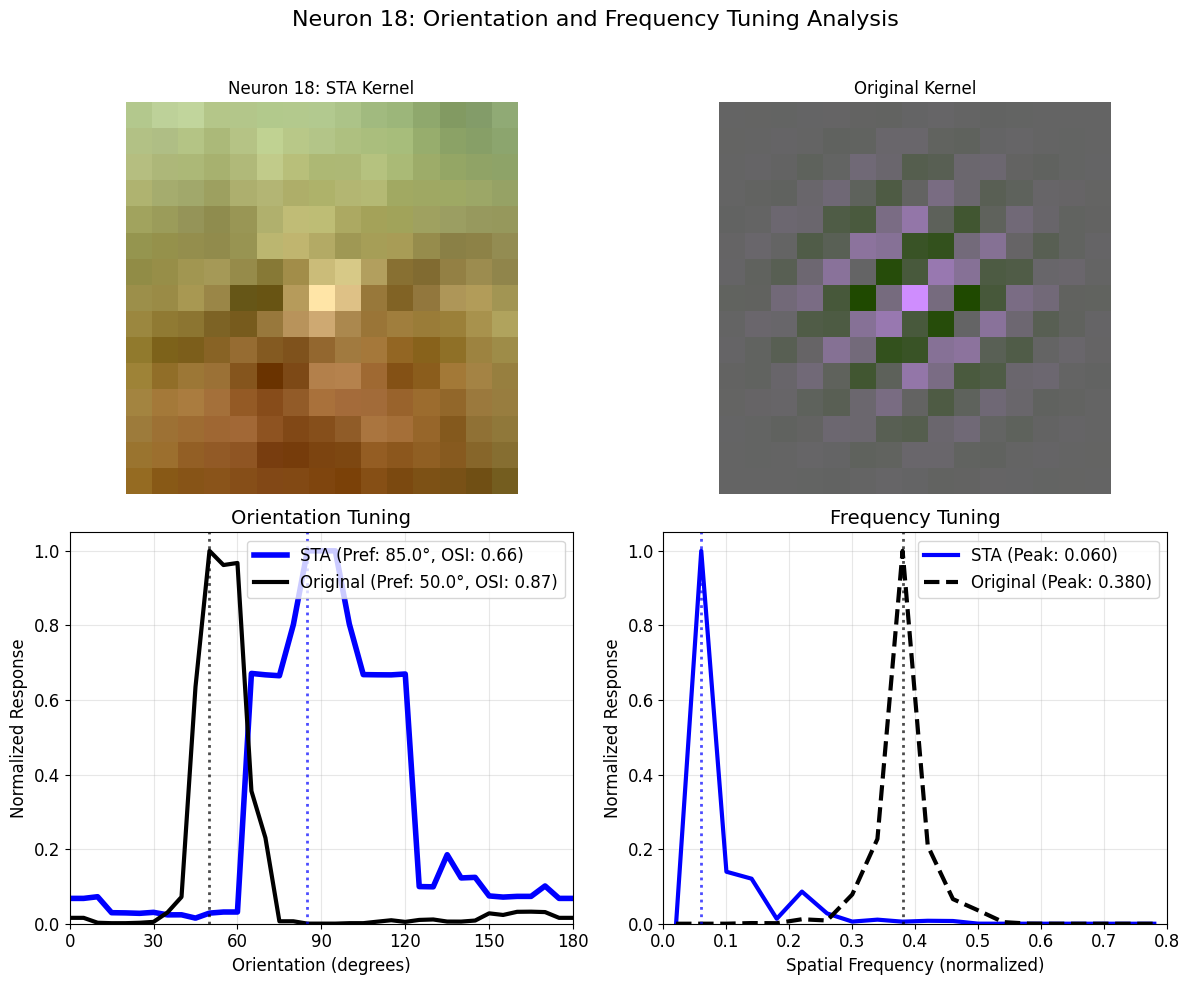


Neuron 18 Tuning Analysis Summary:
  STA Preferred Orientation: 85.0° (OSI: 0.66)
  Original Kernel Orientation: 50.0° (OSI: 0.87)
  STA Peak Frequency: 0.060
  Original Kernel Frequency: 0.380 (Ground truth: 0.278)
  Orientation Error: 35.0°
  Frequency Error: 0.320


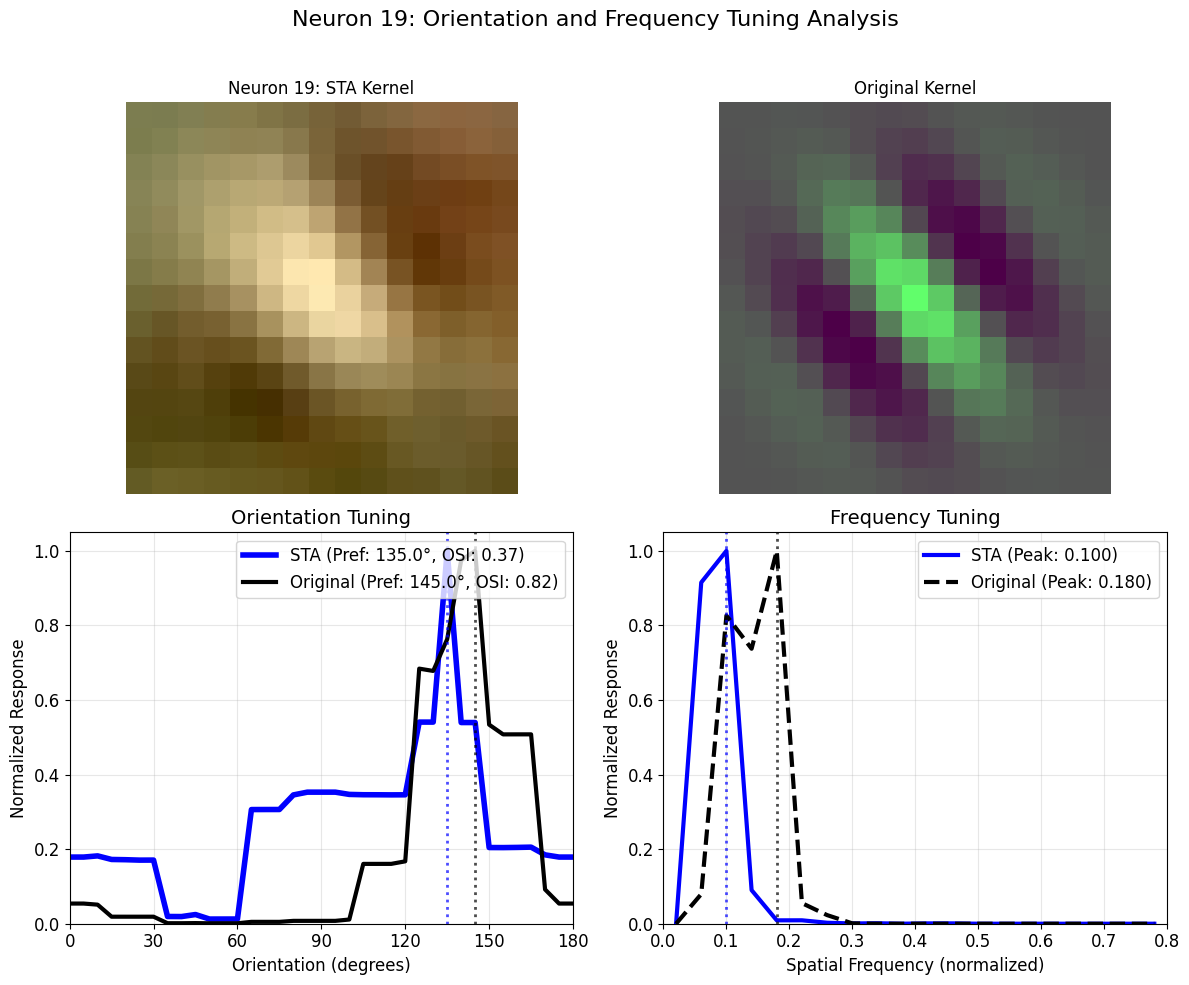


Neuron 19 Tuning Analysis Summary:
  STA Preferred Orientation: 135.0° (OSI: 0.37)
  Original Kernel Orientation: 145.0° (OSI: 0.82)
  STA Peak Frequency: 0.100
  Original Kernel Frequency: 0.180 (Ground truth: 0.116)
  Orientation Error: 10.0°
  Frequency Error: 0.080


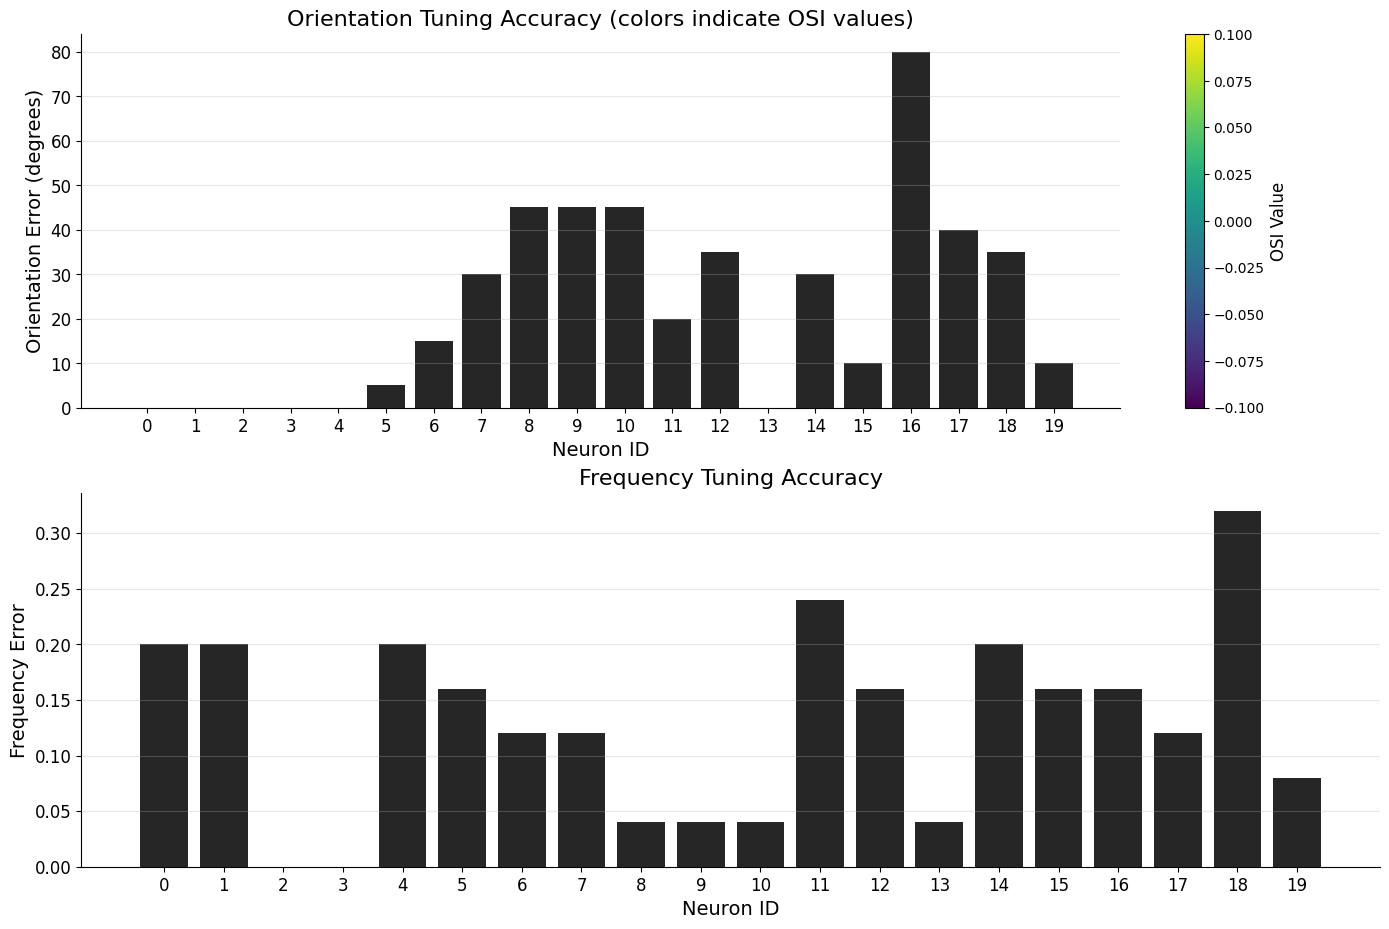

In [ ]:
def plot_tuning_analysis(analysis_results, sta_kernel, original_kernel):
    """
    Plot the results of the tuning analysis with improved visualization.
    """
    neuron_id = analysis_results["neuron_id"]

    # Use a standard 2x2 grid: top row for kernels, bottom row for tuning curves
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Plot STA kernel on top left
    axes[0, 0].imshow(norm_img(sta_kernel))
    axes[0, 0].set_title(f"Neuron {neuron_id}: STA Kernel", fontsize=12)
    axes[0, 0].axis('off')

    # 2. Plot Original kernel on top right
    axes[0, 1].imshow(norm_img(original_kernel))
    axes[0, 1].set_title("Original Kernel", fontsize=12)
    axes[0, 1].axis('off')

    # 3. Orientation Tuning plot on bottom left
    ax_ori = axes[1, 0]
    # STA: blue with thicker linewidth
    ax_ori.plot(analysis_results["angles"], analysis_results["sta_orientation_tuning"],
                'b-', linewidth=4, label=f"STA (Pref: {analysis_results['sta_preferred_orientation']:.1f}°, OSI: {analysis_results['sta_osi']:.2f})")
    # Original: black with linewidth 3
    ax_ori.plot(analysis_results["angles"], analysis_results["original_orientation_tuning"],
                'k-', linewidth=3, label=f"Original (Pref: {analysis_results['original_preferred_orientation']:.1f}°, OSI: {analysis_results['original_osi']:.2f})")

    # Markers for preferred orientations
    ax_ori.axvline(x=analysis_results["sta_preferred_orientation"], color='blue', linestyle=':', alpha=0.7, linewidth=2)
    ax_ori.axvline(x=analysis_results["original_preferred_orientation"], color='black', linestyle=':', alpha=0.7, linewidth=2)

    ax_ori.set_xlabel("Orientation (degrees)", fontsize=12)
    ax_ori.set_ylabel("Normalized Response", fontsize=12)
    ax_ori.set_title("Orientation Tuning", fontsize=14)
    ax_ori.set_xlim(0, 180)
    ax_ori.set_xticks(np.linspace(0, 180, 7))
    ax_ori.set_ylim(0, 1.05)
    ax_ori.legend(loc='upper right', fontsize=12)
    ax_ori.grid(True, alpha=0.3)
    ax_ori.tick_params(axis='both', which='major', labelsize=12)

    # 4. Frequency Tuning plot on bottom right
    ax_freq = axes[1, 1]
    ax_freq.plot(analysis_results["freq_bins"], analysis_results["sta_freq_tuning"],
                 'b-', linewidth=3, label=f"STA (Peak: {analysis_results['sta_peak_freq']:.3f})")
    ax_freq.plot(analysis_results["freq_bins"], analysis_results["original_freq_tuning"],
                 'k--', linewidth=3, label=f"Original (Peak: {analysis_results['original_peak_freq']:.3f})")

    # Markers for peak frequencies
    ax_freq.axvline(x=analysis_results["sta_peak_freq"], color='blue', linestyle=':', alpha=0.7, linewidth=2)
    ax_freq.axvline(x=analysis_results["original_peak_freq"], color='black', linestyle=':', alpha=0.7, linewidth=2)

    ax_freq.set_xlabel("Spatial Frequency (normalized)", fontsize=12)
    ax_freq.set_ylabel("Normalized Response", fontsize=12)
    ax_freq.set_title("Frequency Tuning", fontsize=14)
    ax_freq.set_xlim(0, 0.8)
    ax_freq.set_ylim(0, 1.05)
    ax_freq.legend(loc='upper right', fontsize=12)
    ax_freq.grid(True, alpha=0.3)
    ax_freq.tick_params(axis='both', which='major', labelsize=12)

    plt.suptitle(f"Neuron {neuron_id}: Orientation and Frequency Tuning Analysis", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

def perform_tuning_analysis(neuron_id, sta_kernel, original_kernel, freq, size, coords):
    """
    Perform orientation and frequency tuning analysis on a neuron.

    Parameters:
    -----------
    neuron_id : int
        ID of the neuron being analyzed
    sta_kernel : ndarray
        The cropped STA kernel for the neuron
    original_kernel : ndarray
        The original kernel used to generate the neuron's receptive field
    freq : float
        The frequency parameter of the original kernel
    size : int
        The size of the kernel
    coords : tuple
        The coordinates of the receptive field in the visual field

    Returns:
    --------
    dict
        A dictionary containing the tuning analysis results
    """
    # Convert to grayscale for analysis while keeping original RGB for display
    if sta_kernel.ndim == 3:
        sta_gray = np.mean(sta_kernel, axis=2)
    else:
        sta_gray = sta_kernel

    if original_kernel.ndim == 3:
        original_gray = np.mean(original_kernel, axis=2)
    else:
        original_gray = original_kernel

    # Subtract the mean (DC component) to enhance frequency components
    sta_gray = sta_gray - np.mean(sta_gray)
    original_gray = original_gray - np.mean(original_gray)

    # Apply slight Gaussian smoothing to reduce noise in STA
    sta_smooth = gaussian_filter(sta_gray, sigma=0.5)

    # Fourier transform for frequency analysis
    sta_fft = fftshift(fft2(sta_smooth))
    sta_power = np.abs(sta_fft)**2

    original_fft = fftshift(fft2(original_gray))
    original_power = np.abs(original_fft)**2

    # Get the center coordinates for the FFT
    center_y, center_x = np.array(sta_smooth.shape) // 2

    # Calculate orientation tuning
    angles = np.linspace(0, 180, 37)  # 5-degree increments for smoother curves
    sta_orientation_tuning = []
    original_orientation_tuning = []

    # Compute orientation tuning by sampling the power spectrum along different angles
    for angle in angles:
        theta = np.deg2rad(angle)
        max_radius = min(center_y, center_x) - 1
        sample_radii = np.arange(1, max_radius)
        y_coords = center_y + np.rint(sample_radii * np.sin(theta)).astype(int)
        x_coords = center_x + np.rint(sample_radii * np.cos(theta)).astype(int)

        # Ensure coordinates are within bounds
        valid_idx = (y_coords >= 0) & (y_coords < sta_power.shape[0]) & (x_coords >= 0) & (x_coords < sta_power.shape[1])
        y_coords, x_coords = y_coords[valid_idx], x_coords[valid_idx]

        if len(y_coords) > 0:
            sta_orientation_tuning.append(np.mean(sta_power[y_coords, x_coords]))
            original_orientation_tuning.append(np.mean(original_power[y_coords, x_coords]))
        else:
            sta_orientation_tuning.append(0)
            original_orientation_tuning.append(0)

    # Find preferred orientation
    sta_preferred_orientation = angles[np.argmax(sta_orientation_tuning)]
    original_preferred_orientation = angles[np.argmax(original_orientation_tuning)]

    # Normalize tuning curves for plotting (adding epsilon to avoid division by zero)
    epsilon = 1e-10
    sta_orientation_tuning = sta_orientation_tuning / (np.max(sta_orientation_tuning) + epsilon)
    original_orientation_tuning = original_orientation_tuning / (np.max(original_orientation_tuning) + epsilon)

    # Compute frequency tuning - with expanded range for higher frequencies
    freq_bins = np.linspace(0, 0.8, 21)  # Extended range up to 0.8 (normalized units)
    sta_freq_tuning = []
    original_freq_tuning = []

    for i in range(len(freq_bins)-1):
        freq_low = freq_bins[i]
        freq_high = freq_bins[i+1]

        # Create a mask for this frequency band
        y_grid, x_grid = np.indices(sta_smooth.shape)
        radius = np.sqrt((y_grid - center_y)**2 + (x_grid - center_x)**2) / max(sta_smooth.shape)
        freq_mask = (radius >= freq_low) & (radius < freq_high)

        sta_freq_tuning.append(np.mean(sta_power[freq_mask]) if np.any(freq_mask) else 0)
        original_freq_tuning.append(np.mean(original_power[freq_mask]) if np.any(freq_mask) else 0)

    # Find preferred frequency
    sta_preferred_freq = (freq_bins[:-1] + freq_bins[1:]) / 2
    sta_peak_freq = sta_preferred_freq[np.argmax(sta_freq_tuning)]
    original_peak_freq = sta_preferred_freq[np.argmax(original_freq_tuning)]

    # Normalize frequency tuning curves
    sta_freq_tuning = sta_freq_tuning / (np.max(sta_freq_tuning) + epsilon)
    original_freq_tuning = original_freq_tuning / (np.max(original_freq_tuning) + epsilon)

    # Calculate orientation selectivity index (OSI)
    sta_osi = calculate_osi(sta_orientation_tuning, angles)
    original_osi = calculate_osi(original_orientation_tuning, angles)

    return {
        "neuron_id": neuron_id,
        "sta_preferred_orientation": sta_preferred_orientation,
        "original_preferred_orientation": original_preferred_orientation,
        "sta_peak_freq": sta_peak_freq,
        "original_peak_freq": original_peak_freq,
        "sta_osi": sta_osi,
        "original_osi": original_osi,
        "angles": angles,
        "sta_orientation_tuning": sta_orientation_tuning,
        "original_orientation_tuning": original_orientation_tuning,
        "freq_bins": sta_preferred_freq,
        "sta_freq_tuning": sta_freq_tuning,
        "original_freq_tuning": original_freq_tuning,
        "sta_power": sta_power,
        "original_power": original_power
    }


# Main analysis loop (unchanged except summary figure modifications)
tuning_results = []

for neuron in selected_neurons:
    # Retrieve STA data
    sta = sta_results[neuron]
    kernel, freq, size, coords = v1_cells[neuron]

    # Crop the STA to the RF region
    cropped_sta = sta[coords[1]:coords[1]+size, coords[0]:coords[0]+size, :]

    # Perform tuning analysis
    analysis = perform_tuning_analysis(neuron, cropped_sta, kernel, freq, size, coords)
    tuning_results.append(analysis)

    # Plot the analysis
    fig = plot_tuning_analysis(analysis, cropped_sta, kernel)
    plt.show()

    # Print summary of findings
    print(f"\nNeuron {neuron} Tuning Analysis Summary:")
    print(f"  STA Preferred Orientation: {analysis['sta_preferred_orientation']:.1f}° (OSI: {analysis['sta_osi']:.2f})")
    print(f"  Original Kernel Orientation: {analysis['original_preferred_orientation']:.1f}° (OSI: {analysis['original_osi']:.2f})")
    print(f"  STA Peak Frequency: {analysis['sta_peak_freq']:.3f}")
    print(f"  Original Kernel Frequency: {analysis['original_peak_freq']:.3f} (Ground truth: {freq:.3f})")
    print(f"  Orientation Error: {min(180 - abs(analysis['sta_preferred_orientation'] - analysis['original_preferred_orientation']), abs(analysis['sta_preferred_orientation'] - analysis['original_preferred_orientation'])):.1f}°")
    print(f"  Frequency Error: {abs(analysis['sta_peak_freq'] - analysis['original_peak_freq']):.3f}")

# Plot a summary figure comparing all neurons - improved layout and presentation
if len(tuning_results) > 1:
    plt.figure(figsize=(14, 10))

    # Orientation accuracy plot with spines turned off
    ax1 = plt.subplot(2, 1, 1)
    neuron_ids = [r["neuron_id"] for r in tuning_results]
    orientation_errors = [min(180 - abs(r["sta_preferred_orientation"] - r["original_preferred_orientation"]),
                             abs(r["sta_preferred_orientation"] - r["original_preferred_orientation"]))
                         for r in tuning_results]
    osi_values = [r["sta_osi"] for r in tuning_results]

    # Create a colormap based on OSI values for orientation plot
    colors = plt.cm.viridis(np.array(osi_values)/max(osi_values))

    ax1.bar(neuron_ids, orientation_errors, alpha=0.85, color=colors)
    ax1.set_xlabel('Neuron ID', fontsize=14)
    ax1.set_ylabel('Orientation Error (degrees)', fontsize=14)
    ax1.set_title('Orientation Tuning Accuracy (colors indicate OSI values)', fontsize=16)
    ax1.set_xticks(neuron_ids)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid(axis='y', alpha=0.3)

    # Turn off top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(min(osi_values), max(osi_values)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1)
    cbar.set_label('OSI Value', fontsize=12)

    # Frequency accuracy plot with spines turned off
    ax2 = plt.subplot(2, 1, 2)
    freq_errors = [abs(r["sta_peak_freq"] - r["original_peak_freq"]) for r in tuning_results]

    ax2.bar(neuron_ids, freq_errors, alpha=0.85, color='black')
    ax2.set_xlabel('Neuron ID', fontsize=14)
    ax2.set_ylabel('Frequency Error', fontsize=14)
    ax2.set_title('Frequency Tuning Accuracy', fontsize=16)
    ax2.set_xticks(neuron_ids)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid(axis='y', alpha=0.3)

    # Turn off top and right spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


